In [1]:
# Ens podem guardar uns quants per veure com els classifica!!!!

In [2]:
#IDEA: predir no només el cluster del jugador sinó la posició al Draft i si jugaran Playoff (implícit, xq faria 2 clústers). 

In [3]:
#pip install progressbar
#pip install XXXXXXXXXXX [other packages needed]

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup, SoupStrainer
import sys
import ast
import string
import missingno as msno 
import seaborn as sn
import requests
import datetime
import progressbar
import time
import re
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from pandas_profiling import ProfileReport
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

#Maybe not used! (REVIEW)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn import cluster
import scipy.spatial.distance as distance
from sklearn.neighbors import kneighbors_graph
import pickle

import warnings
warnings.filterwarnings("ignore")


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

# A data modelling cal aclarir que un 10% de jugadors surt amb nº de playoff>0 i en canvi sense stats (equips que han jugat, ells no)!!!

## 4.1 Import Data

In [4]:
df_golden_record_raw = pd.read_excel('Clean_data/Golden_Record.xlsx',index_col=0)

In [5]:
df_golden_record = df_golden_record_raw.copy()
df_golden_record

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,draft_year,draft_round,draft_pick_number,n_playoff,n_total_wins,w_l_pct,most_popular_team_played,triple_double_metric_RegS,triple_double_metric_Playoff,championship_pct
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,1978,5,104,6,744,0.504,Washington Wizards,0.223333,0.010000,0.0
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,1968,1,101,4,192,0.585,Atlanta Hawks,0.203333,0.000000,0.0
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,1994,1,22,0,51,0.207,Golden State Warriors,0.170000,0.000000,0.0
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,1991,1,22,1,42,0.512,Miami Heat,0.190000,0.000000,0.0
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,2008,1,29,2,86,0.524,Charlotte Hornets,0.323333,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,0,2.6,0.286,0.0,0.3,1.000,1.8,0.1,1.6,NaN,...,1979,2,32,0,37,0.451,Indiana Pacers,0.123333,NaN,0.0
3438,23,2.9,0.408,0.0,1.2,0.783,2.1,0.2,1.8,NaN,...,1995,1,22,2,122,0.744,Oklahoma City Thunder,0.190000,NaN,0.0
3439,0,1.5,0.667,0.0,0.0,0.000,2.0,3.5,2.0,NaN,...,2003,2,40,4,196,0.598,Brooklyn Nets,0.250000,NaN,0.0
3440,0,1.6,0.323,0.0,0.3,0.600,1.8,0.2,0.9,NaN,...,2016,2,41,0,29,0.354,Orlando Magic,0.106667,NaN,0.0


## 4. 2 Tranform and prepare data for clustering

In [6]:
df_golden_record.dtypes

games_started_RegS                   int64
field_goals_attempts_pg_RegS       float64
field_goals_percent_pg_RegS        float64
_3pts_goals_attempts_pg_RegS       float64
FT_goals_attempts_pg_RegS          float64
FT_goals_percent_pg_RegS           float64
total_rebounds_pg_RegS             float64
assists_pg_RegS                    float64
personal_foults_pg_RegS            float64
games_started_Playoff              float64
field_goals_attempts_pg_Playoff    float64
field_goals_percent_pg_Playoff     float64
_3pts_goals_attempts_pg_Playoff    float64
FT_goals_attempts_pg_Playoff       float64
FT_goals_percent_pg_Playoff        float64
total_rebounds_pg_Playoff          float64
assists_pg_Playoff                 float64
personal_foults_pg_Playoff         float64
FT_goals_attempts_total_RegS         int64
assists_total_RegS                   int64
FT_goals_attempts_total_Playoff    float64
assists_total_Playoff              float64
player_eff_rating_RegS             float64
true_shooti

In [7]:
string_cols = df_golden_record.columns[df_golden_record.dtypes == object]
string_cols

Index(['Hall_Of_Fame', 'gone_to_college', 'teams_years_dict', 'player_url',
       'Playoff_flag', 'player_name', 'position', 'college',
       'most_popular_team_played'],
      dtype='object')

In [8]:
for i in string_cols:
    if len(df_golden_record[i].unique())<5:
        print('Distribution for column ' + i + ':')
        print(df_golden_record[i].value_counts())
    else:
        print('To much categories in column ' + i)
    

Distribution for column Hall_Of_Fame:
No     3293
Yes     149
Name: Hall_Of_Fame, dtype: int64
Distribution for column gone_to_college:
No     2541
Yes     901
Name: gone_to_college, dtype: int64
To much categories in column teams_years_dict
To much categories in column player_url
Distribution for column Playoff_flag:
Yes    2316
No     1126
Name: Playoff_flag, dtype: int64
To much categories in column player_name
To much categories in column position
To much categories in column college
To much categories in column most_popular_team_played


In [9]:
df_golden_record_0 = df_golden_record.copy()
string_cols_to_drop = ['teams_years_dict','player_url','player_name','college'] 
#we drop college in here because half players hasn't gone to college!!!

df_golden_record_0 = df_golden_record_0[[c for c in df_golden_record_0.columns if c not in string_cols_to_drop]]
df_golden_record_0

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,draft_year,draft_round,draft_pick_number,n_playoff,n_total_wins,w_l_pct,most_popular_team_played,triple_double_metric_RegS,triple_double_metric_Playoff,championship_pct
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,1978,5,104,6,744,0.504,Washington Wizards,0.223333,0.010000,0.0
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,1968,1,101,4,192,0.585,Atlanta Hawks,0.203333,0.000000,0.0
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,1994,1,22,0,51,0.207,Golden State Warriors,0.170000,0.000000,0.0
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,1991,1,22,1,42,0.512,Miami Heat,0.190000,0.000000,0.0
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,2008,1,29,2,86,0.524,Charlotte Hornets,0.323333,0.066667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,0,2.6,0.286,0.0,0.3,1.000,1.8,0.1,1.6,NaN,...,1979,2,32,0,37,0.451,Indiana Pacers,0.123333,NaN,0.0
3438,23,2.9,0.408,0.0,1.2,0.783,2.1,0.2,1.8,NaN,...,1995,1,22,2,122,0.744,Oklahoma City Thunder,0.190000,NaN,0.0
3439,0,1.5,0.667,0.0,0.0,0.000,2.0,3.5,2.0,NaN,...,2003,2,40,4,196,0.598,Brooklyn Nets,0.250000,NaN,0.0
3440,0,1.6,0.323,0.0,0.3,0.600,1.8,0.2,0.9,NaN,...,2016,2,41,0,29,0.354,Orlando Magic,0.106667,NaN,0.0


<AxesSubplot:>

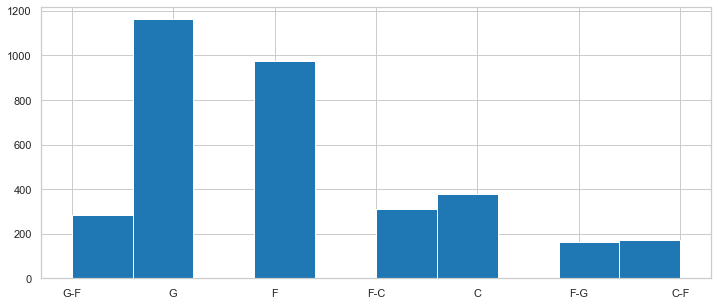

In [10]:
df_golden_record_0['position'].hist()

#We only consider 5 positions:
#G -> Guard (1)
#G-F/F-G -> Shooting-guard (2)
#F -> Forward (3)
#F-C/C-F -> Power-forward (4)
#C -> Center

<AxesSubplot:>

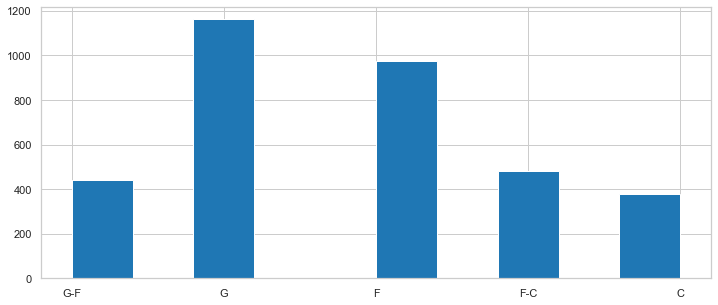

In [11]:
df_golden_record_0['position'] = df_golden_record_0['position'].apply(lambda x: 'G-F' if x=='F-G' else 'F-C' if x=='C-F' else x)
df_golden_record_0['position'].hist()

In [12]:
df_golden_record_0['position'].value_counts()

G      1161
F       975
F-C     483
G-F     443
C       380
Name: position, dtype: int64

In [13]:
df_golden_record_0['most_popular_team_played'].value_counts()

Philadelphia 76ers        175
Golden State Warriors     168
Brooklyn Nets             160
Atlanta Hawks             156
Detroit Pistons           155
Sacramento Kings          152
New York Knicks           151
Washington Wizards        148
Los Angeles Clippers      146
Los Angeles Lakers        140
San Antonio Spurs         137
Boston Celtics            133
Denver Nuggets            124
Indiana Pacers            118
Portland Trail Blazers    117
Cleveland Cavaliers       114
Milwaukee Bucks           113
Oklahoma City Thunder     108
Phoenix Suns               99
Houston Rockets            94
Dallas Mavericks           92
Chicago Bulls              92
Utah Jazz                  90
Memphis Grizzlies          75
Minnesota Timberwolves     73
Miami Heat                 71
Orlando Magic              71
Charlotte Hornets          64
Toronto Raptors            63
New Orleans Pelicans       43
Name: most_popular_team_played, dtype: int64

In [14]:
def top_teams(Team):
    top_10_list = ['Philadelphia 76ers','Golden State Warriors','Brooklyn Nets','Atlanta Hawks','Detroit Pistons',
                   'Sacramento Kings','New York Knicks','Washington Wizards','Los Angeles Clippers','Los Angeles Lakers']
    if Team in top_10_list:
        return Team
    else:
        return 'Other'

In [15]:
df_golden_record_aux = df_golden_record_0.copy()
df_golden_record_aux = df_golden_record_aux.join(df_golden_record[['player_url','player_name']])

In [16]:
df_golden_record_aux.head()

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,draft_pick_number,n_playoff,n_total_wins,w_l_pct,most_popular_team_played,triple_double_metric_RegS,triple_double_metric_Playoff,championship_pct,player_url,player_name
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,104,6,744,0.504,Washington Wizards,0.223333,0.010000,0.0,/players/t/terryca01.html,Carlos Terry
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,101,4,192,0.585,Atlanta Hawks,0.203333,0.000000,0.0,/players/h/harlisk01.html,Skip Harlicka
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,22,0,51,0.207,Golden State Warriors,0.170000,0.000000,0.0,/players/c/curlebi01.html,Bill Curley
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,22,1,42,0.512,Miami Heat,0.190000,0.000000,0.0,/players/e/ellisle02.html,LeRon Ellis
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,29,2,86,0.524,Charlotte Hornets,0.323333,0.066667,0.0,/players/w/whitedj01.html,D.J. White


In [17]:
df_golden_record_0['most_popular_team_played'] = df_golden_record_0['most_popular_team_played'].apply(lambda x: top_teams(x))
df_golden_record_0['most_popular_team_played'].value_counts()

Other                    1891
Philadelphia 76ers        175
Golden State Warriors     168
Brooklyn Nets             160
Atlanta Hawks             156
Detroit Pistons           155
Sacramento Kings          152
New York Knicks           151
Washington Wizards        148
Los Angeles Clippers      146
Los Angeles Lakers        140
Name: most_popular_team_played, dtype: int64

We transform the Binary string variables (to 1,0)

In [18]:
df_golden_record_0['Hall_Of_Fame'] = df_golden_record_0['Hall_Of_Fame'].apply(lambda x: 1 if x=='Yes' else 0)
df_golden_record_0['gone_to_college'] = df_golden_record_0['gone_to_college'].apply(lambda x: 1 if x=='Yes' else 0)
df_golden_record_0['Playoff_flag'] = df_golden_record_0['Playoff_flag'].apply(lambda x: 1 if x=='Yes' else 0)

We transform the position and time via OneHotEncoding

In [19]:
df_golden_record_0.head()

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,draft_year,draft_round,draft_pick_number,n_playoff,n_total_wins,w_l_pct,most_popular_team_played,triple_double_metric_RegS,triple_double_metric_Playoff,championship_pct
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,1978,5,104,6,744,0.504,Washington Wizards,0.223333,0.010000,0.0
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,1968,1,101,4,192,0.585,Atlanta Hawks,0.203333,0.000000,0.0
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,1994,1,22,0,51,0.207,Golden State Warriors,0.170000,0.000000,0.0
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,1991,1,22,1,42,0.512,Other,0.190000,0.000000,0.0
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,2008,1,29,2,86,0.524,Other,0.323333,0.066667,0.0


In [20]:
string_cols = df_golden_record_0.columns[df_golden_record_0.dtypes == object]
string_cols

Index(['position', 'most_popular_team_played'], dtype='object')

In [21]:
df_golden_record_1 = df_golden_record_0.copy()

df_golden_record_1 = pd.get_dummies(df_golden_record_1,prefix='',prefix_sep='')#,prefix='OHE'

In [22]:
df_golden_record_1

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,Brooklyn Nets,Detroit Pistons,Golden State Warriors,Los Angeles Clippers,Los Angeles Lakers,New York Knicks,Other,Philadelphia 76ers,Sacramento Kings,Washington Wizards
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,0,0,0,0,0,0,0,0,0,0
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,0,0,1,0,0,0,0,0,0,0
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,0,0,0,0,0,0,1,0,0,0
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,0,2.6,0.286,0.0,0.3,1.000,1.8,0.1,1.6,NaN,...,0,0,0,0,0,0,1,0,0,0
3438,23,2.9,0.408,0.0,1.2,0.783,2.1,0.2,1.8,NaN,...,0,0,0,0,0,0,1,0,0,0
3439,0,1.5,0.667,0.0,0.0,0.000,2.0,3.5,2.0,NaN,...,1,0,0,0,0,0,0,0,0,0
3440,0,1.6,0.323,0.0,0.3,0.600,1.8,0.2,0.9,NaN,...,0,0,0,0,0,0,1,0,0,0


In [23]:
string_cols = df_golden_record_1.columns[df_golden_record_1.dtypes == object]
string_cols

Index([], dtype='object')

#### Divide into two datasets depending on if the've played playoff or not

In [24]:
df_golden_record_playoff = df_golden_record_1[df_golden_record_1['Playoff_flag']==1]
print(len(df_golden_record_playoff))
print(str(round((len(df_golden_record_playoff)/len(df_golden_record_1))*100,2)) + '% of the records.')

2316
67.29% of the records.


In [25]:
df_golden_record_no_playoff = df_golden_record_1[df_golden_record_1['Playoff_flag']!=1]
print(len(df_golden_record_no_playoff))
print(str(round((len(df_golden_record_no_playoff)/len(df_golden_record_1))*100,2)) + '% of the records.')

1126
32.71% of the records.


In [26]:
print(len(df_golden_record_no_playoff.columns))
df_golden_record_no_playoff = df_golden_record_no_playoff.dropna(axis=1)
print(len(df_golden_record_no_playoff.columns))

69
53


#### We normalize numeric data in order to use k-means...

First with the NON-Playoff dataset

In [27]:
numeric_cols = ['games_started_RegS', 'field_goals_attempts_pg_RegS',
       'field_goals_percent_pg_RegS', '_3pts_goals_attempts_pg_RegS',
       'FT_goals_attempts_pg_RegS', 'FT_goals_percent_pg_RegS',
       'total_rebounds_pg_RegS', 'assists_pg_RegS', 'personal_foults_pg_RegS',
       'FT_goals_attempts_total_RegS', 'assists_total_RegS',
       'player_eff_rating_RegS', 'true_shooting_eff_RegS',
       'usage_percent_RegS', 'win_share_RegS', 'Hall_Of_Fame', 'n_NBA_Champ',
       'n_All_Star', 'gone_to_college', 'n_teams', 'Playoff_flag',
       'active_from', 'active_to', 'weight', 'birth_date(year)', 'height(cm)',
       'age_entrance', 'age_retirement', 'years_active', 'draft_year',
       'draft_round', 'draft_pick_number', 'n_playoff', 'n_total_wins',
       'w_l_pct', 'triple_double_metric_RegS', 'championship_pct'] #others are OHE!!!!
print(len(numeric_cols))

37


{'whiskers': [<matplotlib.lines.Line2D at 0x2a969ec0520>,
 'caps': [<matplotlib.lines.Line2D at 0x2a969ec0c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a969ec01c0>],
 'medians': [<matplotlib.lines.Line2D at 0x2a969edf310>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a969edf670>],
 'means': []}

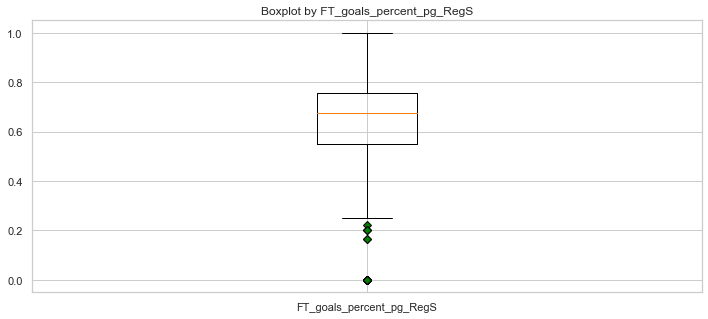

In [28]:
numeric_col_name = 'FT_goals_percent_pg_RegS'

subset = df_golden_record_no_playoff[[numeric_col_name]]
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()

ax.set_title('Boxplot by ' + numeric_col_name)
ax.boxplot(subset, flierprops=green_diamond,labels=[numeric_col_name])

In [29]:
scaler = StandardScaler() #Standardize features by removing the mean and scaling to unit variance
datanorm_no_playoff = scaler.fit_transform(df_golden_record_no_playoff.astype(float))

In [30]:
datanorm_no_playoff

array([[-0.32987226, -0.69496759, -2.96924273, ...,  4.54465028,
        -0.24344656, -0.22661393],
       [-0.32987226, -0.29534509, -0.15333971, ..., -0.22003893,
        -0.24344656, -0.22661393],
       [ 1.11681193, -0.00471055,  0.40984089, ..., -0.22003893,
        -0.24344656, -0.22661393],
       ...,
       [-0.32987226, -0.87661418,  2.10699325, ..., -0.22003893,
        -0.24344656, -0.22661393],
       [-0.32987226, -0.84028486, -0.5110355 , ..., -0.22003893,
        -0.24344656, -0.22661393],
       [-0.32987226, -0.513321  , -0.20661356, ..., -0.22003893,
        -0.24344656, -0.22661393]])

## 4. 3 Clustering no-playoff players

First kick study with k-means and K=4 (remember we wnat not more than 7-10 clusters in order to get clear qualitative profiles for the diff types of players)

In [31]:
K=4
clf = cluster.KMeans(n_clusters=K, random_state=0) #initialize the k-means clustering
clf.fit(datanorm_no_playoff) #run the k-means clustering

KMeans(n_clusters=4, random_state=0)

In [32]:
y_pred_no_playoff = clf.predict(datanorm_no_playoff) #Predict the closest cluster each sample in X belongs to.
print(y_pred_no_playoff)

[3 2 0 ... 2 1 3]


In [33]:
print('Clusters:[', len(datanorm_no_playoff[(clf.labels_==0)]),len(datanorm_no_playoff[(clf.labels_==1)]),
              len(datanorm_no_playoff[(clf.labels_==2)]),len(datanorm_no_playoff[(clf.labels_==3)]),']')

Clusters:[ 86 370 261 409 ]


In [34]:
df_golden_record_no_playoff_clustered = df_golden_record_no_playoff.copy()
df_golden_record_no_playoff_clustered['cluster'] = y_pred_no_playoff
df_golden_record_no_playoff_clustered.head()

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,FT_goals_attempts_total_RegS,...,Detroit Pistons,Golden State Warriors,Los Angeles Clippers,Los Angeles Lakers,New York Knicks,Other,Philadelphia 76ers,Sacramento Kings,Washington Wizards,cluster
2316,0,2.0,0.000,-1.0,0.0,0.000,1.0,1.0,1.0,0,...,0,0,0,0,0,0,1,0,0,3
2317,0,3.1,0.370,0.8,0.3,0.500,1.0,0.5,0.4,10,...,0,0,1,0,0,0,0,0,0,2
2318,60,3.9,0.444,1.6,1.1,0.759,3.5,0.6,2.0,386,...,0,0,0,0,0,1,0,0,0,0
2319,0,2.0,0.314,0.0,0.4,0.700,2.3,0.2,0.6,10,...,0,0,0,0,0,1,0,0,0,1
2320,0,4.5,0.293,-1.0,1.2,0.598,4.2,0.3,2.2,92,...,0,0,0,1,0,0,0,0,0,3


In [35]:
N = 10
attributes = df_golden_record_no_playoff.columns.tolist()
#attributes = attributes[:N]

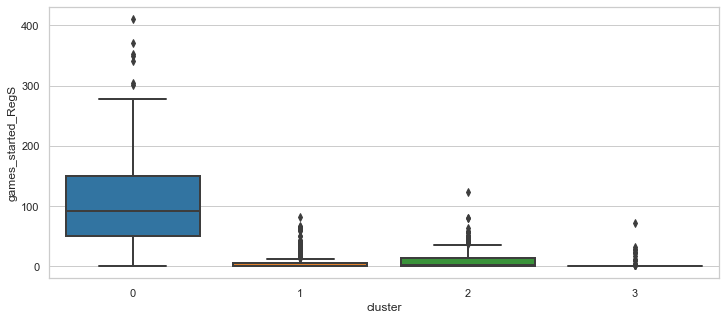

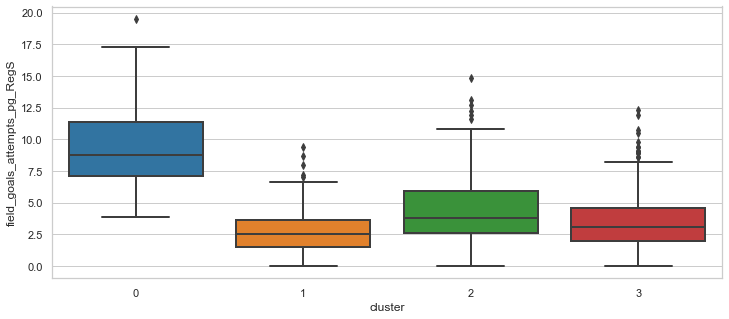

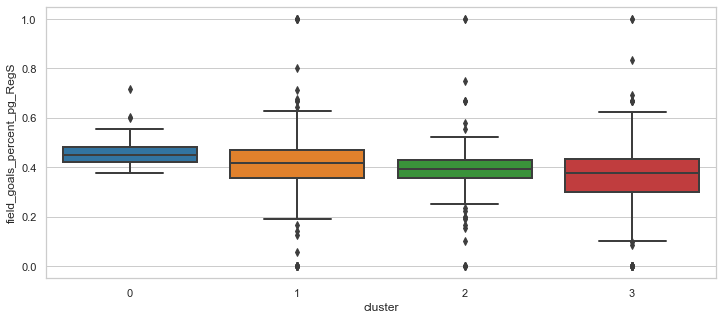

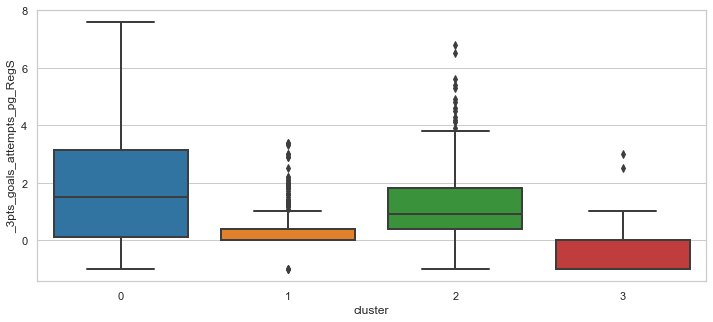

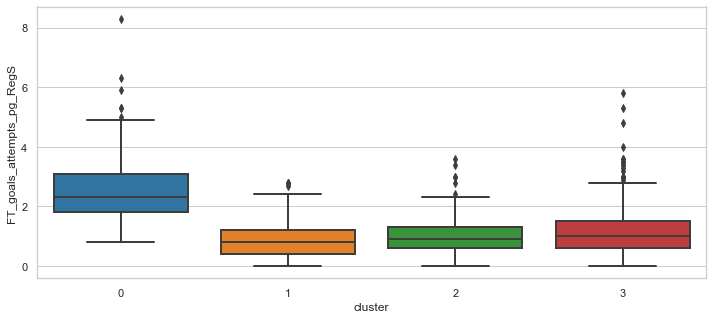

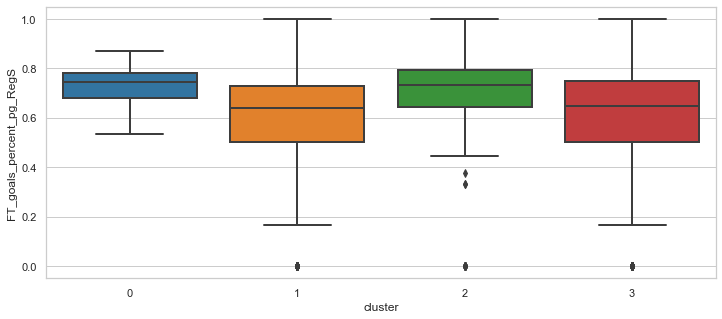

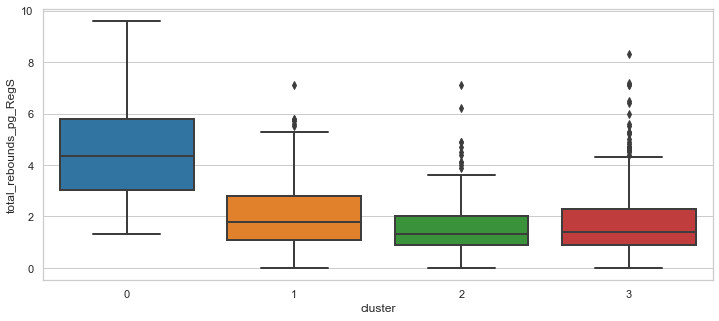

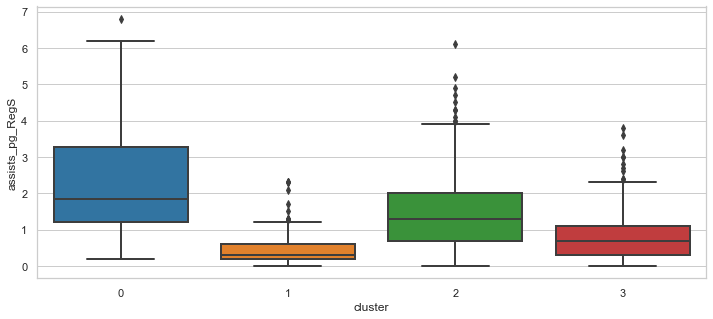

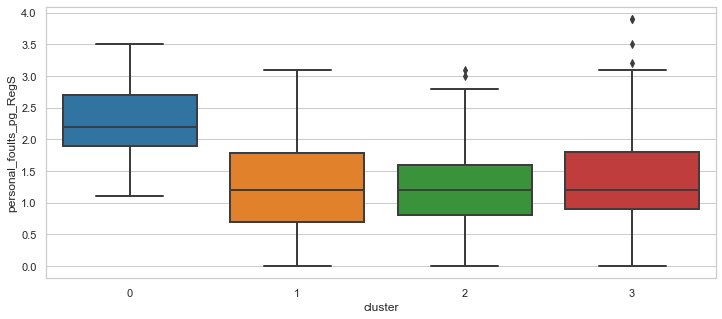

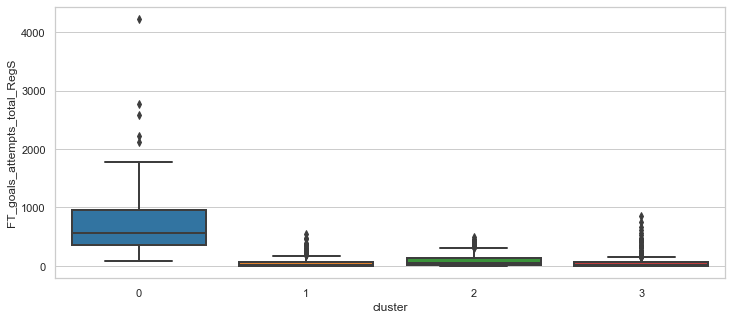

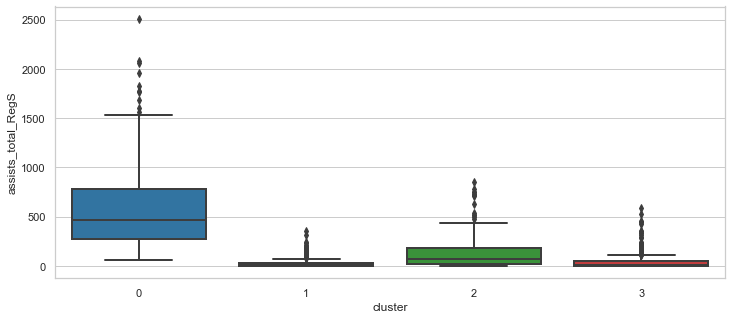

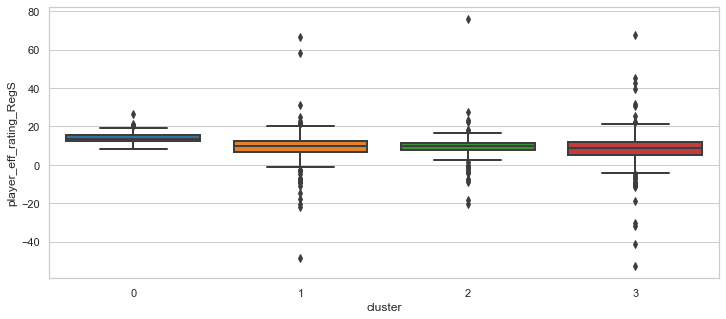

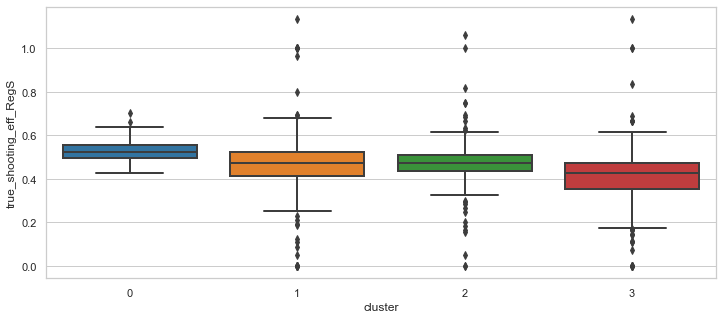

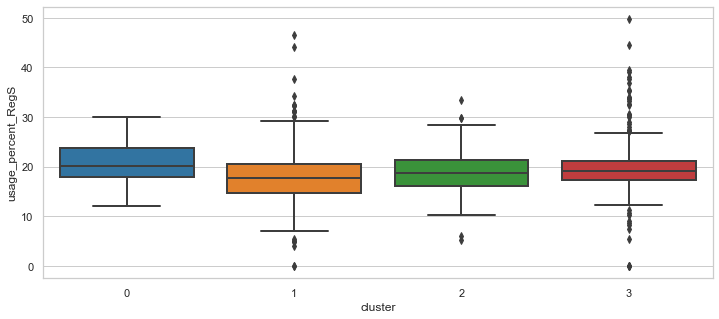

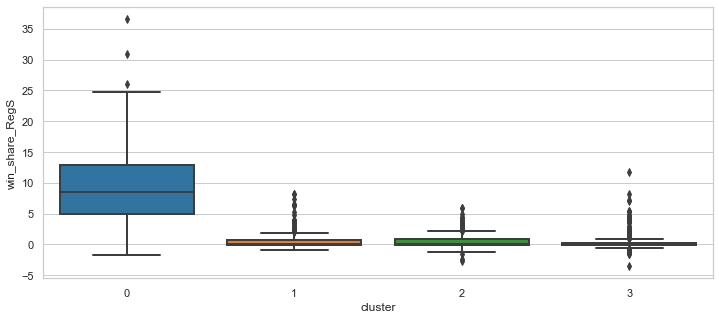

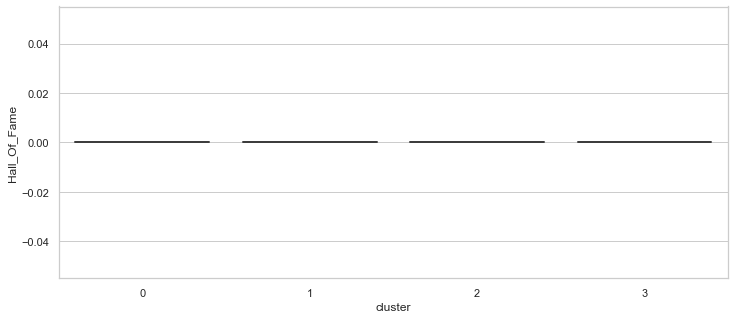

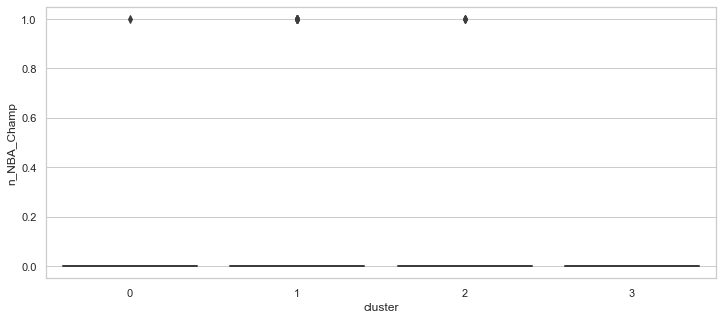

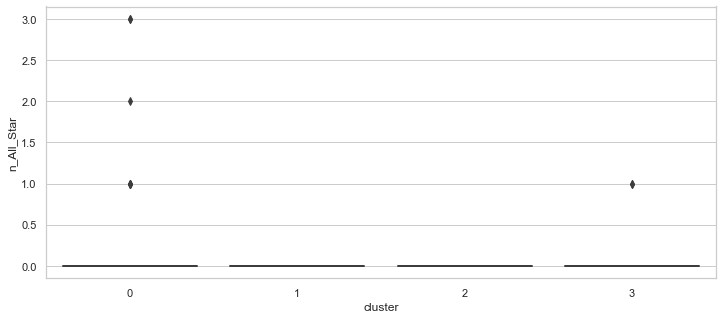

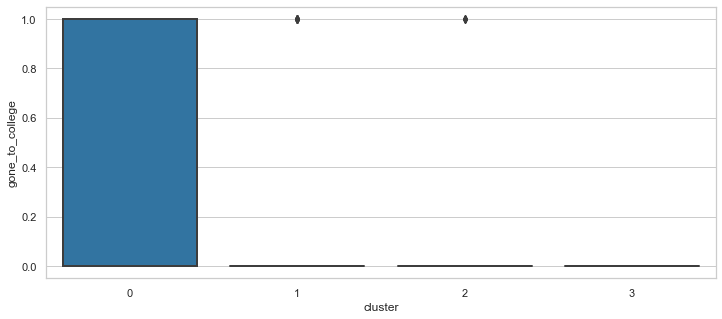

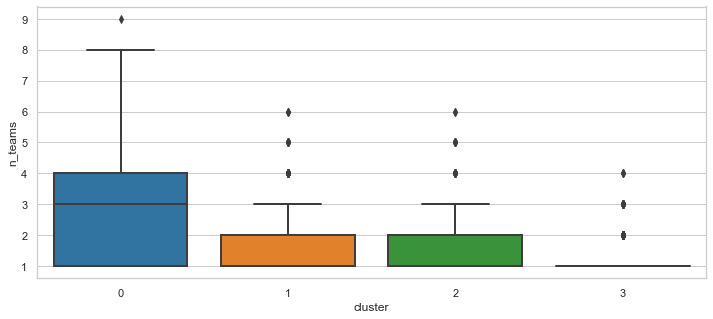

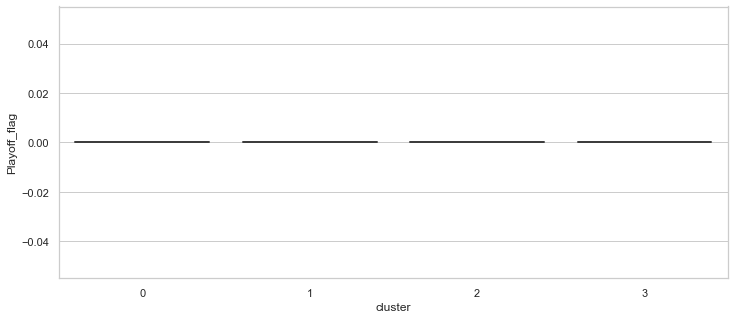

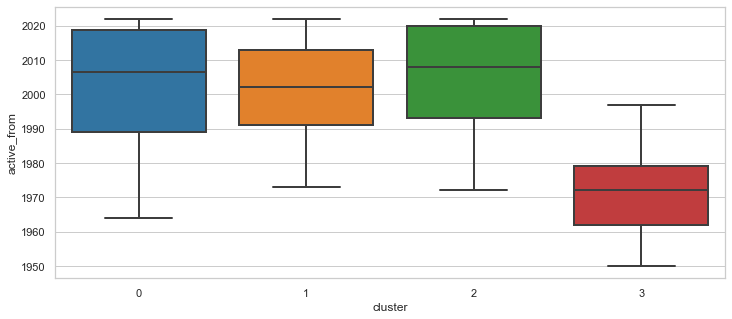

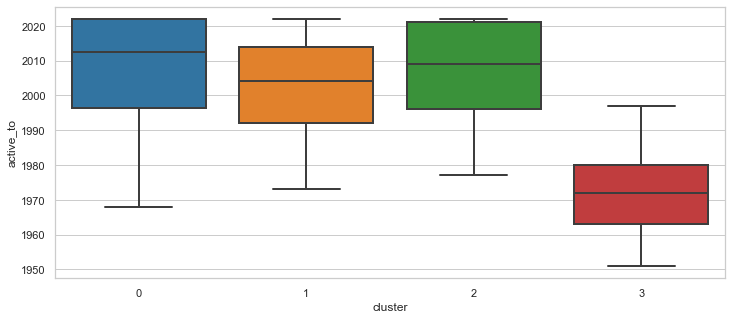

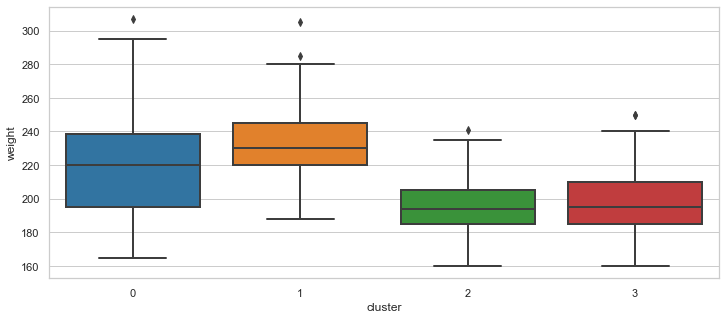

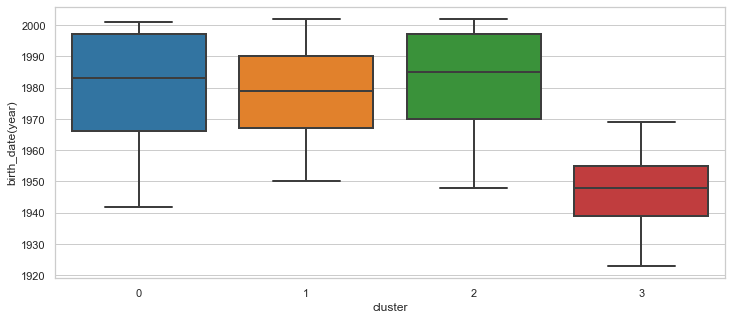

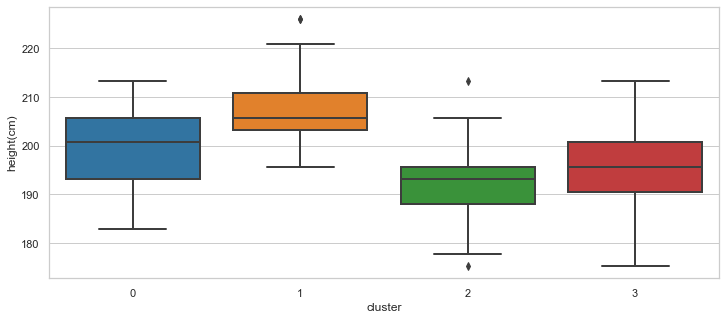

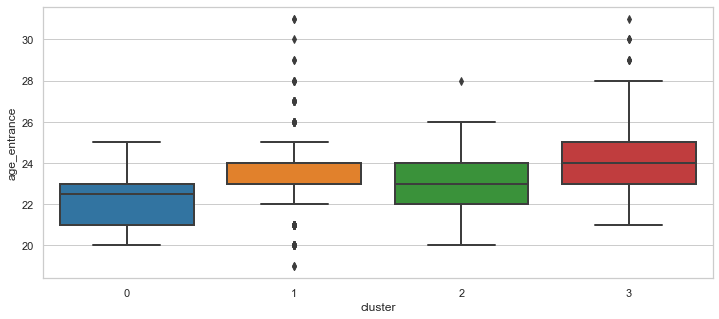

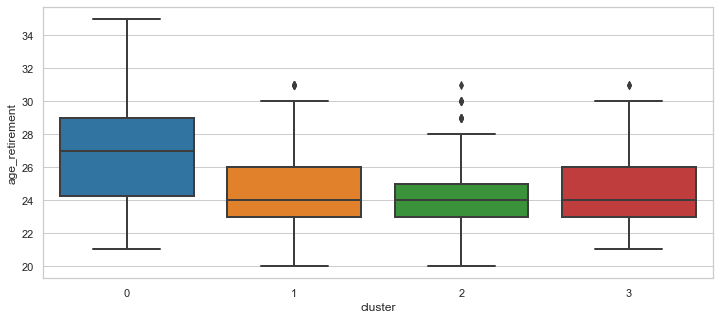

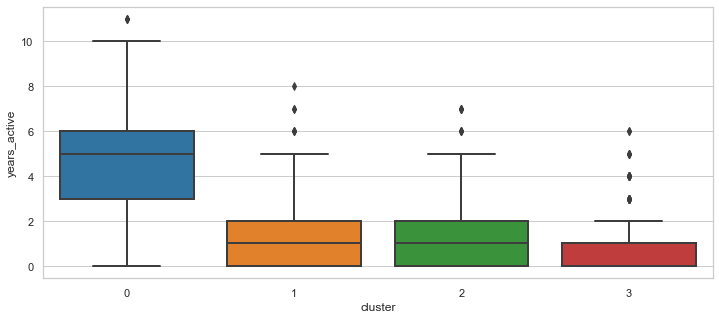

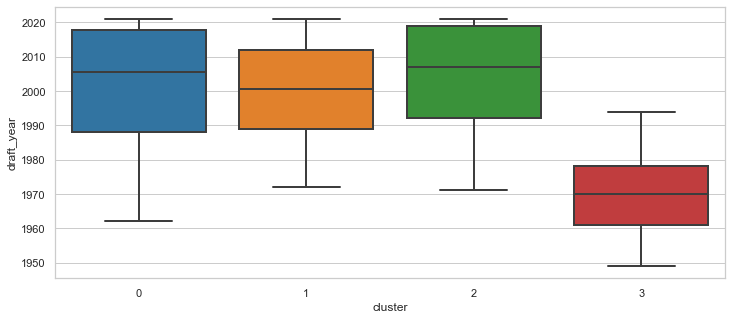

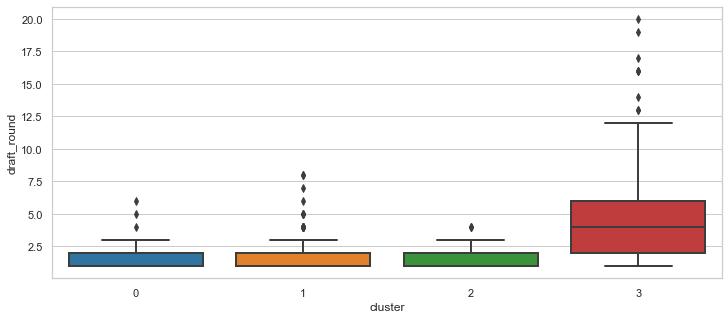

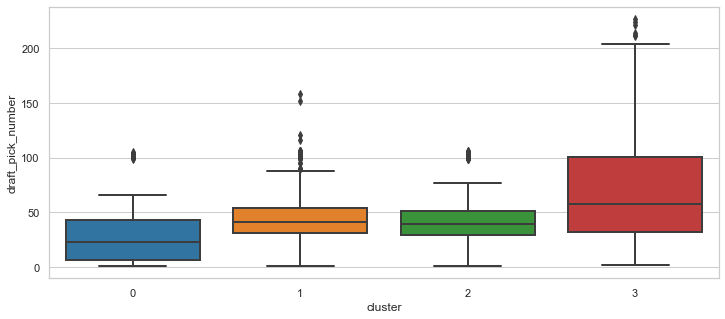

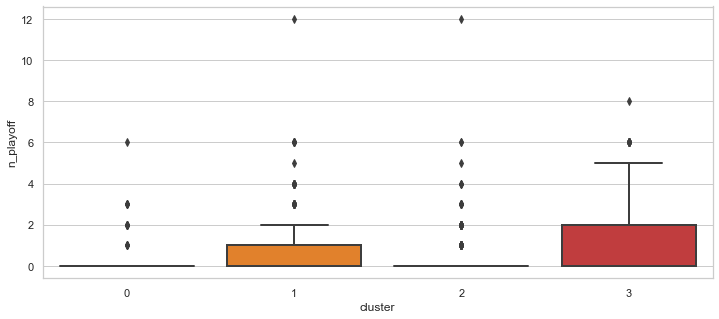

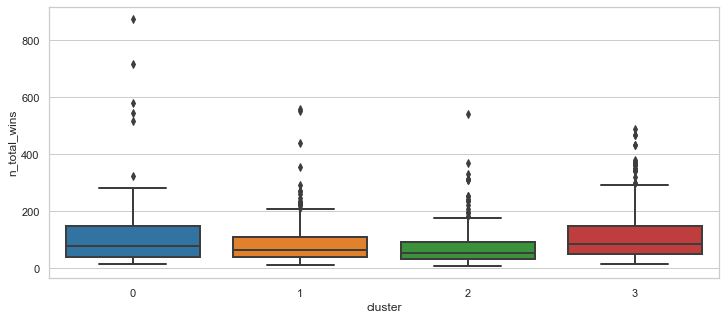

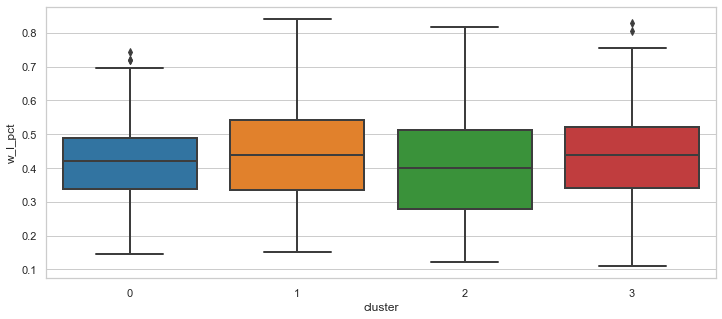

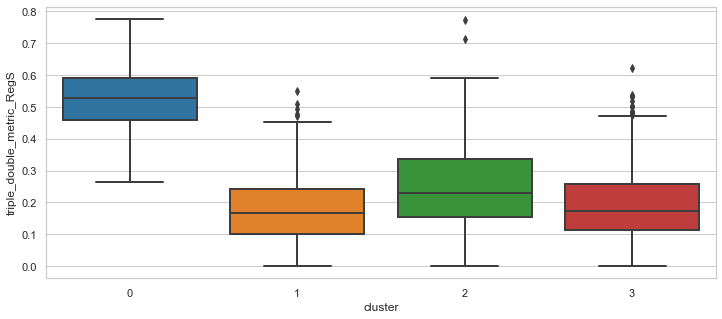

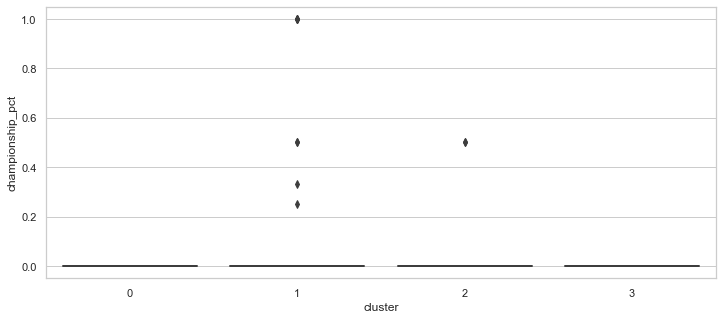

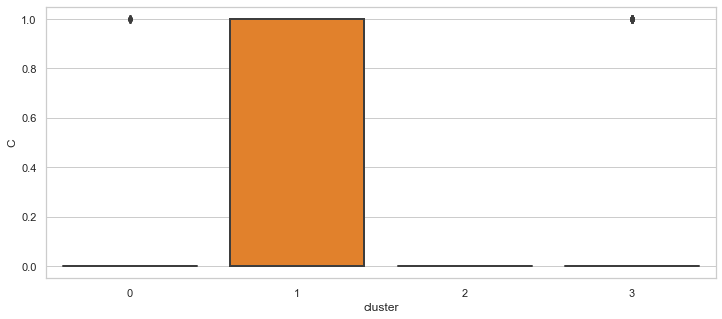

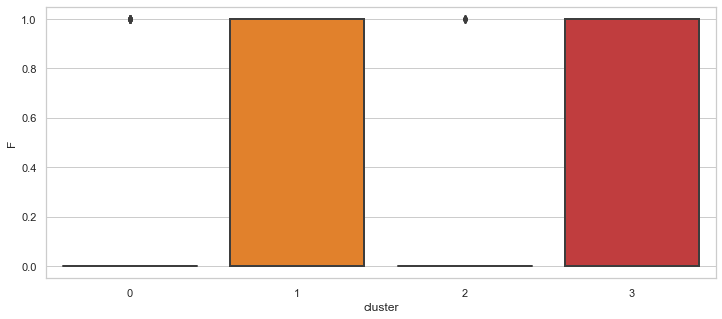

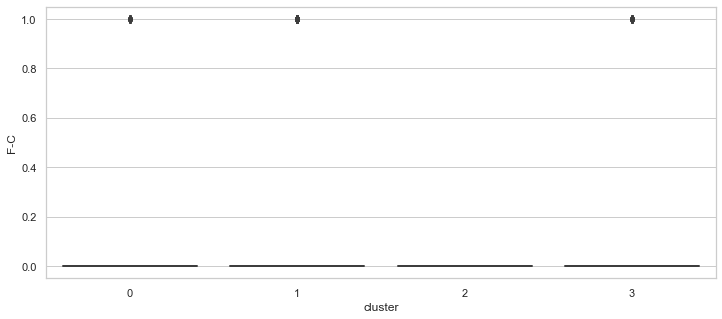

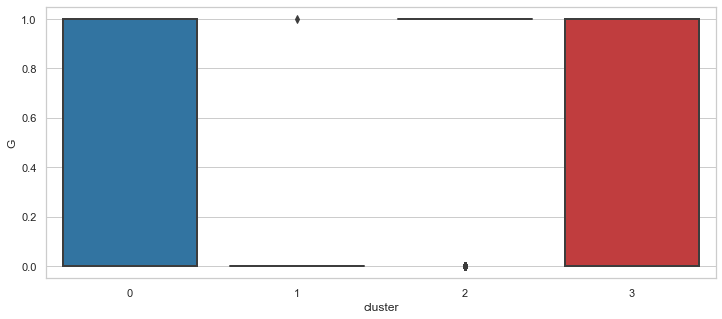

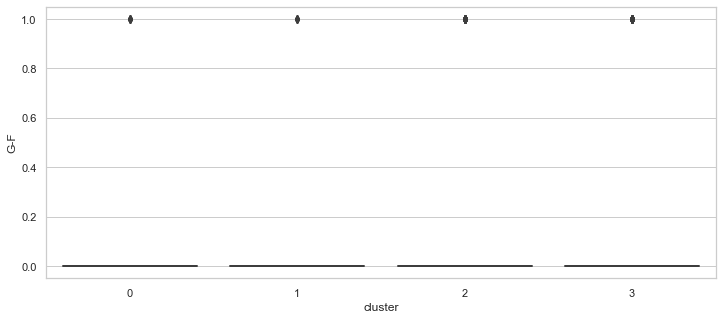

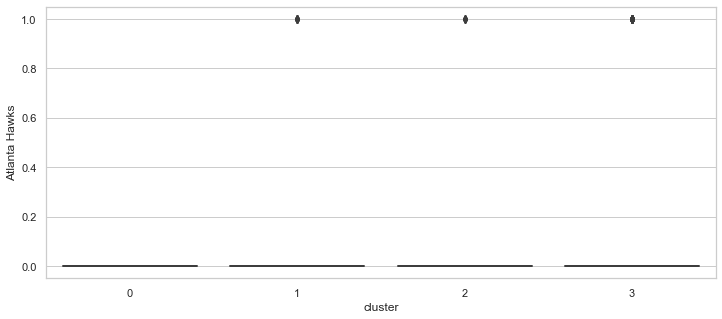

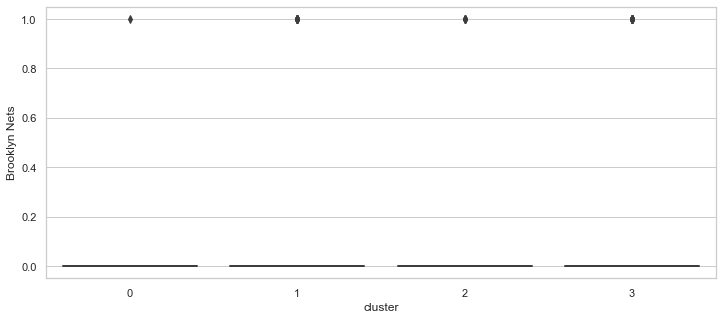

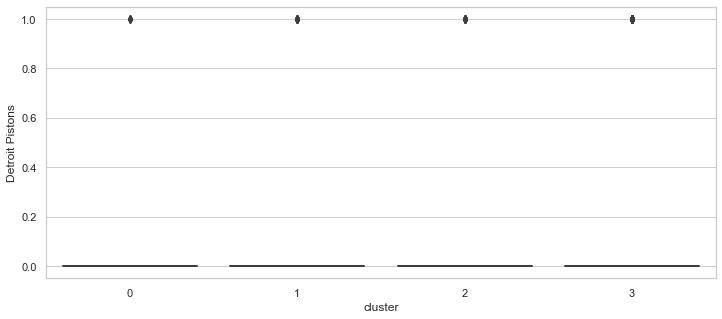

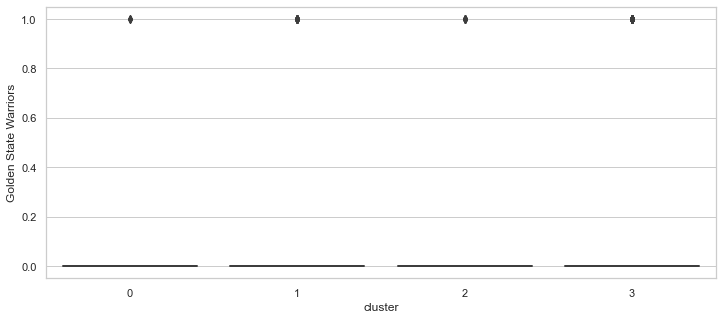

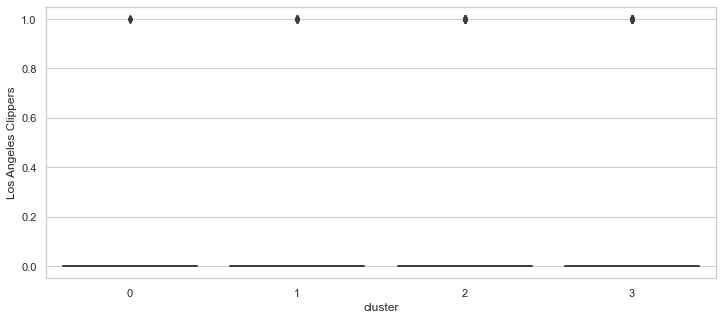

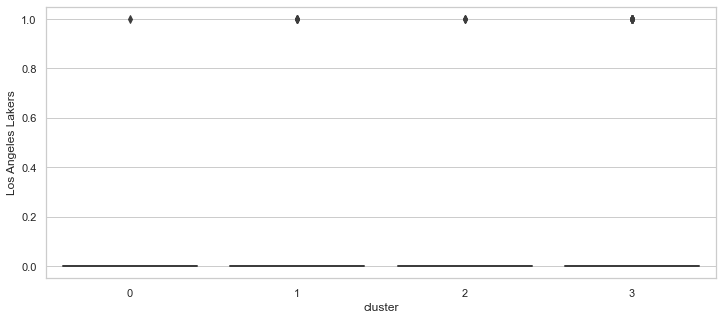

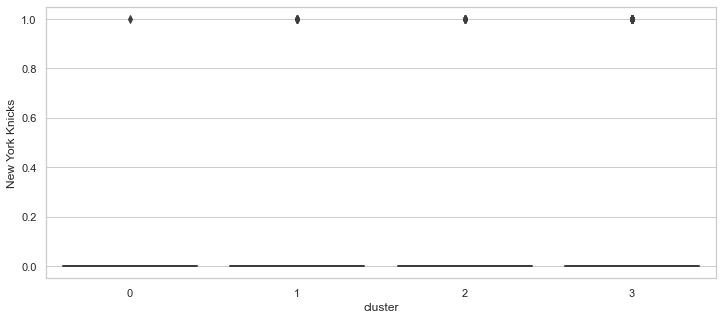

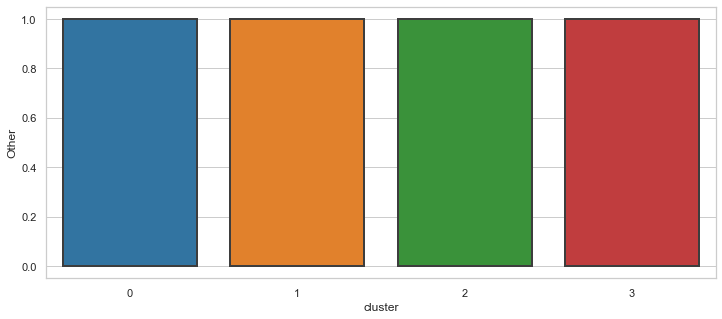

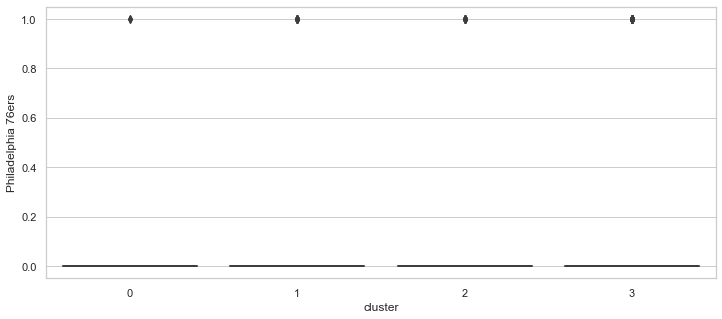

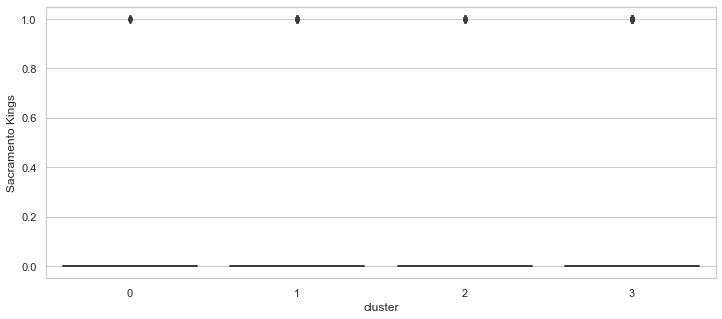

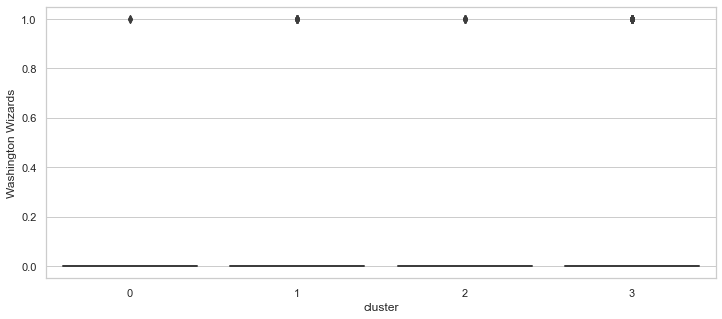

In [36]:
#Quick results study
for col in attributes:
    sns.boxplot(x="cluster", y=col, data=df_golden_record_no_playoff_clustered)
    plt.show()

### 4.3.1 Deep dive to k-mean clustering

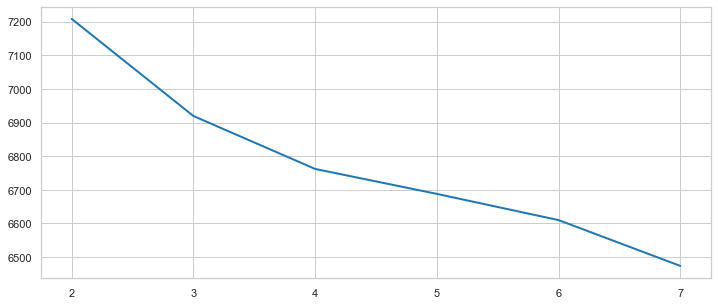

In [37]:
d=[]
for K in range(2,8):
    clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
    clf.fit(datanorm_no_playoff)
    y_pred = clf.predict(datanorm_no_playoff)
    p=[]
    for i in range(K):
        p.append(np.sum(distance.cdist(datanorm_no_playoff[y_pred==i,:],[clf.cluster_centers_[i]],'euclidean')))
    d.append(np.sum(p))
plt.plot(np.arange(2,8),d)

In [38]:
inrt=np.zeros(12)
sil_kmeans_r=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        clf = cluster.KMeans(init='random', n_clusters=i*1+2, random_state=0)
        clf.fit(datanorm_no_playoff)
        inrt[i]=clf.inertia_
        sil_kmeans_r[i]=metrics.silhouette_score(datanorm_no_playoff, clf.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_no_playoff[(clf.labels_==i)])) + ' players')

k: 2
Cluster 0 has 909 players
Cluster 1 has 217 players
k: 3
Cluster 0 has 490 players
Cluster 1 has 505 players
Cluster 2 has 131 players
k: 4
Cluster 0 has 399 players
Cluster 1 has 83 players
Cluster 2 has 371 players
Cluster 3 has 273 players
k: 5
Cluster 0 has 120 players
Cluster 1 has 31 players
Cluster 2 has 398 players
Cluster 3 has 374 players
Cluster 4 has 203 players
k: 6
Cluster 0 has 167 players
Cluster 1 has 118 players
Cluster 2 has 344 players
Cluster 3 has 39 players
Cluster 4 has 159 players
Cluster 5 has 299 players
k: 7
Cluster 0 has 269 players
Cluster 1 has 98 players
Cluster 2 has 316 players
Cluster 3 has 31 players
Cluster 4 has 133 players
Cluster 5 has 214 players
Cluster 6 has 65 players
k: 8
Cluster 0 has 195 players
Cluster 1 has 43 players
Cluster 2 has 84 players
Cluster 3 has 124 players
Cluster 4 has 31 players
Cluster 5 has 298 players
Cluster 6 has 260 players
Cluster 7 has 91 players
k: 9
Cluster 0 has 185 players
Cluster 1 has 44 players
Cluster 2

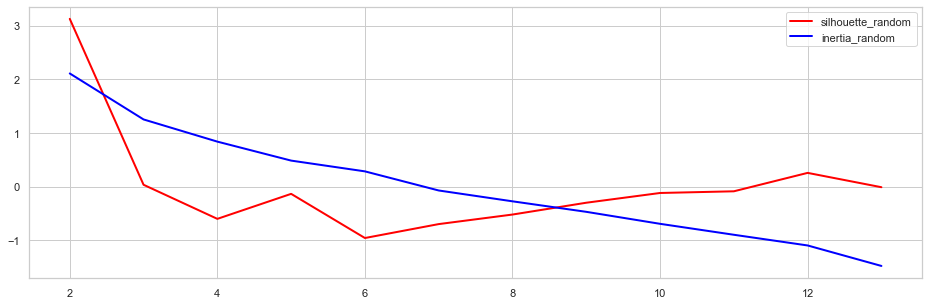

In [39]:
plt.plot(np.arange(12)*1+2,scaler.fit_transform(sil_kmeans_r.reshape(-1, 1)),'r', label='silhouette_random')
plt.plot(np.arange(12)*1+2,scaler.fit_transform(inrt.reshape(-1, 1)),'b', label='inertia_random')
plt.legend()
fig=plt.gcf()
fig.set_size_inches((16,5))

In [40]:
inrt=np.zeros(12)
sil_kmeans_plus=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        clf = cluster.KMeans(init='k-means++', n_clusters=i*1+2, random_state=0)
        clf.fit(datanorm_no_playoff)
        inrt[i]=clf.inertia_
        sil_kmeans_plus[i]=metrics.silhouette_score(datanorm_no_playoff, clf.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_no_playoff[(clf.labels_==i)])) + ' players')

k: 2
Cluster 0 has 206 players
Cluster 1 has 920 players
k: 3
Cluster 0 has 505 players
Cluster 1 has 520 players
Cluster 2 has 101 players
k: 4
Cluster 0 has 86 players
Cluster 1 has 370 players
Cluster 2 has 261 players
Cluster 3 has 409 players
k: 5
Cluster 0 has 256 players
Cluster 1 has 408 players
Cluster 2 has 395 players
Cluster 3 has 53 players
Cluster 4 has 14 players
k: 6
Cluster 0 has 258 players
Cluster 1 has 314 players
Cluster 2 has 149 players
Cluster 3 has 305 players
Cluster 4 has 86 players
Cluster 5 has 14 players
k: 7
Cluster 0 has 68 players
Cluster 1 has 332 players
Cluster 2 has 225 players
Cluster 3 has 281 players
Cluster 4 has 53 players
Cluster 5 has 3 players
Cluster 6 has 164 players
k: 8
Cluster 0 has 14 players
Cluster 1 has 204 players
Cluster 2 has 267 players
Cluster 3 has 289 players
Cluster 4 has 30 players
Cluster 5 has 109 players
Cluster 6 has 157 players
Cluster 7 has 56 players
k: 9
Cluster 0 has 55 players
Cluster 1 has 258 players
Cluster 2 h

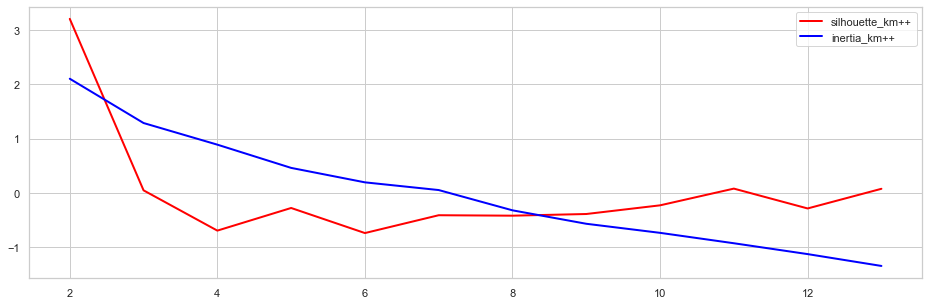

In [41]:
warnings.filterwarnings("ignore")

plt.plot(np.arange(12)*1+2,scaler.fit_transform(sil_kmeans_plus.reshape(-1, 1)),'r', label='silhouette_km++')
plt.plot(np.arange(12)*1+2,scaler.fit_transform(inrt.reshape(-1, 1)),'b', label='inertia_km++')
plt.legend()
fig=plt.gcf()
fig.set_size_inches((16,5))

It looks like 3 is going to be the best fit. But first, let's study other clustering techniques...

### 4.3.2 Other clustering techniques

Let's start with hierarhical clustering

In [42]:
sil_single=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        single = cluster.AgglomerativeClustering(linkage="single",n_clusters=1*i+2,connectivity=None)
        single.fit(datanorm_no_playoff)
        sil_single[i]=metrics.silhouette_score(datanorm_no_playoff, single.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_no_playoff[(single.labels_==i)])) + ' players')

k: 2
Cluster 0 has 1125 players
Cluster 1 has 1 players
k: 3
Cluster 0 has 1122 players
Cluster 1 has 1 players
Cluster 2 has 3 players
k: 4
Cluster 0 has 1120 players
Cluster 1 has 2 players
Cluster 2 has 3 players
Cluster 3 has 1 players
k: 5
Cluster 0 has 2 players
Cluster 1 has 1119 players
Cluster 2 has 3 players
Cluster 3 has 1 players
Cluster 4 has 1 players
k: 6
Cluster 0 has 1119 players
Cluster 1 has 1 players
Cluster 2 has 3 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
k: 7
Cluster 0 has 1105 players
Cluster 1 has 1 players
Cluster 2 has 3 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 14 players
k: 8
Cluster 0 has 3 players
Cluster 1 has 1104 players
Cluster 2 has 14 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 1 players
Cluster 7 has 1 players
k: 9
Cluster 0 has 1104 players
Cluster 1 has 2 players
Cluster 2 has 14 players
Cluster 3 has 1 playe

In [43]:
sil_single_con=np.zeros(12)
connectivity = kneighbors_graph(datanorm_no_playoff, n_neighbors=5)
for i in range(12):
        print('k:',1*i+2)
        single = cluster.AgglomerativeClustering(linkage="single",n_clusters=1*i+2,connectivity=connectivity)
        single.fit(datanorm_no_playoff)
        sil_single_con[i]=metrics.silhouette_score(datanorm_no_playoff, single.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_no_playoff[(single.labels_==i)])) + ' players')

k: 2
Cluster 0 has 1125 players
Cluster 1 has 1 players
k: 3
Cluster 0 has 1122 players
Cluster 1 has 1 players
Cluster 2 has 3 players
k: 4
Cluster 0 has 1120 players
Cluster 1 has 2 players
Cluster 2 has 3 players
Cluster 3 has 1 players
k: 5
Cluster 0 has 2 players
Cluster 1 has 1119 players
Cluster 2 has 3 players
Cluster 3 has 1 players
Cluster 4 has 1 players
k: 6
Cluster 0 has 1119 players
Cluster 1 has 1 players
Cluster 2 has 3 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
k: 7
Cluster 0 has 1105 players
Cluster 1 has 1 players
Cluster 2 has 3 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 14 players
k: 8
Cluster 0 has 3 players
Cluster 1 has 1104 players
Cluster 2 has 14 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 1 players
Cluster 7 has 1 players
k: 9
Cluster 0 has 1104 players
Cluster 1 has 2 players
Cluster 2 has 14 players
Cluster 3 has 1 playe

In [44]:
sil_ward_con=np.zeros(12)
connectivity = kneighbors_graph(datanorm_no_playoff, n_neighbors=5)
for i in range(12):
        print('k:',1*i+2)
        single = cluster.AgglomerativeClustering(linkage="ward",n_clusters=1*i+2,connectivity=connectivity)
        single.fit(datanorm_no_playoff)
        sil_ward_con[i]=metrics.silhouette_score(datanorm_no_playoff, single.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_no_playoff[(single.labels_==i)])) + ' players')

k: 2
Cluster 0 has 1028 players
Cluster 1 has 98 players
k: 3
Cluster 0 has 1014 players
Cluster 1 has 98 players
Cluster 2 has 14 players
k: 4
Cluster 0 has 98 players
Cluster 1 has 359 players
Cluster 2 has 14 players
Cluster 3 has 655 players
k: 5
Cluster 0 has 359 players
Cluster 1 has 655 players
Cluster 2 has 14 players
Cluster 3 has 95 players
Cluster 4 has 3 players
k: 6
Cluster 0 has 655 players
Cluster 1 has 304 players
Cluster 2 has 14 players
Cluster 3 has 95 players
Cluster 4 has 3 players
Cluster 5 has 55 players
k: 7
Cluster 0 has 289 players
Cluster 1 has 304 players
Cluster 2 has 366 players
Cluster 3 has 95 players
Cluster 4 has 3 players
Cluster 5 has 55 players
Cluster 6 has 14 players
k: 8
Cluster 0 has 239 players
Cluster 1 has 304 players
Cluster 2 has 366 players
Cluster 3 has 95 players
Cluster 4 has 3 players
Cluster 5 has 55 players
Cluster 6 has 14 players
Cluster 7 has 50 players
k: 9
Cluster 0 has 141 players
Cluster 1 has 98 players
Cluster 2 has 366 play

Let's try spectral clustering

In [45]:
sil_spectral=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        spectral = cluster.SpectralClustering(n_clusters=i*1+2,  affinity="nearest_neighbors",  eigen_solver='arpack')
        spectral.fit(datanorm_no_playoff)
        sil_spectral[i]=metrics.silhouette_score(datanorm_no_playoff, spectral.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_no_playoff[(spectral.labels_==i)])) + ' players')

k: 2
Cluster 0 has 1073 players
Cluster 1 has 53 players
k: 3
Cluster 0 has 1031 players
Cluster 1 has 42 players
Cluster 2 has 53 players
k: 4
Cluster 0 has 982 players
Cluster 1 has 53 players
Cluster 2 has 42 players
Cluster 3 has 49 players
k: 5
Cluster 0 has 58 players
Cluster 1 has 924 players
Cluster 2 has 42 players
Cluster 3 has 53 players
Cluster 4 has 49 players
k: 6
Cluster 0 has 903 players
Cluster 1 has 53 players
Cluster 2 has 42 players
Cluster 3 has 49 players
Cluster 4 has 57 players
Cluster 5 has 22 players
k: 7
Cluster 0 has 57 players
Cluster 1 has 848 players
Cluster 2 has 42 players
Cluster 3 has 21 players
Cluster 4 has 49 players
Cluster 5 has 53 players
Cluster 6 has 56 players
k: 8
Cluster 0 has 707 players
Cluster 1 has 53 players
Cluster 2 has 42 players
Cluster 3 has 56 players
Cluster 4 has 50 players
Cluster 5 has 21 players
Cluster 6 has 140 players
Cluster 7 has 57 players
k: 9
Cluster 0 has 56 players
Cluster 1 has 702 players
Cluster 2 has 21 players

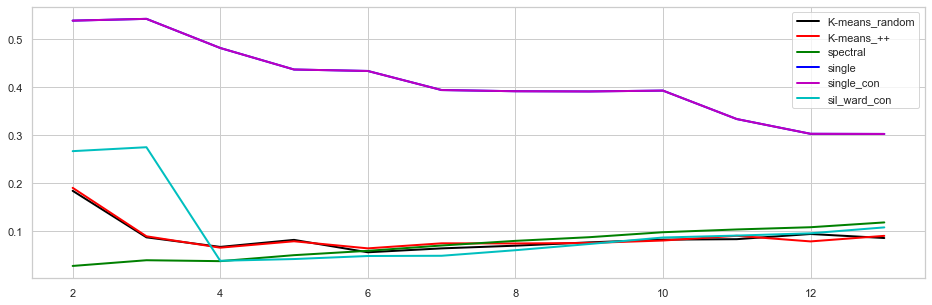

In [46]:
plt.plot(np.arange(12)*1+2,sil_kmeans_r.reshape(-1, 1),'black', label='K-means_random')
plt.plot(np.arange(12)*1+2,sil_kmeans_plus.reshape(-1, 1),'r', label='K-means_++')
plt.plot(np.arange(12)*1+2,sil_spectral.reshape(-1, 1),'g', label='spectral')
plt.plot(np.arange(12)*1+2,sil_single.reshape(-1, 1),'b', label='single')
plt.plot(np.arange(12)*1+2,sil_single_con.reshape(-1, 1),'m', label='single_con')
plt.plot(np.arange(12)*1+2,sil_ward_con.reshape(-1, 1),'c', label='sil_ward_con')


plt.legend()
fig=plt.gcf()
fig.set_size_inches((16,5))

In [47]:
#Nos quedamos con k-means

#### PCA study

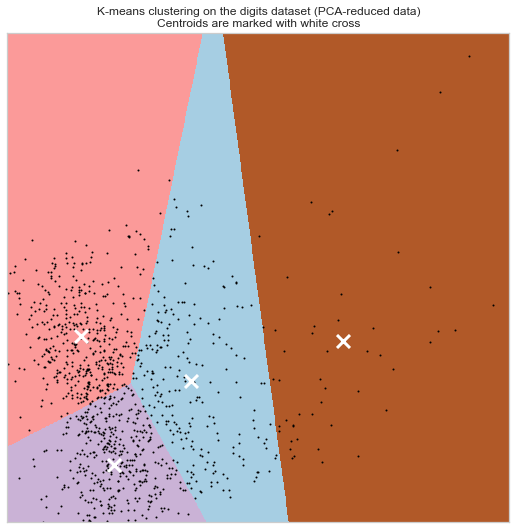

In [48]:
###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(datanorm_no_playoff)
kmeans = cluster.KMeans(init='k-means++', n_clusters=4, n_init=10)
kmeans.fit(reduced_data)

                    # Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02             # point in the mesh [x_min, m_max]x[y_min, y_max].

        # Plot the decision boundary. For that, we will assign a color to each point
x_min, x_max = reduced_data[:, 0].min() + 1, reduced_data[:, 0].max() - 1
y_min, y_max = reduced_data[:, 1].min() + 1, reduced_data[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
Z = Z.reshape(xx.shape)

#visualize
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       cmap=plt.cm.Paired,aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

fig = plt.gcf()
fig.set_size_inches((9,9))

In [49]:
#ens quedem amb k-means = 3

## 4. 4 Clustering playoff players

Now, with the Playoff dataset

In [50]:
numeric_cols = ['games_started_RegS', 'field_goals_attempts_pg_RegS',
       'field_goals_percent_pg_RegS', '_3pts_goals_attempts_pg_RegS',
       'FT_goals_attempts_pg_RegS', 'FT_goals_percent_pg_RegS',
       'total_rebounds_pg_RegS', 'assists_pg_RegS', 'personal_foults_pg_RegS',
       'games_started_Playoff', 'field_goals_attempts_pg_Playoff',
       'field_goals_percent_pg_Playoff', '_3pts_goals_attempts_pg_Playoff',
       'FT_goals_attempts_pg_Playoff', 'FT_goals_percent_pg_Playoff',
       'total_rebounds_pg_Playoff', 'assists_pg_Playoff',
       'personal_foults_pg_Playoff', 'FT_goals_attempts_total_RegS',
       'assists_total_RegS', 'FT_goals_attempts_total_Playoff',
       'assists_total_Playoff', 'player_eff_rating_RegS',
       'true_shooting_eff_RegS', 'usage_percent_RegS', 'win_share_RegS',
       'player_eff_rating_Playoff', 'true_shooting_eff_Playoff',
       'usage_percent_Playoff', 'win_share_Playoff', 'Hall_Of_Fame',
       'n_NBA_Champ', 'n_All_Star', 'gone_to_college', 'n_teams',
       'Playoff_flag', 'active_from', 'active_to', 'weight',
       'birth_date(year)', 'height(cm)', 'age_entrance', 'age_retirement',
       'years_active', 'draft_year', 'draft_round', 'draft_pick_number',
       'n_playoff', 'n_total_wins', 'w_l_pct', 'triple_double_metric_RegS',
       'triple_double_metric_Playoff', 'championship_pct']

{'whiskers': [<matplotlib.lines.Line2D at 0x2a96a032970>,
 'caps': [<matplotlib.lines.Line2D at 0x2a96a032850>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a96a032ac0>],
 'medians': [<matplotlib.lines.Line2D at 0x2a9772e8f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a9772e87c0>],
 'means': []}

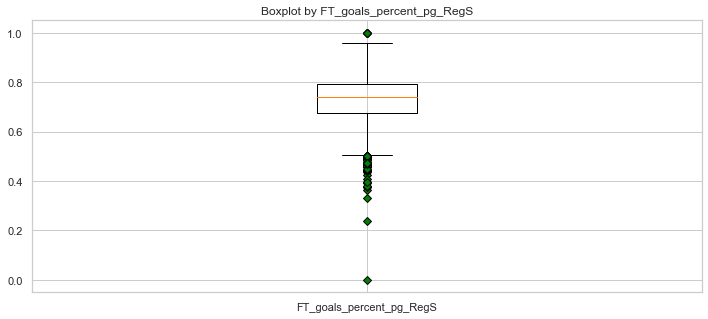

In [51]:
numeric_col_name = 'FT_goals_percent_pg_RegS'

subset = df_golden_record_playoff[[numeric_col_name]]
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()

ax.set_title('Boxplot by ' + numeric_col_name)
ax.boxplot(subset, flierprops=green_diamond,labels=[numeric_col_name])

In [52]:
scaler = StandardScaler() #Standardize features by removing the mean and scaling to unit variance
datanorm_playoff = scaler.fit_transform(df_golden_record_playoff.astype(float))

In [53]:
datanorm_playoff

array([[-0.67338649, -1.10632644, -0.18552324, ..., -0.2368281 ,
        -0.19991017,  4.88909253],
       [-0.6848215 , -0.98199838,  0.19596028, ..., -0.2368281 ,
        -0.19991017, -0.20453693],
       [-0.64289315, -1.25552011, -0.01212164, ..., -0.2368281 ,
        -0.19991017, -0.20453693],
       ...,
       [ 3.2755018 ,  3.84193018,  0.90690685, ..., -0.2368281 ,
        -0.19991017,  4.88909253],
       [-0.6848215 ,  2.47432157, -0.1161626 , ..., -0.2368281 ,
        -0.19991017, -0.20453693],
       [ 2.74949158,  3.56840846, -0.34158469, ..., -0.2368281 ,
        -0.19991017, -0.20453693]])

First kick study with k-means and K=4 (remember we wnat not more than 7-10 clusters in order to get clear qualitative profiles for the diff types of players)

In [54]:
K=4
clf = cluster.KMeans(n_clusters=K, random_state=0) #initialize the k-means clustering
clf.fit(datanorm_playoff) #run the k-means clustering

KMeans(n_clusters=4, random_state=0)

In [55]:
y_pred_playoff = clf.predict(datanorm_playoff) #Predict the closest cluster each sample in X belongs to.
print(y_pred_playoff)

[1 1 1 ... 3 0 3]


In [56]:
print('Clusters:[', len(datanorm_playoff[(clf.labels_==0)]),len(datanorm_playoff[(clf.labels_==1)]),
              len(datanorm_playoff[(clf.labels_==2)]),len(datanorm_playoff[(clf.labels_==3)]),']')

Clusters:[ 528 836 722 230 ]


In [57]:
df_golden_record_playoff_clustered = df_golden_record_playoff.copy()
df_golden_record_playoff_clustered['cluster'] = y_pred_playoff
df_golden_record_playoff_clustered.head()

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,Detroit Pistons,Golden State Warriors,Los Angeles Clippers,Los Angeles Lakers,New York Knicks,Other,Philadelphia 76ers,Sacramento Kings,Washington Wizards,cluster
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,0,0,0,0,0,0,0,0,1,1
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,0,0,0,0,0,0,0,0,0,1
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,0,1,0,0,0,0,0,0,0,1
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,0,0,0,0,0,1,0,0,0,1
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,0,0,0,0,0,1,0,0,0,1


In [58]:
attributes = df_golden_record_playoff.columns.tolist()

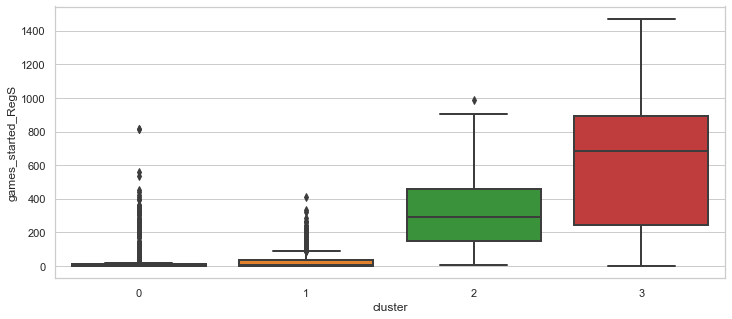

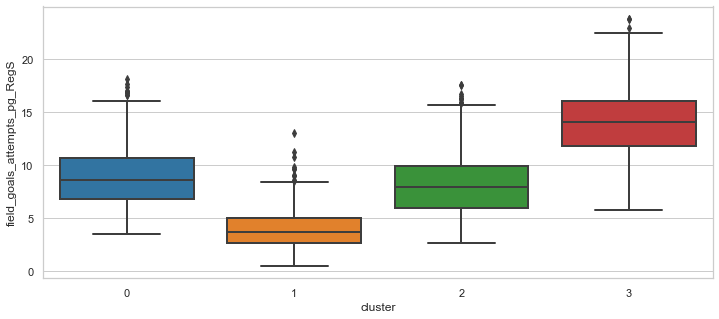

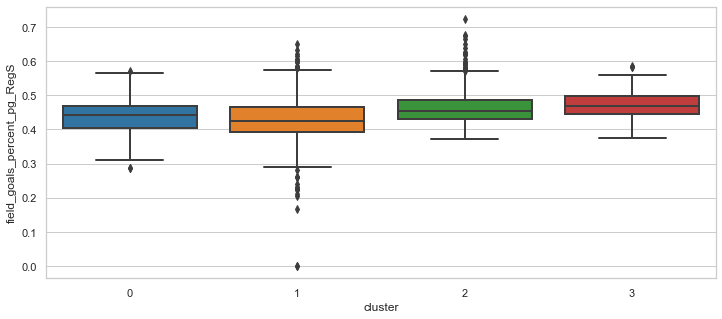

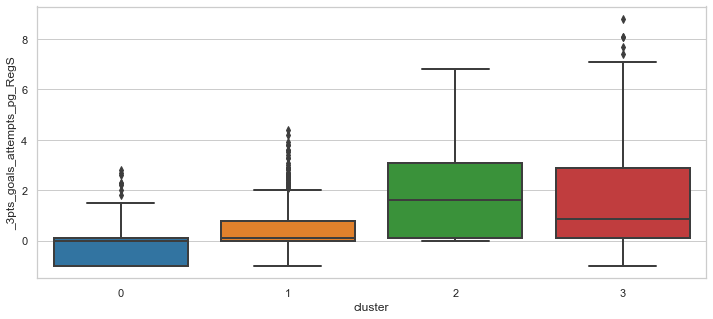

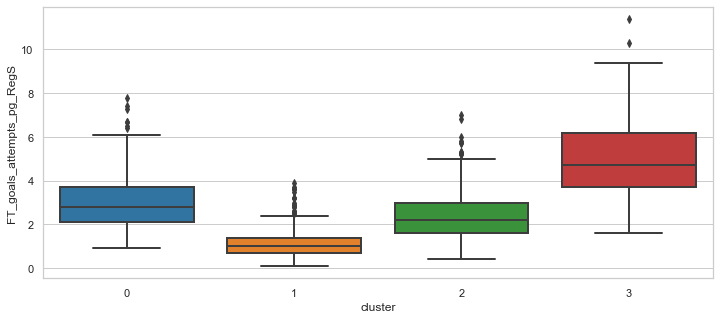

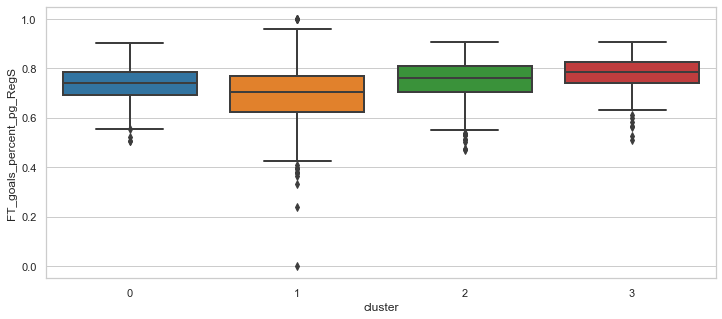

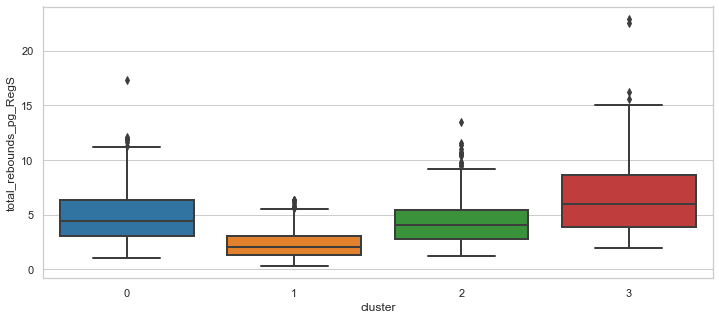

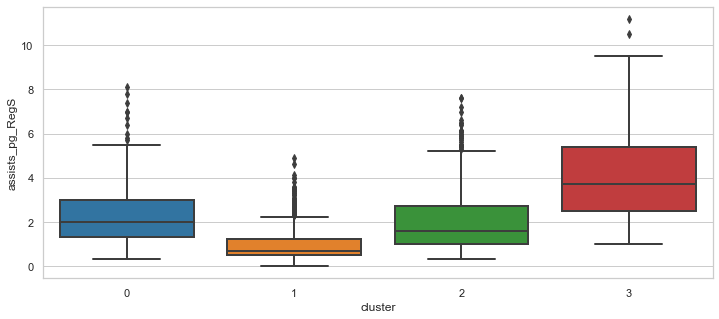

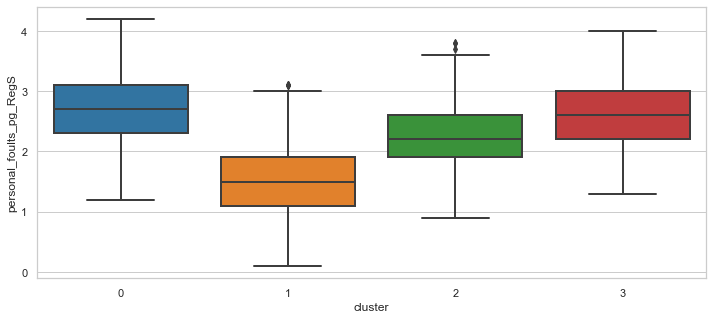

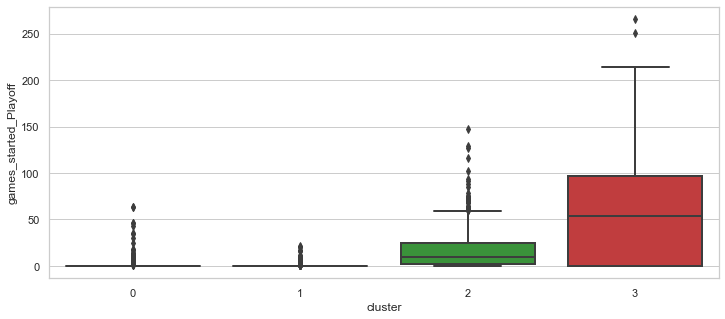

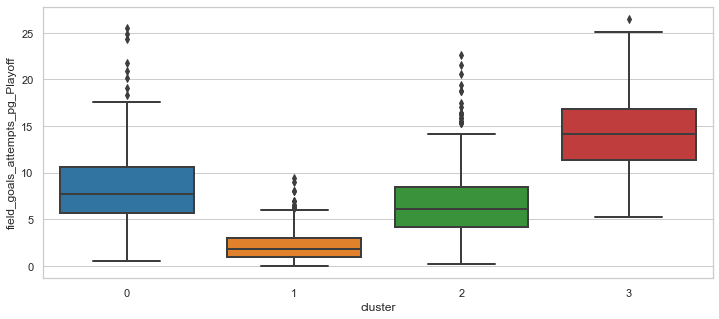

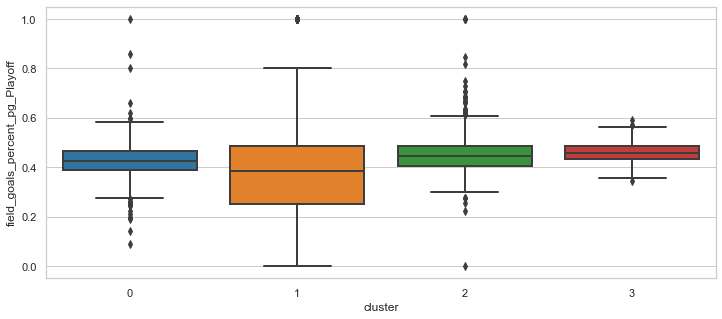

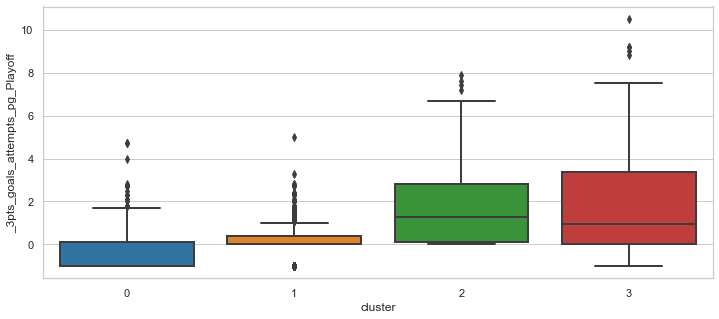

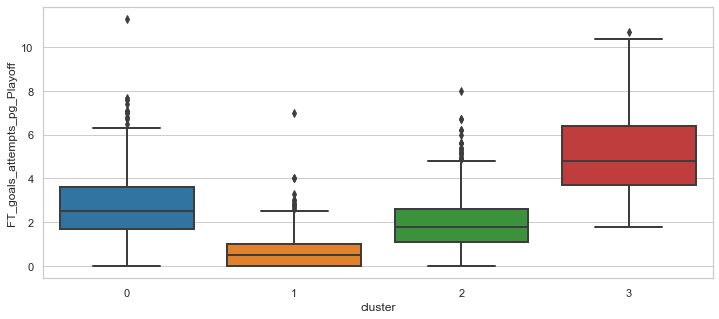

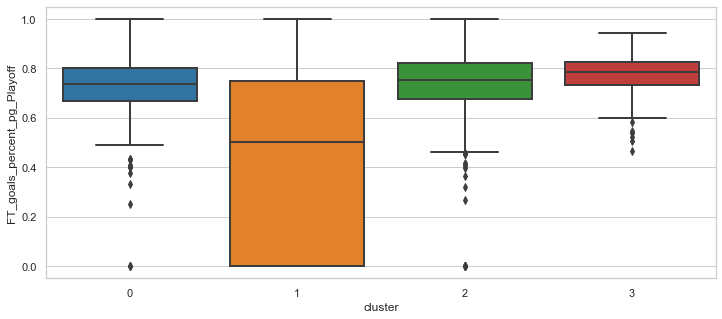

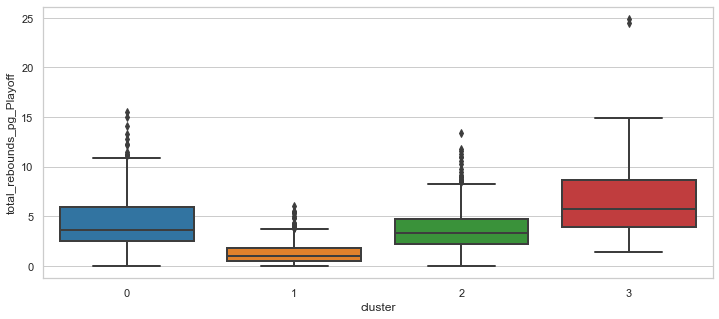

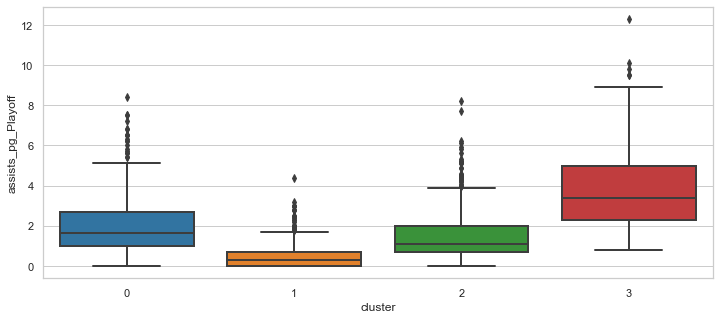

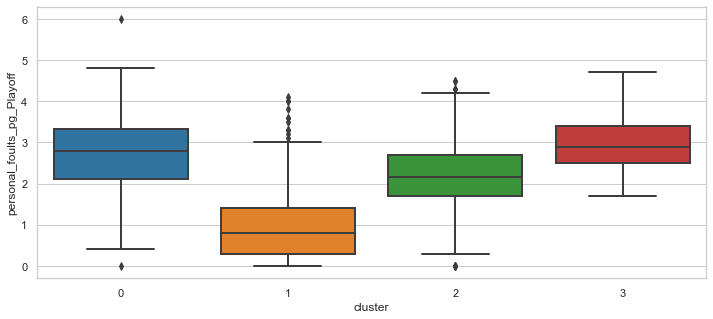

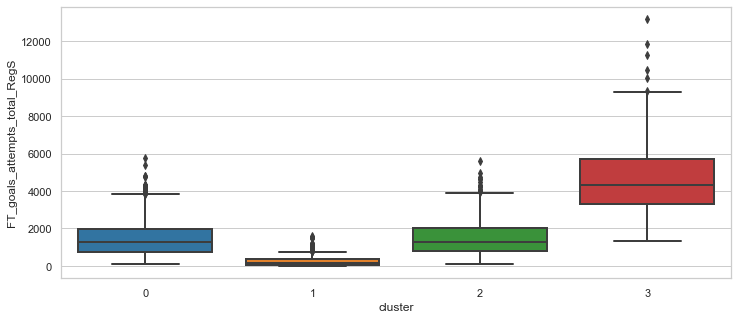

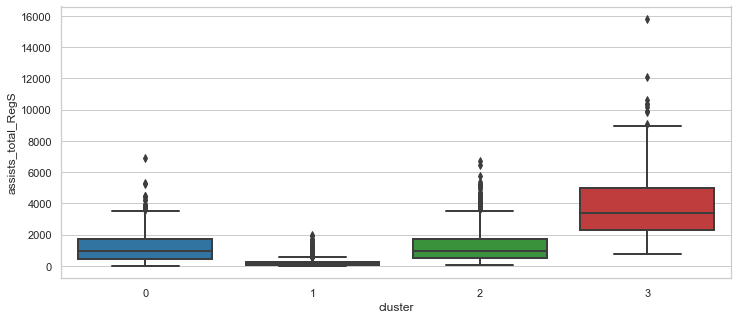

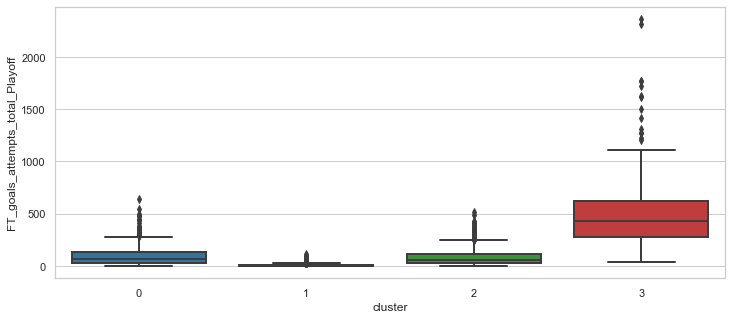

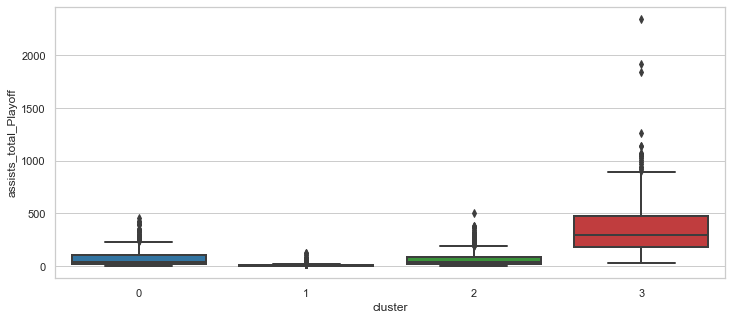

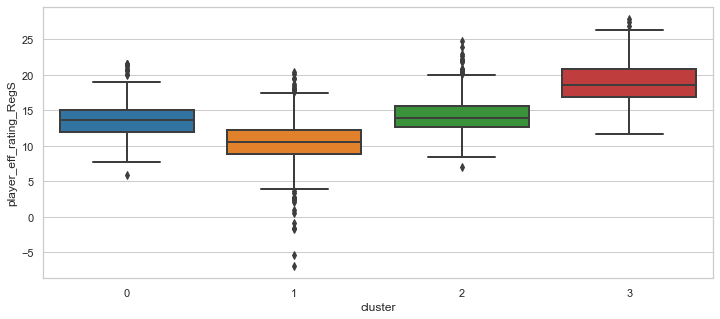

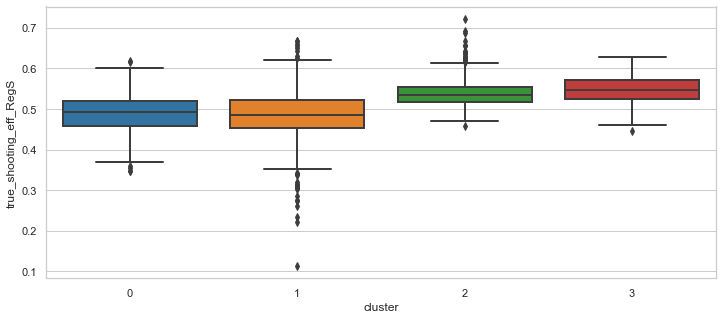

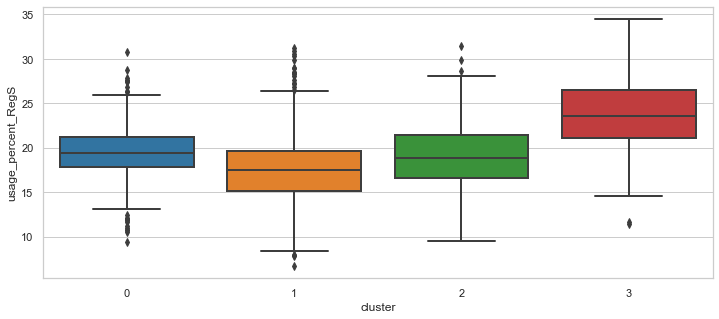

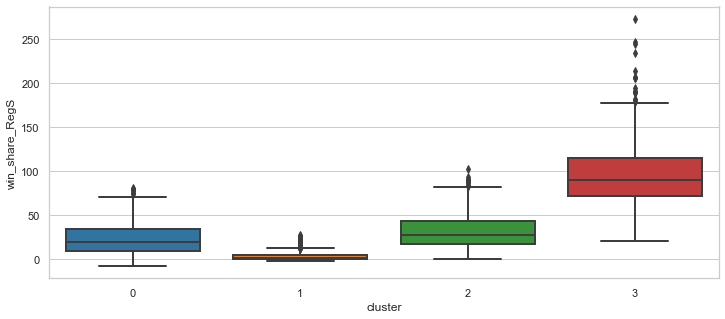

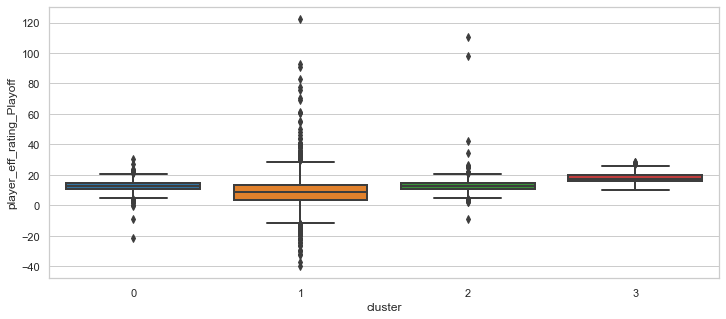

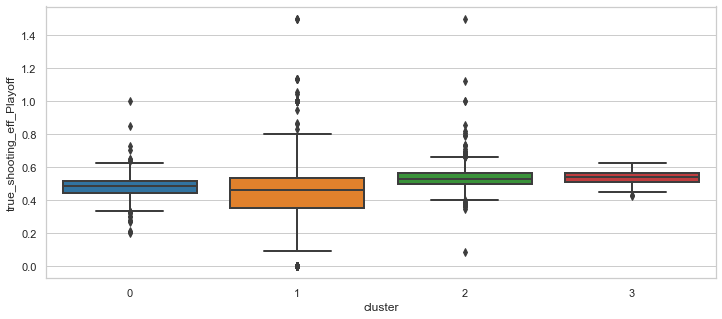

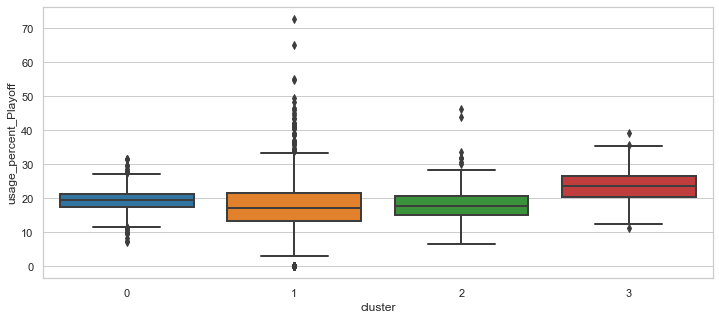

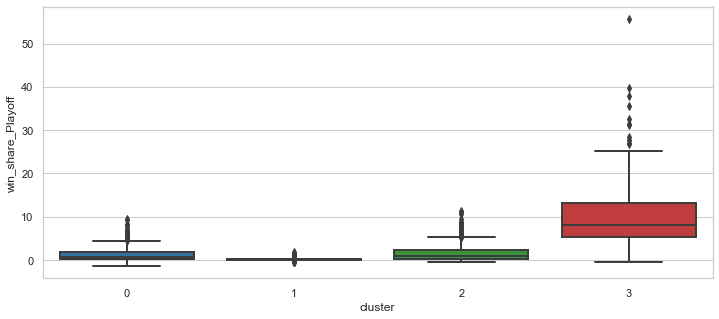

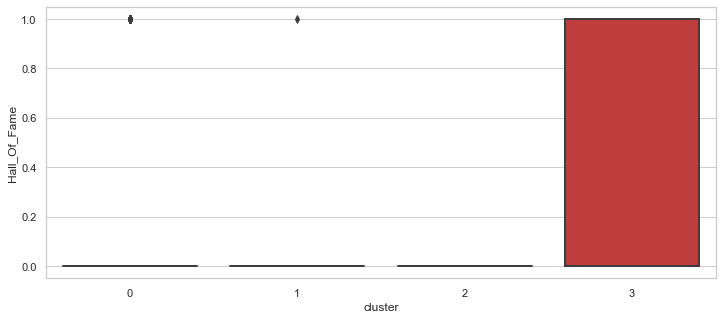

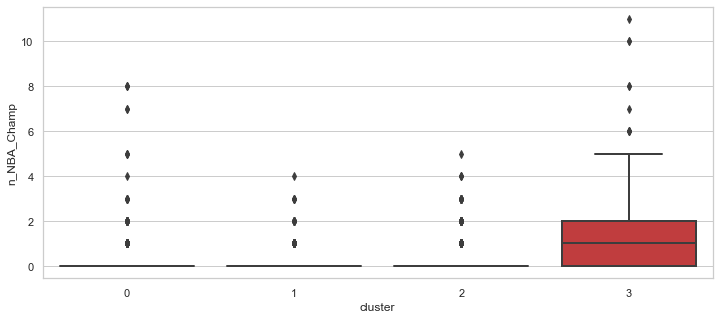

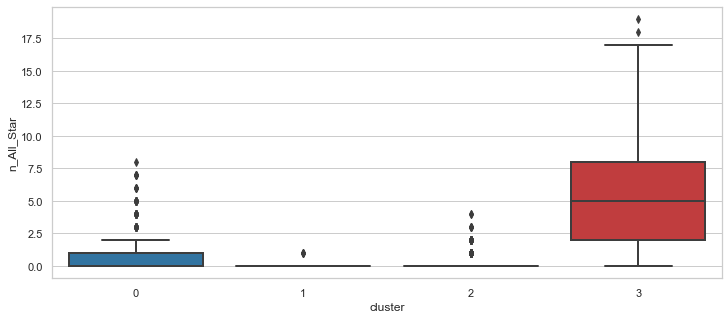

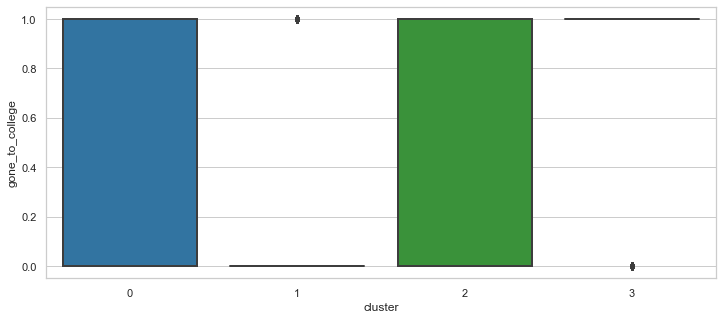

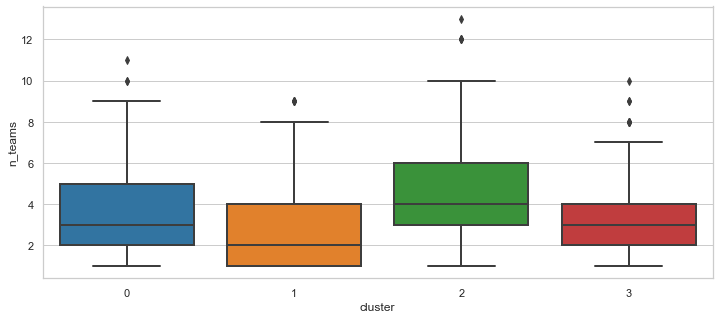

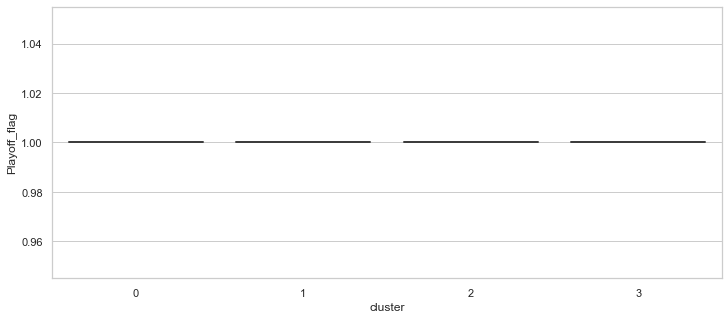

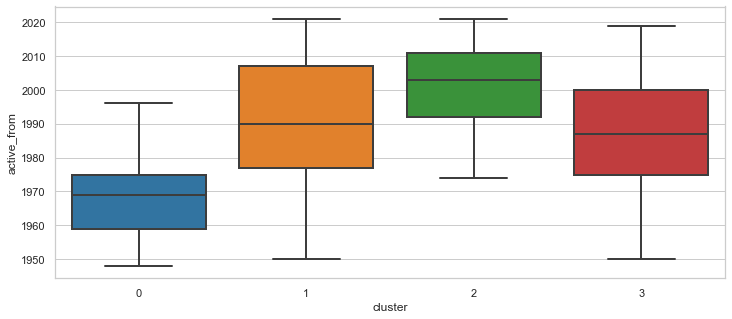

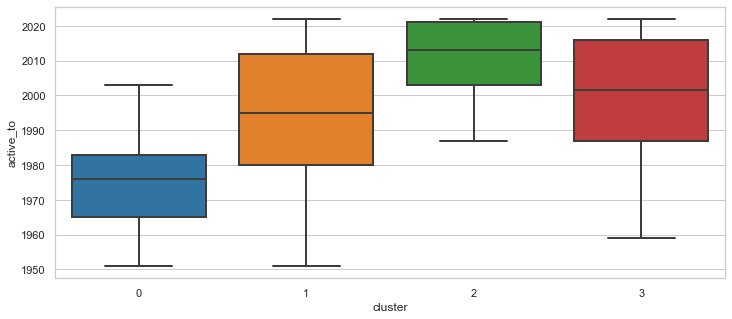

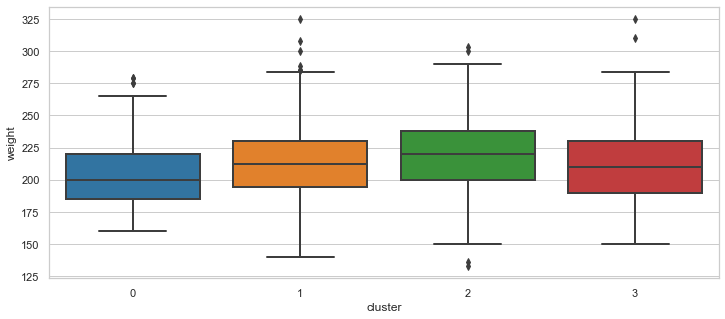

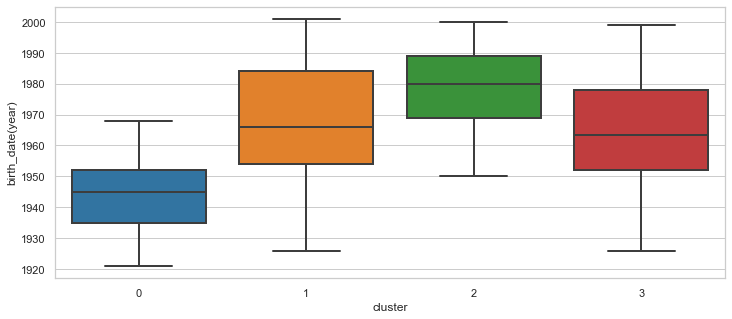

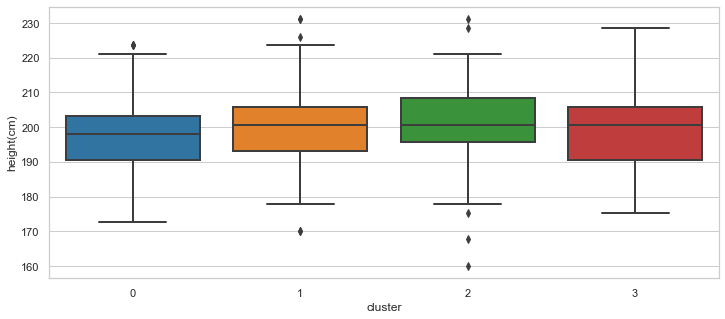

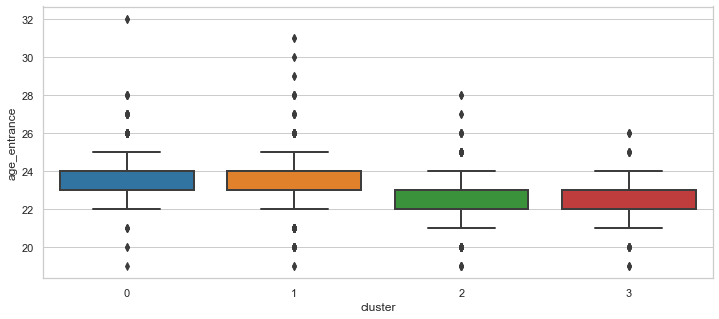

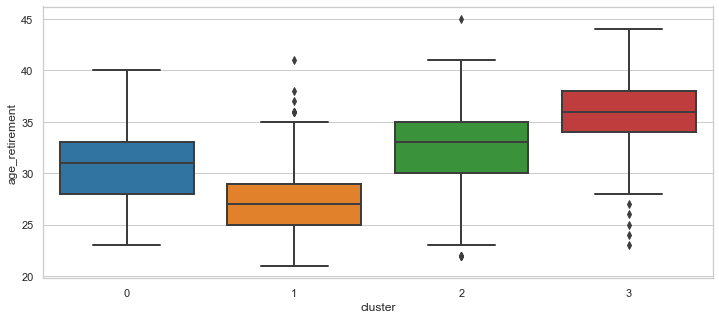

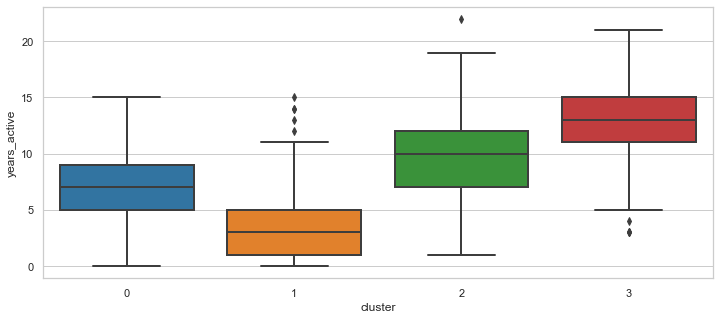

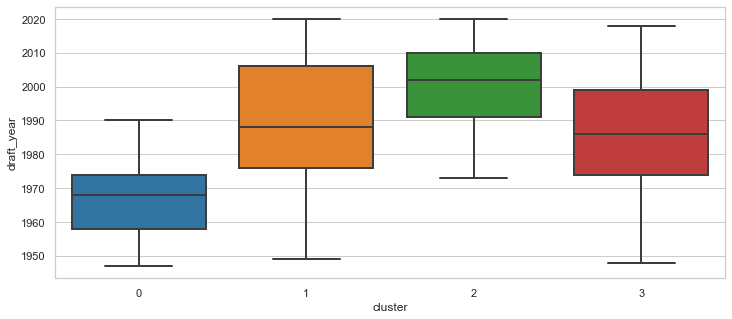

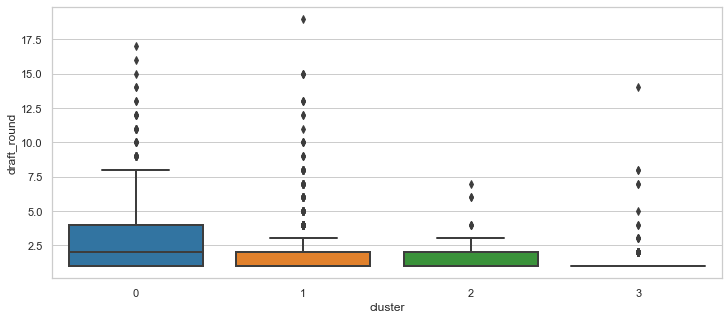

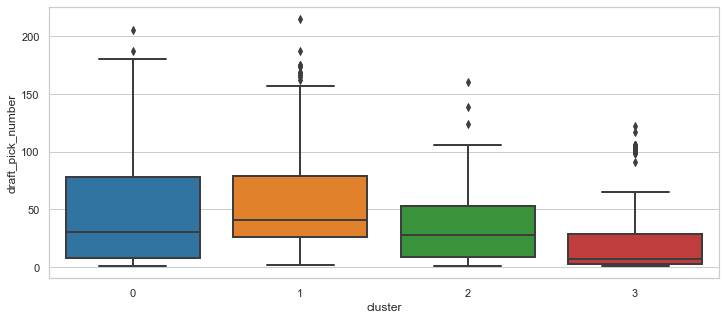

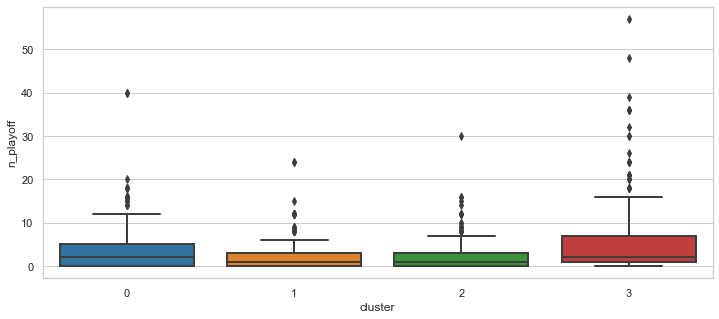

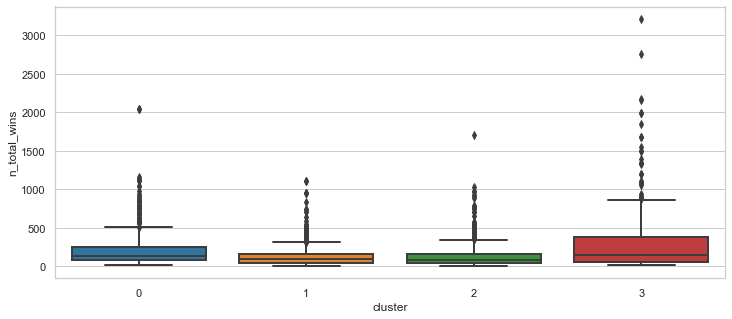

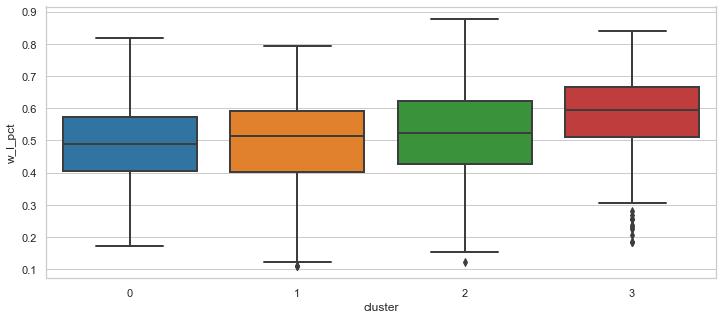

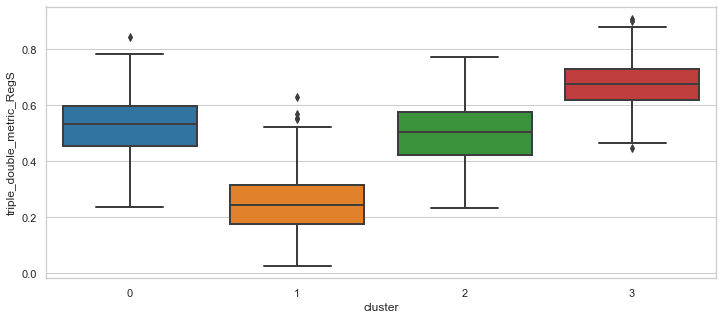

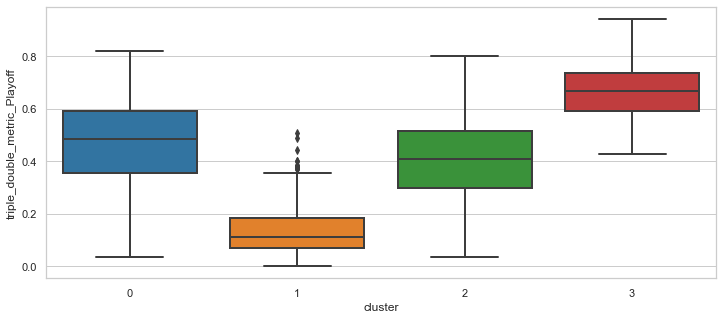

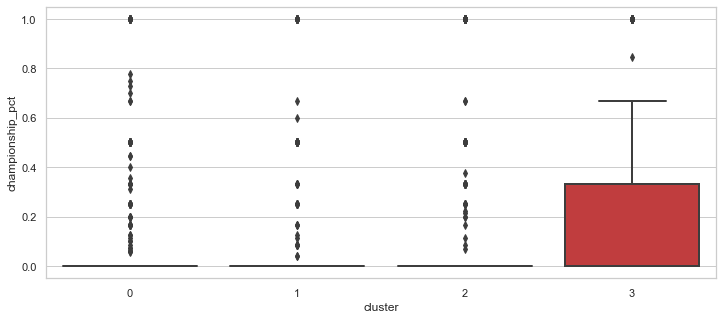

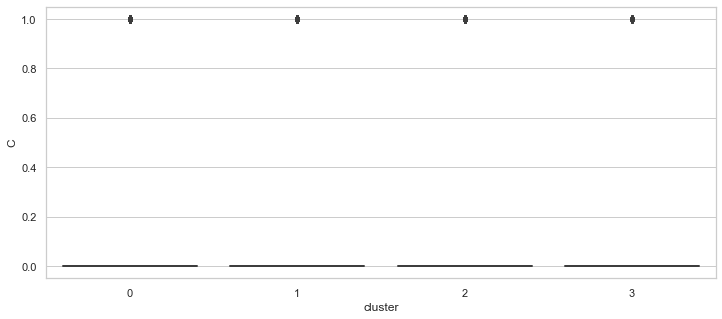

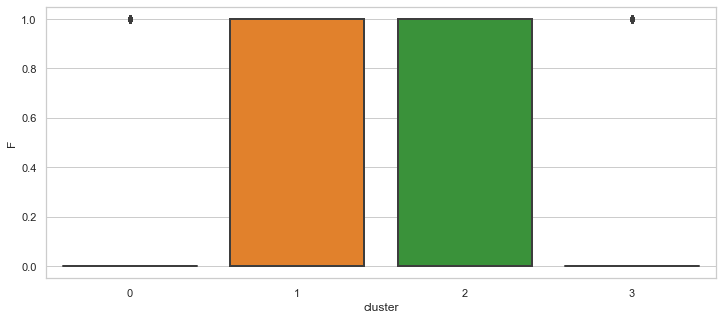

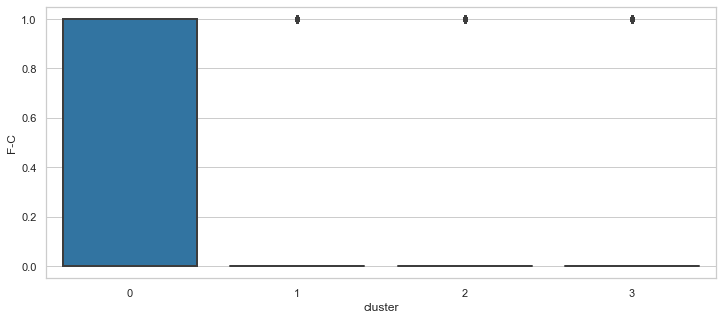

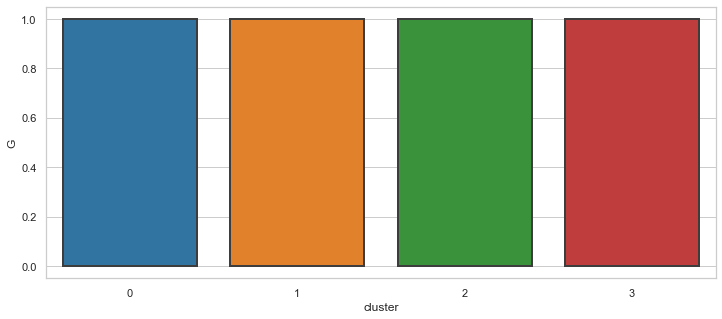

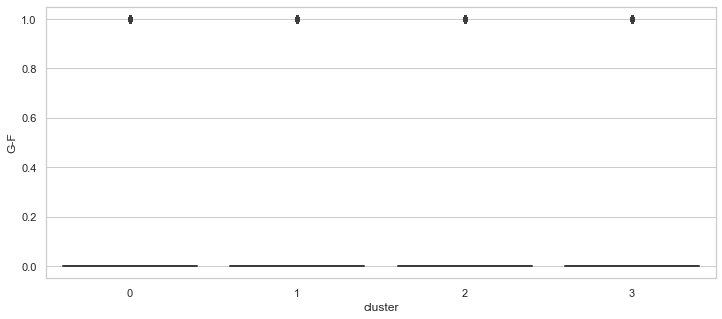

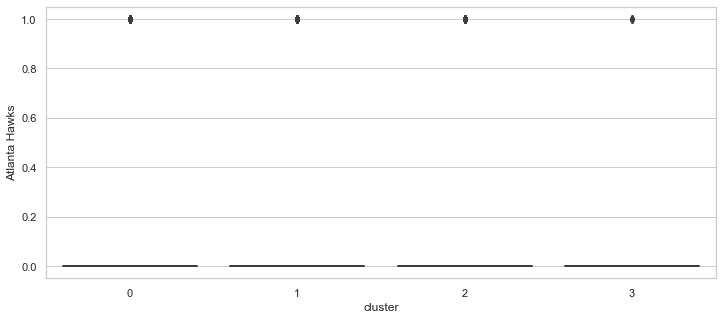

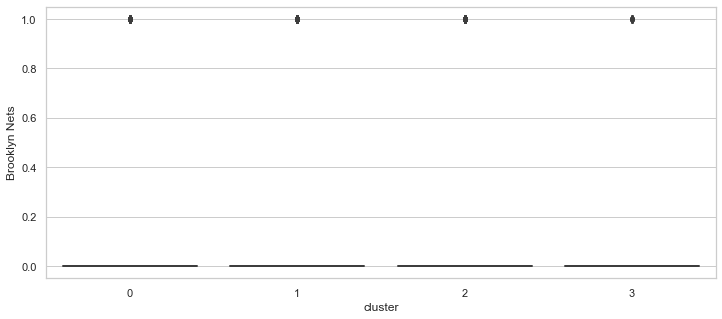

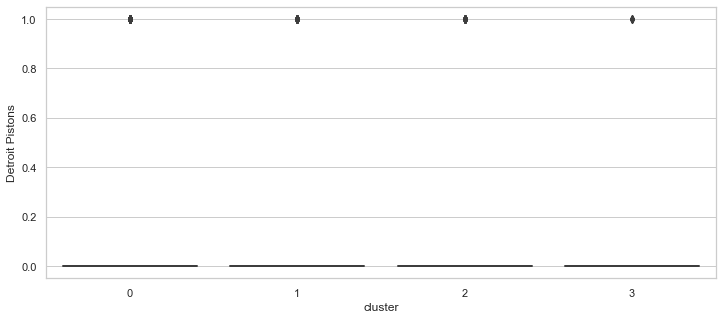

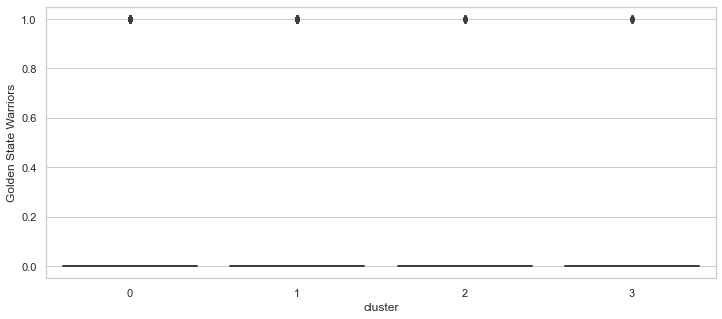

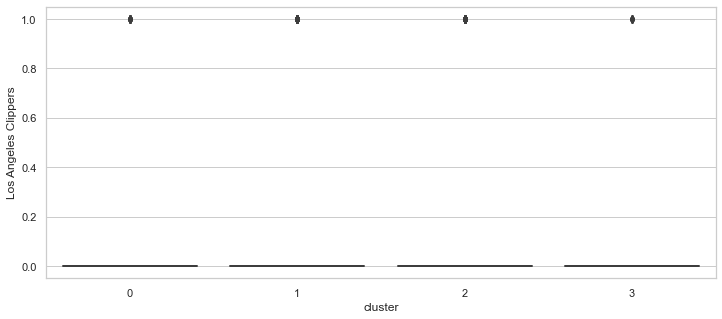

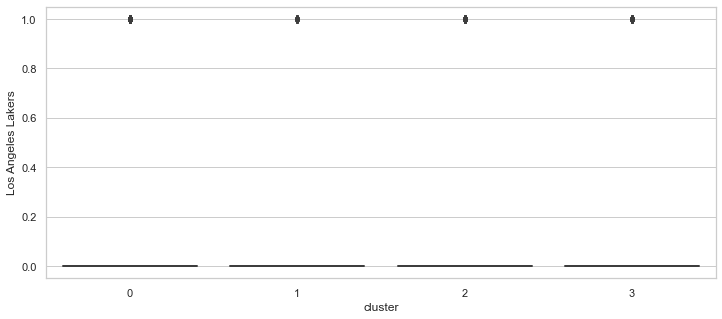

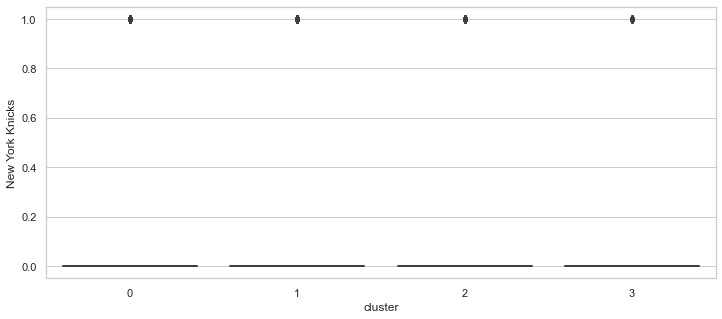

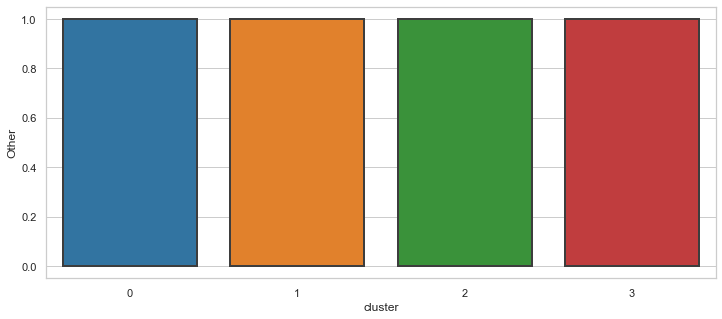

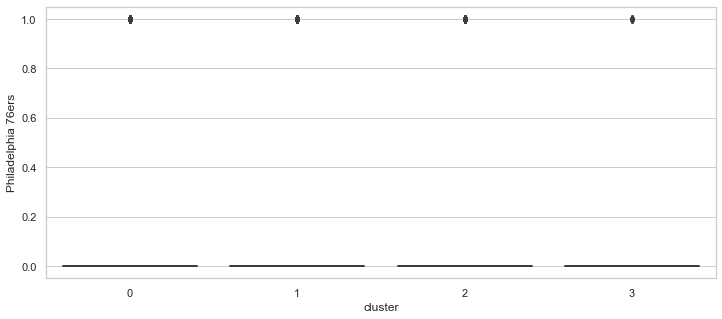

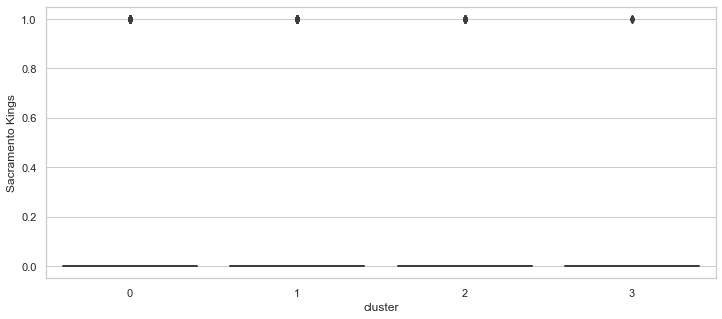

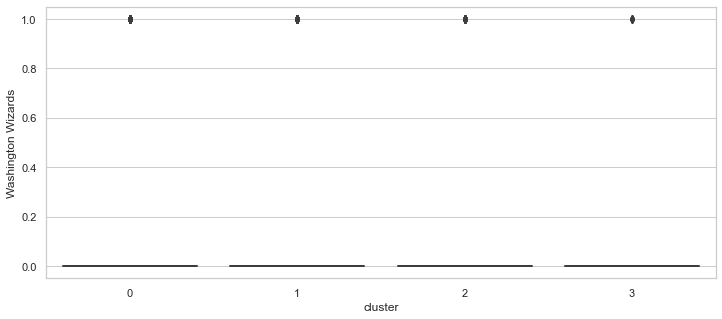

In [59]:
#Quick results study
for col in attributes:
    sns.boxplot(x="cluster", y=col, data=df_golden_record_playoff_clustered)
    plt.show()

### 4.4.1 Deep dive to k-mean clustering

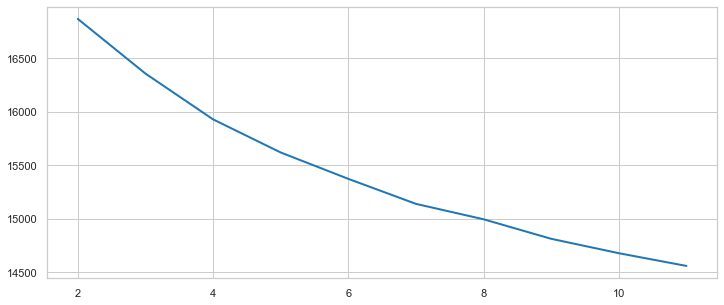

In [60]:
d=[]
for K in range(2,12):
    clf = cluster.KMeans(init='random', n_clusters=K, random_state=0)
    clf.fit(datanorm_playoff)
    y_pred = clf.predict(datanorm_playoff)
    p=[]
    for i in range(K):
        p.append(np.sum(distance.cdist(datanorm_playoff[y_pred==i,:],[clf.cluster_centers_[i]],'euclidean')))
    d.append(np.sum(p))
plt.plot(np.arange(2,12),d)

In [61]:
inrt=np.zeros(12)
sil_kmeans_r=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        clf = cluster.KMeans(init='random', n_clusters=i*1+2, random_state=0)
        clf.fit(datanorm_playoff)
        inrt[i]=clf.inertia_
        sil_kmeans_r[i]=metrics.silhouette_score(datanorm_playoff, clf.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_playoff[(clf.labels_==i)])) + ' players')

k: 2
Cluster 0 has 1593 players
Cluster 1 has 723 players
k: 3
Cluster 0 has 278 players
Cluster 1 has 995 players
Cluster 2 has 1043 players
k: 4
Cluster 0 has 521 players
Cluster 1 has 233 players
Cluster 2 has 741 players
Cluster 3 has 821 players
k: 5
Cluster 0 has 446 players
Cluster 1 has 562 players
Cluster 2 has 118 players
Cluster 3 has 709 players
Cluster 4 has 481 players
k: 6
Cluster 0 has 542 players
Cluster 1 has 82 players
Cluster 2 has 399 players
Cluster 3 has 413 players
Cluster 4 has 302 players
Cluster 5 has 578 players
k: 7
Cluster 0 has 295 players
Cluster 1 has 69 players
Cluster 2 has 428 players
Cluster 3 has 407 players
Cluster 4 has 426 players
Cluster 5 has 438 players
Cluster 6 has 253 players
k: 8
Cluster 0 has 436 players
Cluster 1 has 61 players
Cluster 2 has 379 players
Cluster 3 has 315 players
Cluster 4 has 156 players
Cluster 5 has 405 players
Cluster 6 has 304 players
Cluster 7 has 260 players
k: 9
Cluster 0 has 241 players
Cluster 1 has 57 players


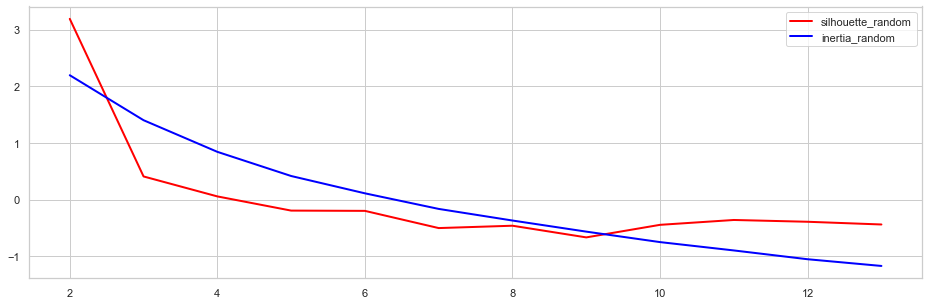

In [62]:
plt.plot(np.arange(12)*1+2,scaler.fit_transform(sil_kmeans_r.reshape(-1, 1)),'r', label='silhouette_random')
plt.plot(np.arange(12)*1+2,scaler.fit_transform(inrt.reshape(-1, 1)),'b', label='inertia_random')
plt.legend()
fig=plt.gcf()
fig.set_size_inches((16,5))

In [63]:
inrt=np.zeros(12)
sil_kmeans_plus=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        clf = cluster.KMeans(init='k-means++', n_clusters=i*1+2, random_state=0)
        clf.fit(datanorm_playoff)
        inrt[i]=clf.inertia_
        sil_kmeans_plus[i]=metrics.silhouette_score(datanorm_playoff, clf.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_playoff[(clf.labels_==i)])) + ' players')

k: 2
Cluster 0 has 1593 players
Cluster 1 has 723 players
k: 3
Cluster 0 has 276 players
Cluster 1 has 1037 players
Cluster 2 has 1003 players
k: 4
Cluster 0 has 528 players
Cluster 1 has 836 players
Cluster 2 has 722 players
Cluster 3 has 230 players
k: 5
Cluster 0 has 124 players
Cluster 1 has 745 players
Cluster 2 has 485 players
Cluster 3 has 495 players
Cluster 4 has 467 players
k: 6
Cluster 0 has 359 players
Cluster 1 has 663 players
Cluster 2 has 305 players
Cluster 3 has 421 players
Cluster 4 has 485 players
Cluster 5 has 83 players
k: 7
Cluster 0 has 390 players
Cluster 1 has 255 players
Cluster 2 has 406 players
Cluster 3 has 416 players
Cluster 4 has 460 players
Cluster 5 has 76 players
Cluster 6 has 313 players
k: 8
Cluster 0 has 209 players
Cluster 1 has 416 players
Cluster 2 has 367 players
Cluster 3 has 134 players
Cluster 4 has 301 players
Cluster 5 has 391 players
Cluster 6 has 58 players
Cluster 7 has 440 players
k: 9
Cluster 0 has 51 players
Cluster 1 has 328 players

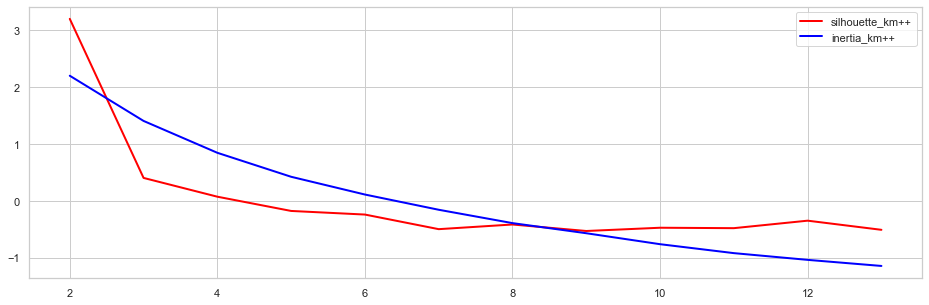

In [64]:
plt.plot(np.arange(12)*1+2,scaler.fit_transform(sil_kmeans_plus.reshape(-1, 1)),'r', label='silhouette_km++')
plt.plot(np.arange(12)*1+2,scaler.fit_transform(inrt.reshape(-1, 1)),'b', label='inertia_km++')
plt.legend()
fig=plt.gcf()
fig.set_size_inches((16,5))

It looks like 4 is going to be the best fit. But first, let's study other clustering techniques...

### 4.4.2 Other clustering techniques

Let's start with hierarhical clustering

In [65]:
sil_single=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        single = cluster.AgglomerativeClustering(linkage="single",n_clusters=1*i+2,connectivity=None)
        single.fit(datanorm_playoff)
        sil_single[i]=metrics.silhouette_score(datanorm_playoff, single.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_playoff[(single.labels_==i)])) + ' players')

k: 2
Cluster 0 has 2315 players
Cluster 1 has 1 players
k: 3
Cluster 0 has 2314 players
Cluster 1 has 1 players
Cluster 2 has 1 players
k: 4
Cluster 0 has 2313 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
k: 5
Cluster 0 has 2312 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
k: 6
Cluster 0 has 2311 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
k: 7
Cluster 0 has 2310 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 1 players
k: 8
Cluster 0 has 2309 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 1 players
Cluster 7 has 1 players
k: 9
Cluster 0 has 2307 players
Cluster 1 has 2 players
Cluster 2 has 1 players
Cluster 3 has 1 players


In [66]:
sil_single_con=np.zeros(12)
connectivity = kneighbors_graph(datanorm_playoff, n_neighbors=5)
for i in range(12):
        print('k:',1*i+2)
        single = cluster.AgglomerativeClustering(linkage="single",n_clusters=1*i+2,connectivity=connectivity)
        single.fit(datanorm_playoff)
        sil_single_con[i]=metrics.silhouette_score(datanorm_playoff, single.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_playoff[(single.labels_==i)])) + ' players')

k: 2
Cluster 0 has 2315 players
Cluster 1 has 1 players
k: 3
Cluster 0 has 2314 players
Cluster 1 has 1 players
Cluster 2 has 1 players
k: 4
Cluster 0 has 2313 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
k: 5
Cluster 0 has 2312 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
k: 6
Cluster 0 has 2311 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
k: 7
Cluster 0 has 2310 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 1 players
k: 8
Cluster 0 has 2309 players
Cluster 1 has 1 players
Cluster 2 has 1 players
Cluster 3 has 1 players
Cluster 4 has 1 players
Cluster 5 has 1 players
Cluster 6 has 1 players
Cluster 7 has 1 players
k: 9
Cluster 0 has 2307 players
Cluster 1 has 2 players
Cluster 2 has 1 players
Cluster 3 has 1 players


In [67]:
sil_ward_con=np.zeros(12)
connectivity = kneighbors_graph(datanorm_playoff, n_neighbors=5)
for i in range(12):
        print('k:',1*i+2)
        single = cluster.AgglomerativeClustering(linkage="ward",n_clusters=1*i+2,connectivity=connectivity)
        single.fit(datanorm_playoff)
        sil_ward_con[i]=metrics.silhouette_score(datanorm_playoff, single.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_playoff[(single.labels_==i)])) + ' players')

k: 2
Cluster 0 has 1926 players
Cluster 1 has 390 players
k: 3
Cluster 0 has 390 players
Cluster 1 has 1450 players
Cluster 2 has 476 players
k: 4
Cluster 0 has 1450 players
Cluster 1 has 114 players
Cluster 2 has 476 players
Cluster 3 has 276 players
k: 5
Cluster 0 has 114 players
Cluster 1 has 668 players
Cluster 2 has 476 players
Cluster 3 has 276 players
Cluster 4 has 782 players
k: 6
Cluster 0 has 668 players
Cluster 1 has 276 players
Cluster 2 has 476 players
Cluster 3 has 26 players
Cluster 4 has 782 players
Cluster 5 has 88 players
k: 7
Cluster 0 has 580 players
Cluster 1 has 276 players
Cluster 2 has 476 players
Cluster 3 has 26 players
Cluster 4 has 782 players
Cluster 5 has 88 players
Cluster 6 has 88 players
k: 8
Cluster 0 has 498 players
Cluster 1 has 276 players
Cluster 2 has 476 players
Cluster 3 has 26 players
Cluster 4 has 782 players
Cluster 5 has 88 players
Cluster 6 has 88 players
Cluster 7 has 82 players
k: 9
Cluster 0 has 476 players
Cluster 1 has 276 players
Clus

Let's try spectral clustering

In [68]:
sil_spectral=np.zeros(12)

for i in range(12):
        print('k:',1*i+2)
        spectral = cluster.SpectralClustering(n_clusters=i*1+2,  affinity="nearest_neighbors",  eigen_solver='arpack')
        spectral.fit(datanorm_playoff)
        sil_spectral[i]=metrics.silhouette_score(datanorm_playoff, spectral.labels_,  metric='euclidean')
        N = 1*i+2
        for i in range(N):
            print('Cluster ' + str(i) + ' has ' + str(len(datanorm_playoff[(spectral.labels_==i)])) + ' players')

k: 2
Cluster 0 has 2236 players
Cluster 1 has 80 players
k: 3
Cluster 0 has 2155 players
Cluster 1 has 81 players
Cluster 2 has 80 players
k: 4
Cluster 0 has 2069 players
Cluster 1 has 80 players
Cluster 2 has 81 players
Cluster 3 has 86 players
k: 5
Cluster 0 has 1986 players
Cluster 1 has 86 players
Cluster 2 has 80 players
Cluster 3 has 83 players
Cluster 4 has 81 players
k: 6
Cluster 0 has 1908 players
Cluster 1 has 80 players
Cluster 2 has 81 players
Cluster 3 has 78 players
Cluster 4 has 86 players
Cluster 5 has 83 players
k: 7
Cluster 0 has 1104 players
Cluster 1 has 805 players
Cluster 2 has 78 players
Cluster 3 has 80 players
Cluster 4 has 80 players
Cluster 5 has 86 players
Cluster 6 has 83 players
k: 8
Cluster 0 has 86 players
Cluster 1 has 1094 players
Cluster 2 has 78 players
Cluster 3 has 82 players
Cluster 4 has 80 players
Cluster 5 has 80 players
Cluster 6 has 733 players
Cluster 7 has 83 players
k: 9
Cluster 0 has 999 players
Cluster 1 has 730 players
Cluster 2 has 86 

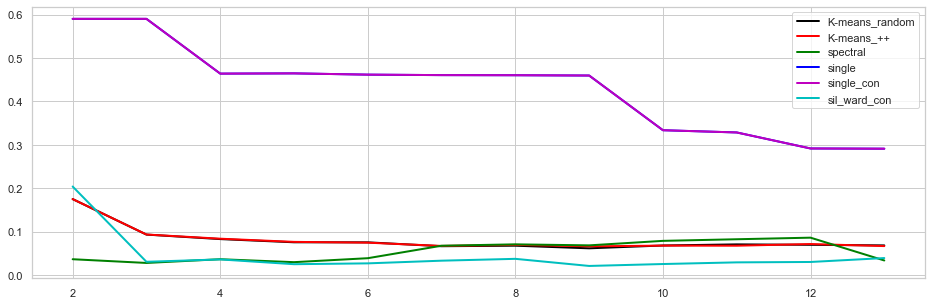

In [69]:
plt.plot(np.arange(12)*1+2,sil_kmeans_r.reshape(-1, 1),'black', label='K-means_random')
plt.plot(np.arange(12)*1+2,sil_kmeans_plus.reshape(-1, 1),'r', label='K-means_++')
plt.plot(np.arange(12)*1+2,sil_spectral.reshape(-1, 1),'g', label='spectral')
plt.plot(np.arange(12)*1+2,sil_single.reshape(-1, 1),'b', label='single')
plt.plot(np.arange(12)*1+2,sil_single_con.reshape(-1, 1),'m', label='single_con')
plt.plot(np.arange(12)*1+2,sil_ward_con.reshape(-1, 1),'c', label='sil_ward_con')


plt.legend()
fig=plt.gcf()
fig.set_size_inches((16,5))

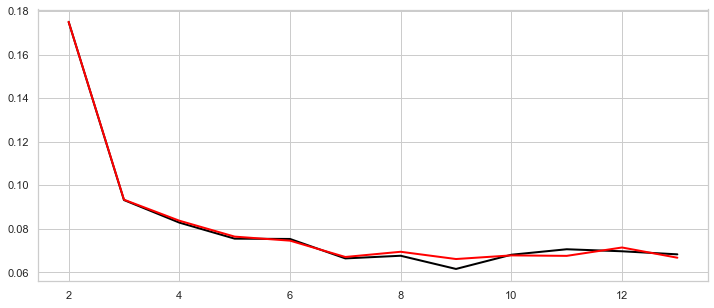

In [70]:
plt.plot(np.arange(12)*1+2,sil_kmeans_r.reshape(-1, 1),'black', label='K-means_random')
plt.plot(np.arange(12)*1+2,sil_kmeans_plus.reshape(-1, 1),'r', label='K-means_++')

In [71]:
#nos quedamos con 3 o 4

#### PCA study

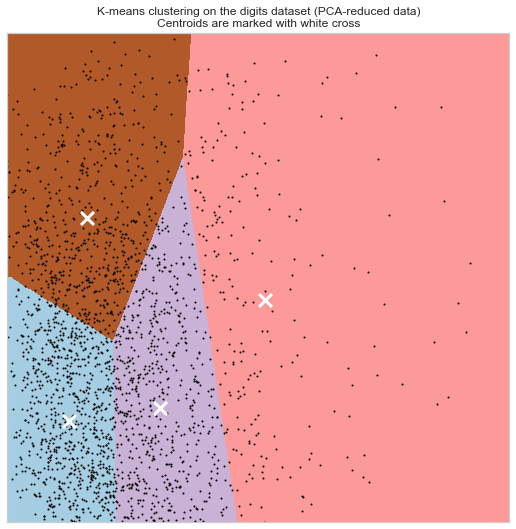

In [72]:
###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(datanorm_playoff)
kmeans = cluster.KMeans(init='k-means++', n_clusters=4, n_init=90)
kmeans.fit(reduced_data)

                    # Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02             # point in the mesh [x_min, m_max]x[y_min, y_max].

        # Plot the decision boundary. For that, we will assign a color to each point
x_min, x_max = reduced_data[:, 0].min() + 1, reduced_data[:, 0].max() - 1
y_min, y_max = reduced_data[:, 1].min() + 1, reduced_data[:, 1].max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
Z = Z.reshape(xx.shape)

#visualize
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest', extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       cmap=plt.cm.Paired,aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

fig = plt.gcf()
fig.set_size_inches((9,9))

# Optimized models and clustering board

The resulting optimized models for clustering the NBA players are: using K-Means algorithm in both cases. Getting 3 clusters in both cases (playoff and non-playoff players).

In [73]:
#NO-PLAYOFF MODEL
#Vars for the optimized clustering model
n_clusters_optimized = 3
random_state = 0

clustering_model_no_playoff = cluster.KMeans(init='random', n_clusters=n_clusters_optimized, random_state=random_state)
clustering_model_no_playoff.fit(datanorm_no_playoff)

path = 'C:/Users/oriol/OneDrive/Escritorio/Postgrau Data Science UB/99. Capstone Project/Proves/0. NBA/Models/'
filename = 'clustering_model_no_playoff'
pickle.dump(clustering_model_no_playoff, open(path+filename, 'wb'))

In [74]:
#PLAYOFF MODEL
#Vars for the optimized clustering model
n_clusters_optimized = 3
random_state = 0

clustering_model_playoff = cluster.KMeans(init='random', n_clusters=n_clusters_optimized, random_state=random_state)
clustering_model_playoff.fit(datanorm_playoff)

path = 'C:/Users/oriol/OneDrive/Escritorio/Postgrau Data Science UB/99. Capstone Project/Proves/0. NBA/Models/'
filename = 'clustering_model_playoff'
pickle.dump(clustering_model_playoff, open(path+filename, 'wb'))

We build the clustering board (golden record with the predicted clusters)

In [75]:
df_clustering_board_no_playoff = df_golden_record_aux[df_golden_record_aux['Playoff_flag']=='No'] #previous to get dummies and other transformations

pred_no_playoff = clustering_model_no_playoff.predict(datanorm_no_playoff)
df_clustering_board_no_playoff['Cluster'] = pred_no_playoff

df_clustering_board_no_playoff.head()

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,n_playoff,n_total_wins,w_l_pct,most_popular_team_played,triple_double_metric_RegS,triple_double_metric_Playoff,championship_pct,player_url,player_name,Cluster
2316,0,2.0,0.000,-1.0,0.0,0.000,1.0,1.0,1.0,NaN,...,2,76,0.528,Philadelphia 76ers,0.066667,NaN,0.0,/players/a/ablefo01.html,Forest Able,1
2317,0,3.1,0.370,0.8,0.3,0.500,1.0,0.5,0.4,NaN,...,0,57,0.232,Los Angeles Clippers,0.140000,NaN,0.0,/players/a/ackeral01.html,Alex Acker,2
2318,60,3.9,0.444,1.6,1.1,0.759,3.5,0.6,2.0,NaN,...,0,19,0.232,Phoenix Suns,0.300000,NaN,0.0,/players/a/acyqu01.html,Quincy Acy,0
2319,0,2.0,0.314,0.0,0.4,0.700,2.3,0.2,0.6,NaN,...,0,45,0.308,Toronto Raptors,0.133333,NaN,0.0,/players/a/alabiso01.html,Solomon Alabi,2
2320,0,4.5,0.293,-1.0,1.2,0.598,4.2,0.3,2.2,NaN,...,4,144,0.456,Los Angeles Lakers,0.260000,NaN,0.0,/players/a/alcorga01.html,Gary Alcorn,1


In [76]:
df_clustering_board_playoff = df_golden_record_aux[df_golden_record_aux['Playoff_flag']=='Yes'] #previous to get dummies and other transformations

pred_playoff = clustering_model_playoff.predict(datanorm_playoff)
df_clustering_board_playoff['Cluster'] = pred_playoff

df_clustering_board_playoff.head()

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,n_playoff,n_total_wins,w_l_pct,most_popular_team_played,triple_double_metric_RegS,triple_double_metric_Playoff,championship_pct,player_url,player_name,Cluster
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,6,744,0.504,Washington Wizards,0.223333,0.010000,0.0,/players/t/terryca01.html,Carlos Terry,1
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,4,192,0.585,Atlanta Hawks,0.203333,0.000000,0.0,/players/h/harlisk01.html,Skip Harlicka,1
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,0,51,0.207,Golden State Warriors,0.170000,0.000000,0.0,/players/c/curlebi01.html,Bill Curley,1
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,1,42,0.512,Miami Heat,0.190000,0.000000,0.0,/players/e/ellisle02.html,LeRon Ellis,1
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,2,86,0.524,Charlotte Hornets,0.323333,0.066667,0.0,/players/w/whitedj01.html,D.J. White,1


In [77]:
#renombrem els cluster-> ara tenim de 0 a 5 (6 en total)
df_clustering_board_playoff['Cluster'] = df_clustering_board_playoff['Cluster'].apply(lambda x: 3 if x==0 else 4 if x==1 else 5)

In [78]:
df_clustering_board_playoff['Cluster'].dtype

dtype('int64')

In [79]:
df_clustering_board = df_clustering_board_playoff.append(df_clustering_board_no_playoff)
df_clustering_board

,games_started_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,FT_goals_attempts_pg_RegS,FT_goals_percent_pg_RegS,total_rebounds_pg_RegS,assists_pg_RegS,personal_foults_pg_RegS,games_started_Playoff,...,n_playoff,n_total_wins,w_l_pct,most_popular_team_played,triple_double_metric_RegS,triple_double_metric_Playoff,championship_pct,player_url,player_name,Cluster
0,3,3.0,0.434,0.1,0.6,0.672,2.4,1.3,1.7,0.0,...,6,744,0.504,Washington Wizards,0.223333,0.010000,0.0,/players/t/terryca01.html,Carlos Terry,4
1,0,3.5,0.456,-1.0,1.2,0.774,0.6,1.4,1.1,0.0,...,4,192,0.585,Atlanta Hawks,0.203333,0.000000,0.0,/players/h/harlisk01.html,Skip Harlicka,4
2,11,2.4,0.444,0.1,0.7,0.743,2.0,0.4,2.3,0.0,...,0,51,0.207,Golden State Warriors,0.170000,0.000000,0.0,/players/c/curlebi01.html,Bill Curley,4
3,2,2.8,0.433,0.0,1.0,0.613,2.4,0.3,1.2,0.0,...,1,42,0.512,Miami Heat,0.190000,0.000000,0.0,/players/e/ellisle02.html,LeRon Ellis,4
4,11,5.0,0.507,0.0,1.1,0.720,3.2,0.6,1.4,0.0,...,2,86,0.524,Charlotte Hornets,0.323333,0.066667,0.0,/players/w/whitedj01.html,D.J. White,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3437,0,2.6,0.286,0.0,0.3,1.000,1.8,0.1,1.6,NaN,...,0,37,0.451,Indiana Pacers,0.123333,NaN,0.0,/players/z/zenoto01.html,Tony Zeno,1
3438,23,2.9,0.408,0.0,1.2,0.783,2.1,0.2,1.8,NaN,...,2,122,0.744,Oklahoma City Thunder,0.190000,NaN,0.0,/players/z/zidekge01.html,George Zídek,2
3439,0,1.5,0.667,0.0,0.0,0.000,2.0,3.5,2.0,NaN,...,4,196,0.598,Brooklyn Nets,0.250000,NaN,0.0,/players/z/zimmede01.html,Derrick Zimmerman,2
3440,0,1.6,0.323,0.0,0.3,0.600,1.8,0.2,0.9,NaN,...,0,29,0.354,Orlando Magic,0.106667,NaN,0.0,/players/z/zimmest01.html,Stephen Zimmerman,2


In [80]:
df_clustering_board['Cluster'] = df_clustering_board['Cluster'].astype('str')
df_clustering_board['Cluster'].dtype

dtype('O')

<AxesSubplot:>

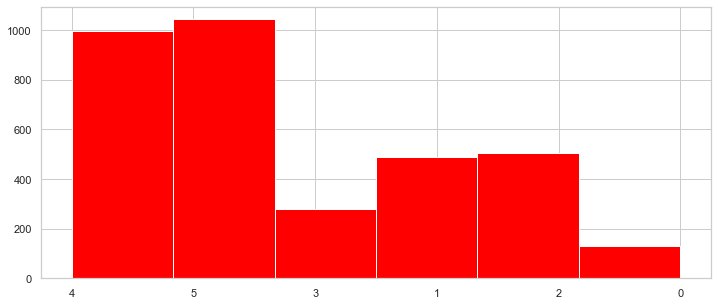

In [81]:
df_clustering_board['Cluster'].hist(bins=6,color='red')

In [82]:
#Observem que hi ha dos grans clusters a cada tipus de jugador, i un de minoritari.

## Clustering profiling

In [83]:
df_clustering_board.dtypes

games_started_RegS                   int64
field_goals_attempts_pg_RegS       float64
field_goals_percent_pg_RegS        float64
_3pts_goals_attempts_pg_RegS       float64
FT_goals_attempts_pg_RegS          float64
FT_goals_percent_pg_RegS           float64
total_rebounds_pg_RegS             float64
assists_pg_RegS                    float64
personal_foults_pg_RegS            float64
games_started_Playoff              float64
field_goals_attempts_pg_Playoff    float64
field_goals_percent_pg_Playoff     float64
_3pts_goals_attempts_pg_Playoff    float64
FT_goals_attempts_pg_Playoff       float64
FT_goals_percent_pg_Playoff        float64
total_rebounds_pg_Playoff          float64
assists_pg_Playoff                 float64
personal_foults_pg_Playoff         float64
FT_goals_attempts_total_RegS         int64
assists_total_RegS                   int64
FT_goals_attempts_total_Playoff    float64
assists_total_Playoff              float64
player_eff_rating_RegS             float64
true_shooti

Distribution analytics by column and cluster, divided correctly

In [84]:
cols = df_clustering_board.columns

playoff_cols = [c for c in cols if 'Playoff' in c]
extra_playoff = ['championship_pct','n_playoff','n_NBA_Champ'] #in general, although there are 10 exceptions
playoff_cols.extend(extra_playoff)

cols = [c for c in cols if c not in playoff_cols]

In [85]:
cols

['games_started_RegS',
 'field_goals_attempts_pg_RegS',
 'field_goals_percent_pg_RegS',
 '_3pts_goals_attempts_pg_RegS',
 'FT_goals_attempts_pg_RegS',
 'FT_goals_percent_pg_RegS',
 'total_rebounds_pg_RegS',
 'assists_pg_RegS',
 'personal_foults_pg_RegS',
 'FT_goals_attempts_total_RegS',
 'assists_total_RegS',
 'player_eff_rating_RegS',
 'true_shooting_eff_RegS',
 'usage_percent_RegS',
 'win_share_RegS',
 'Hall_Of_Fame',
 'n_All_Star',
 'gone_to_college',
 'n_teams',
 'active_from',
 'active_to',
 'position',
 'weight',
 'birth_date(year)',
 'height(cm)',
 'age_entrance',
 'age_retirement',
 'years_active',
 'draft_year',
 'draft_round',
 'draft_pick_number',
 'n_total_wins',
 'w_l_pct',
 'most_popular_team_played',
 'triple_double_metric_RegS',
 'player_url',
 'player_name',
 'Cluster']

## Descriptive profiling

In [86]:
descriptive_cols = ['active_from','active_to','position','weight','birth_date(year)','height(cm)','age_entrance',
                    'age_retirement','years_active']
career_cols = ['draft_year','draft_round','draft_pick_number','gone_to_college','n_teams', 'Hall_Of_Fame','n_All_Star', 
               'n_total_wins','w_l_pct','most_popular_team_played']

In [87]:
def paint_num_dist(col,DATA):
    sns.boxplot(x="Cluster", y=col, data=DATA)
    plt.show()

In [88]:
def group_catvars(col, n_max=9, misc_label='Other'):
        """
        Function to group sparse categories into an Other label
        :param col: pd.Series / Categorical / Object series to group
        :param n_max: int / maximum number of stand-alone categories to keep, default = 9
        :param misc_label: str / Label to assign to the grouped category, default = 'Other'
        """
        cols_to_keep = col.value_counts().index[:n_max]
        return  np.where(col.isin(cols_to_keep), col, misc_label)

In [89]:
def plot_cluster_distributions(df_clus, var_x='Cluster', var_hue='', sort=True , save_plot=False, _name='model', n_max=9):
        """
        Function to plot normalized stacked distribution of clusters with one variable
        :param df_clus: DataFrame with a column labelled 'cluster'
        :param var_x: str / Var to plot in the X axis, default = 'cluster'
        :param var_hue: str / Var to plot the stacked distribution as a hue
        :param sort: bool (default : True)  / Whether to sort columns
        :param save_plot: False/str  (default : False) / If not False, folder to save the plot 
        :param _name: str  (default : 'model') / Prefix of the files to be saved
        """   
        df_plot = df_clus[[var_hue, var_x, df_clus.columns[1]]].copy() 
        n_clus = df_clus['Cluster'].nunique()

        if (var_x != 'Cluster'):    df_plot[var_x]   = group_catvars(df_plot[var_x],    n_max, misc_label='Other')
        if (var_hue  != 'Cluster'): df_plot[var_hue] = group_catvars(df_plot[var_hue],  n_max, misc_label='Other')

        plt.figure(figsize= (20,7) )
        ax = plt.gca()
        if (df_plot[var_hue].nunique() <=20): 
            colors = plt.cm.get_cmap('tab20').colors
        else: colors = sns.color_palette("hls", df_plot[var_hue].nunique()+3)
            
        df_plot2 = df_plot.pivot_table(index=var_x, values= df_plot.columns[2], columns=var_hue, aggfunc='count')\
            .divide(df_plot[var_x].value_counts(), axis=0)
        
        if(sort):  df_plot2 = df_plot2.reindex(df_plot['Cluster'].value_counts().index)
            
        df_plot2.plot(kind='bar', stacked=True, ax=ax, rot=0, color=colors)
        if(var_x=='Cluster'): plt.xticks(range(n_clus), df_plot2.index);
        plt.xlabel(var_x);plt.title(var_hue);
        #Plotting.autolabel(ax, prop=True, values= df_plot.groupby([var_hue, var_x]).count().dropna()[df_clus.columns[1]].values)
        if (save_plot):
            os.makedirs(save_plot, exist_ok=True)
            plt.savefig(save_plot+'/'+_name+'_'+var_x+'_'+var_hue+'.png', format="png")

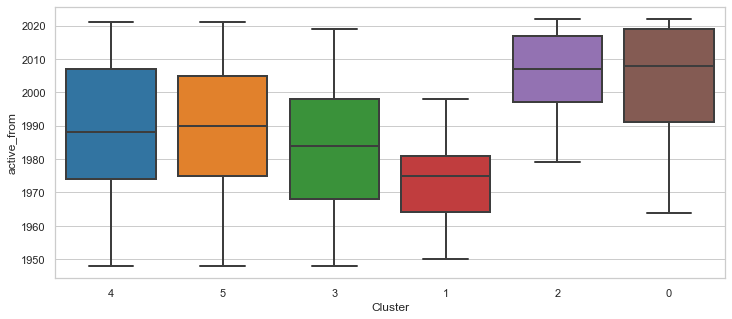

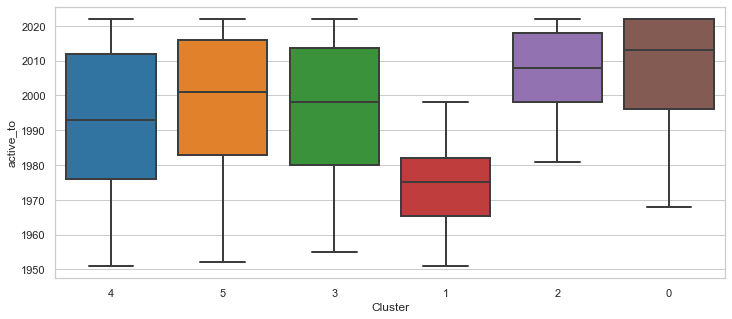

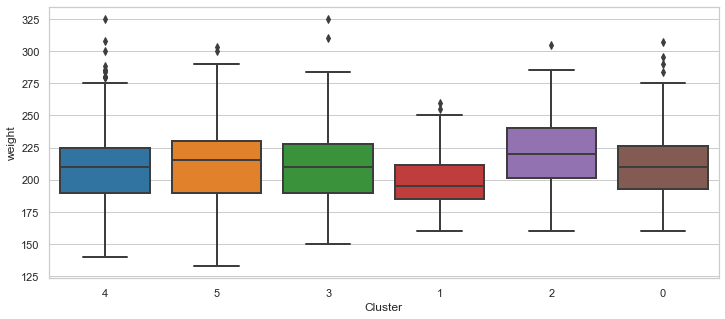

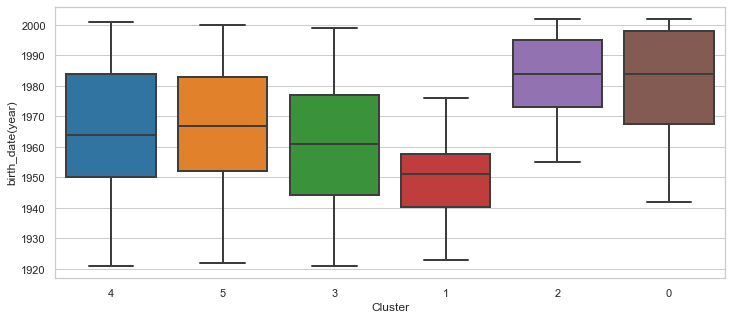

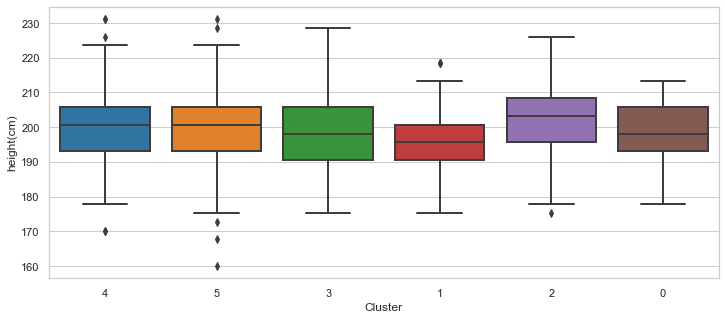

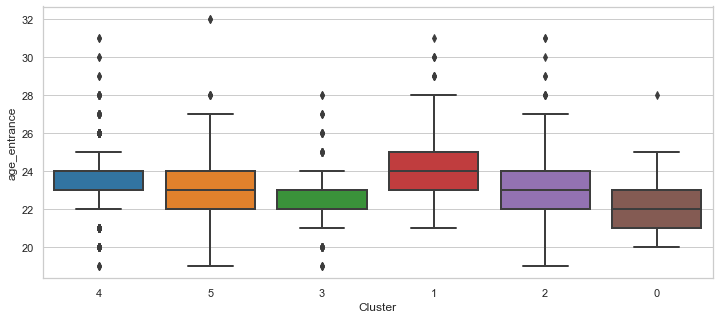

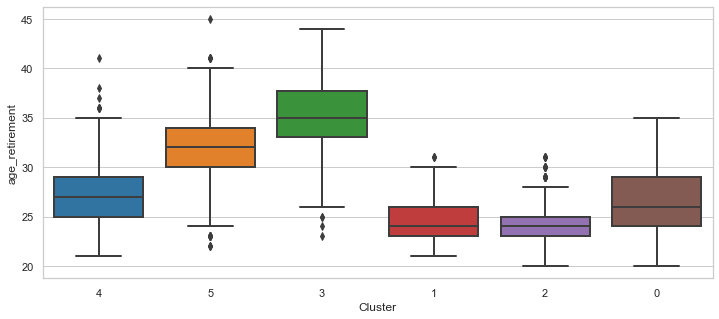

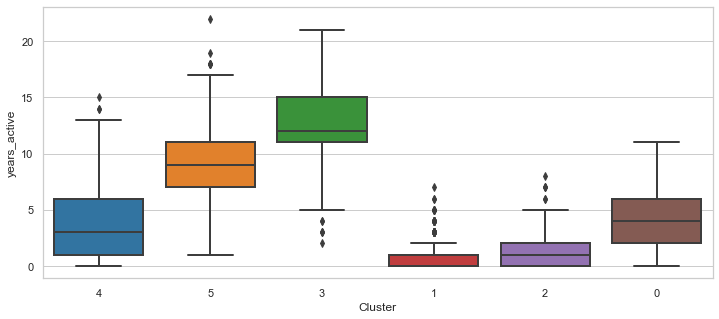

In [90]:
for i in descriptive_cols:
    if df_clustering_board[i].dtype!='object':
        paint_num_dist(i,df_clustering_board)

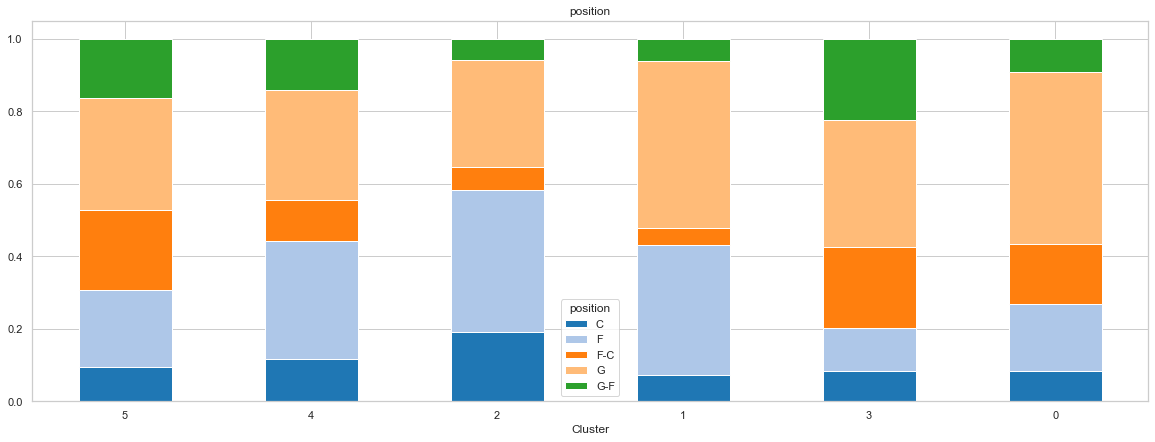

In [91]:
for i in descriptive_cols:
    if df_clustering_board[i].dtype=='object':
        plot_cluster_distributions(df_clustering_board, var_x='Cluster', var_hue=i, sort=True , save_plot=False, _name='model', n_max=10) 

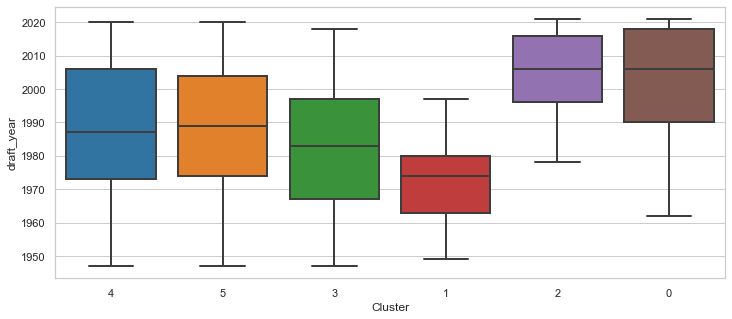

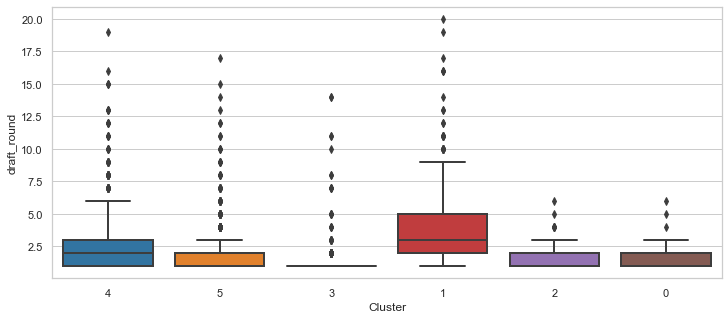

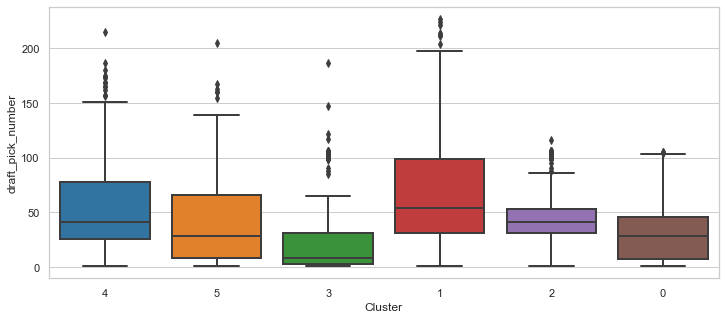

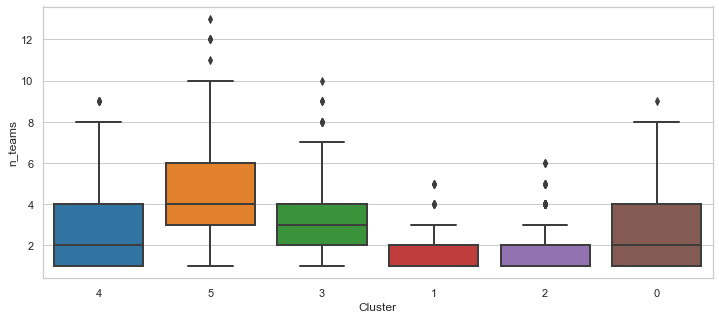

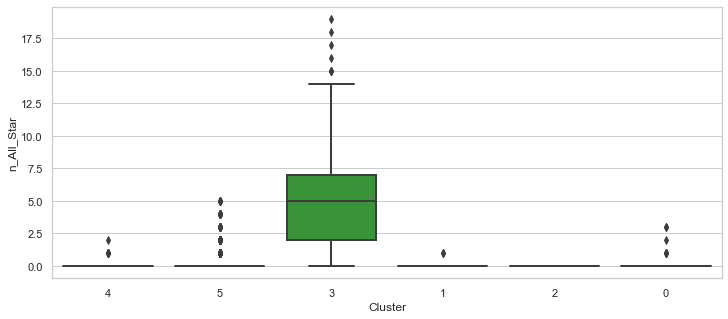

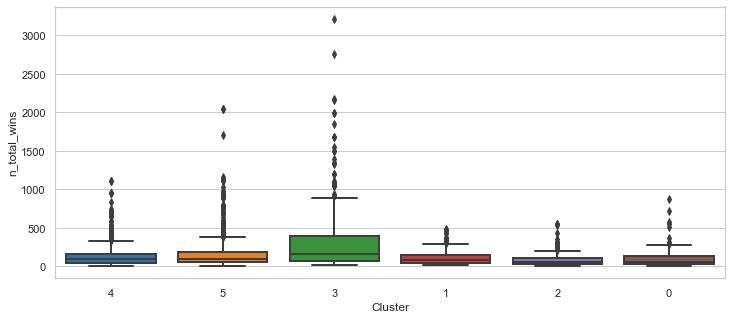

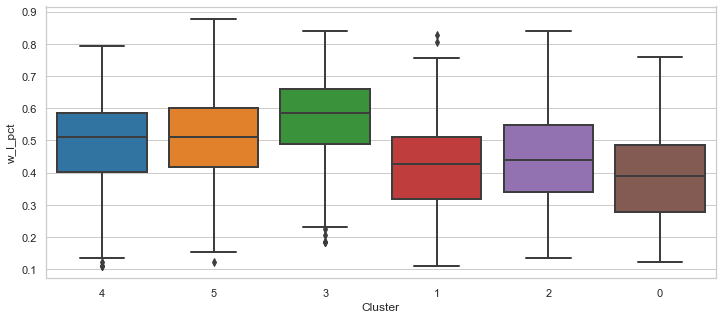

In [92]:
for i in career_cols:
    if df_clustering_board[i].dtype!='object':
        paint_num_dist(i,df_clustering_board)

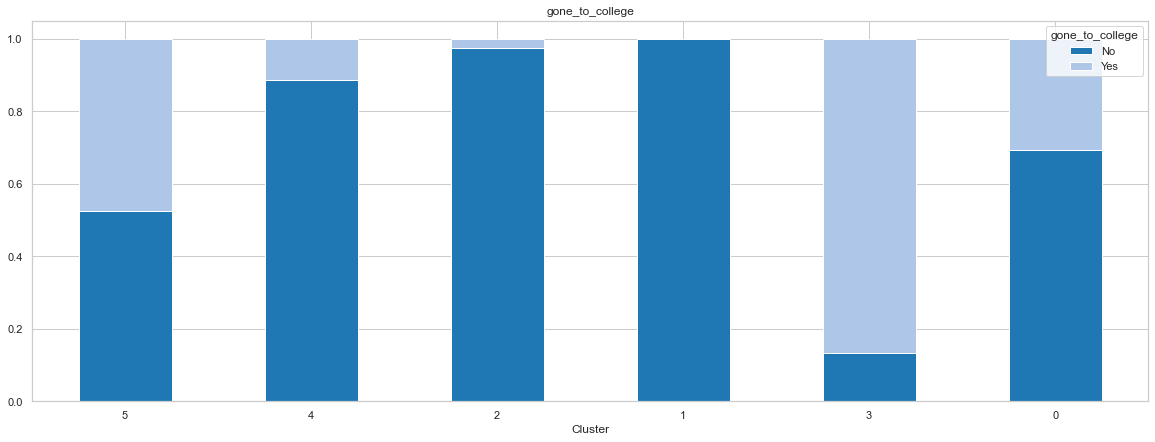

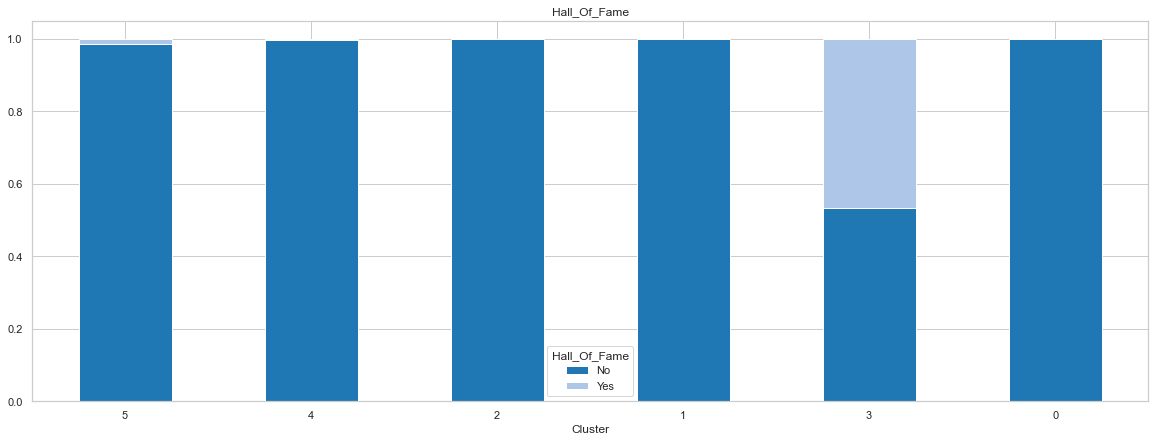

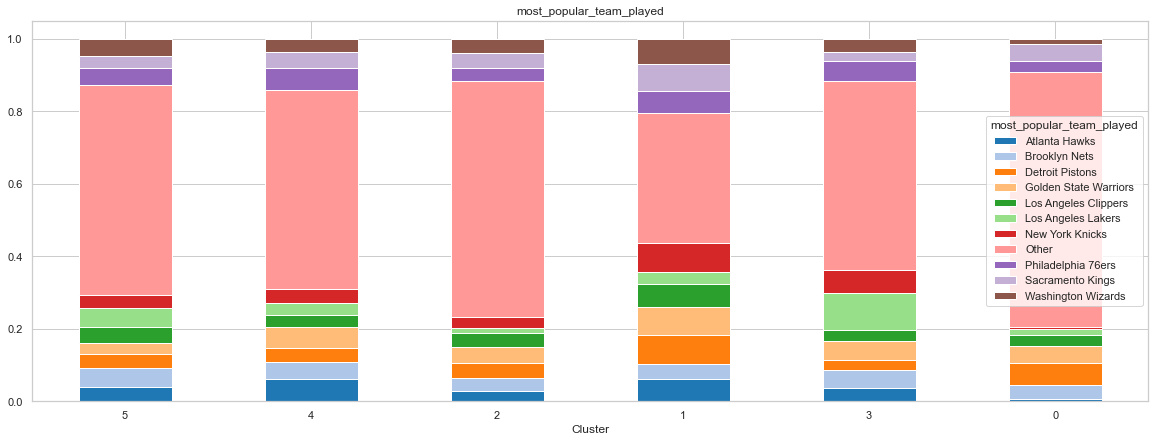

In [93]:
for i in career_cols:
    if df_clustering_board[i].dtype=='object':
        plot_cluster_distributions(df_clustering_board, var_x='Cluster', var_hue=i, sort=True , save_plot=False, _name='model', n_max=10) 

### **Profiling**

##### No playoff players
Cluster 0: jugadores mas antiguos (de los de No_playoff) (1984), entran los mas viejos (aprox 24), pas breu per la lliga (age retirement més baix, aprox 25). Quedan mas atras e el draft. Destaca Nicks.

Cluster 1: los mas pesados y altos (224 pounds, cerca de 2m) -> son 40% alapivots i els que tenen + pivots aprox, els mes joves a entrar (22), dels de no playoff son els que estan més anys (4-5 anys). Majoria bases. De los noplay-off los que mas de college (30%).

Cluster 2: pas breu per la lliga.

##### Playoff players

Cluster 3: els més vells a retirarse, + anys a la lliga (12). La gran majoria son exterior 2-3. Quedan mas arriba en el draft. 90% college. Mitad hall of fame. Destaquen els lakers (cuadra per lo anterior).

Cluster 4: bases i 4s la majoria. Pocos de college (deben ser europeos fichaos). On mes jugadors es 76rs

Cluster 5: 2ns mes anys a la lliga casi 10, quedan mejor en el draft que los 4. Los 4 son de los peores. Hay que decir que esto es porq la mitad de aquí vienen de college. Algun hall of famer.

In [103]:
pd.pivot_table(df_clustering_board, index = 'Cluster',values = descriptive_cols)

,active_from,active_to,age_entrance,age_retirement,birth_date(year),height(cm),weight,years_active
Cluster,,,,,,,,
0,2003.244275,2007.374046,22.251908,26.381679,1980.992366,198.372061,214.068702,4.129771
1,1973.314286,1973.987755,24.087755,24.761224,1949.226531,195.766612,198.471429,0.673469
2,2006.306931,2007.409901,23.178218,24.281188,1983.128713,202.264475,220.720792,1.102970
3,1983.298561,1995.820144,22.733813,35.255396,1960.564748,198.293597,210.143885,12.521583
4,1989.276382,1993.029146,23.453266,27.206030,1965.823116,199.572523,211.877387,3.752764
5,1989.592522,1998.604986,23.025887,32.038351,1966.566635,199.671275,212.915628,9.012464


In [104]:
pd.pivot_table(df_clustering_board, index = 'Cluster',values = career_cols)

,draft_pick_number,draft_round,draft_year,n_All_Star,n_teams,n_total_wins,w_l_pct
Cluster,,,,,,,
0,34.877863,1.442748,2002.114504,0.091603,2.824427,105.770992,0.389156
1,66.320408,4.159184,1971.675510,0.004082,1.381633,104.604082,0.420953
2,45.207921,1.786139,2004.936634,0.000000,1.695050,79.663366,0.441808
3,26.845324,1.654676,1982.161871,5.341727,3.464029,346.604317,0.564848
4,51.798995,2.472362,1987.959799,0.008040,2.774874,134.451256,0.494411
5,41.731544,1.821668,1988.377756,0.315436,4.369128,161.201342,0.506964


## RegS stats profiling

In [94]:
stats_cols_regS = ['games_started_RegS',
 'field_goals_attempts_pg_RegS',
 'field_goals_percent_pg_RegS',
 '_3pts_goals_attempts_pg_RegS',
 'FT_goals_attempts_pg_RegS',
 'FT_goals_percent_pg_RegS',
 'total_rebounds_pg_RegS',
 'assists_pg_RegS',
 'personal_foults_pg_RegS',
 'FT_goals_attempts_total_RegS',
 'assists_total_RegS',
 'player_eff_rating_RegS',
 'true_shooting_eff_RegS',
 'usage_percent_RegS',
 'win_share_RegS','triple_double_metric_RegS']

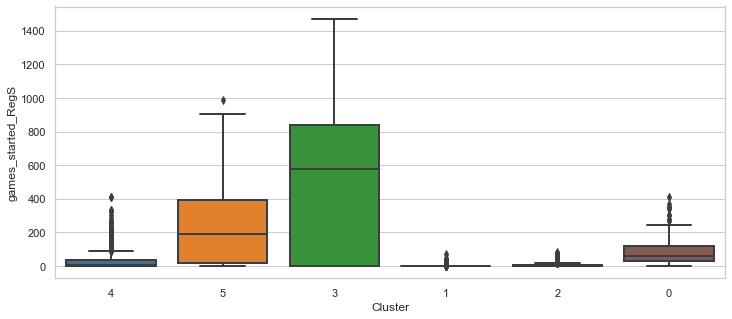

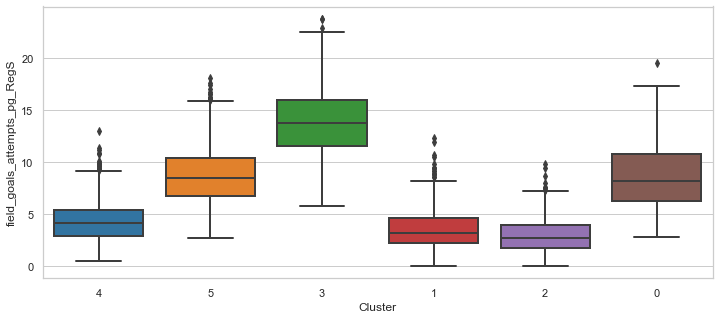

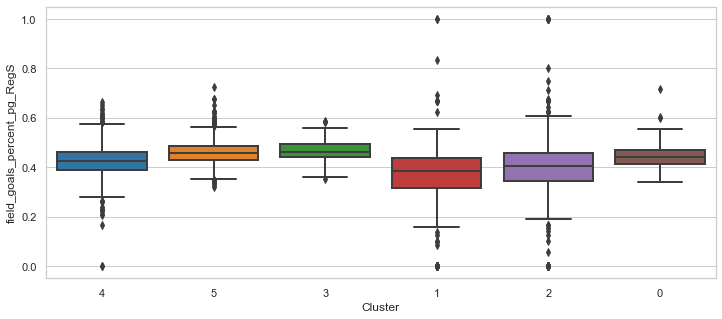

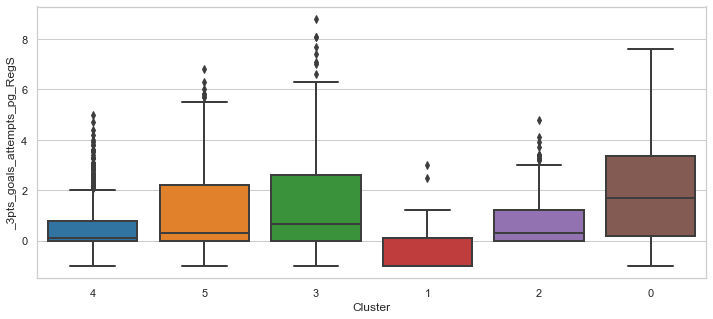

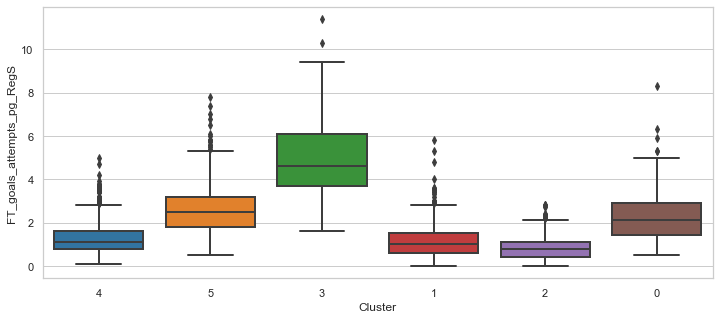

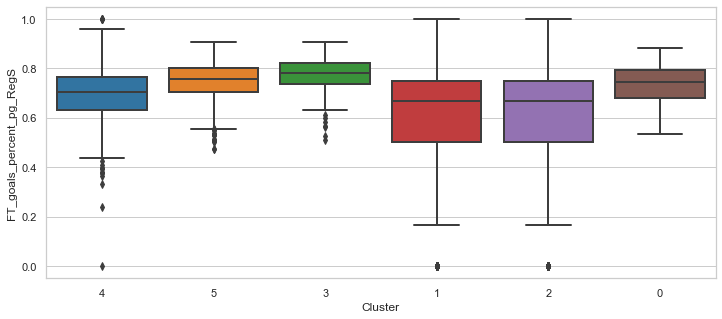

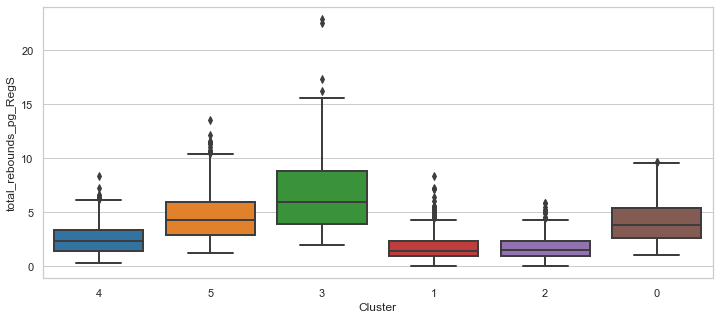

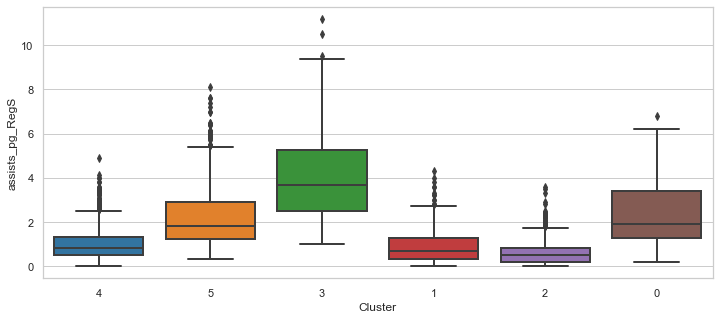

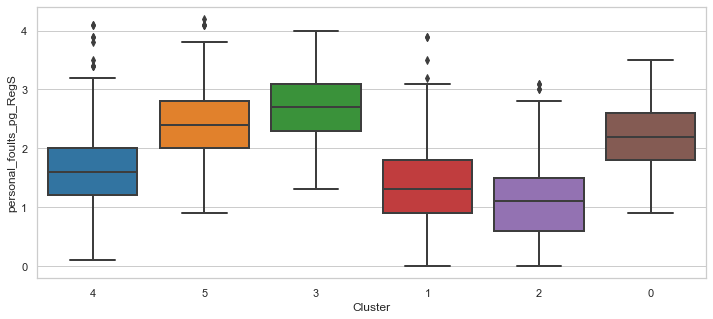

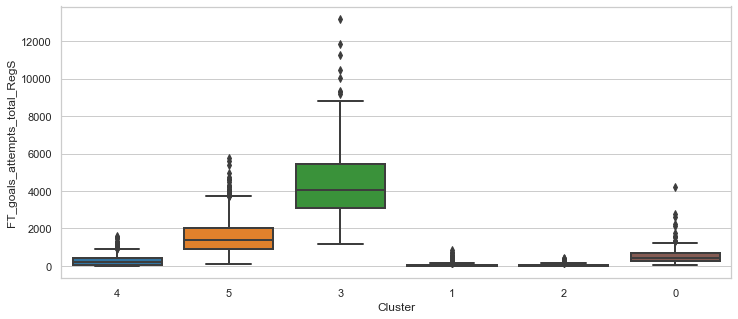

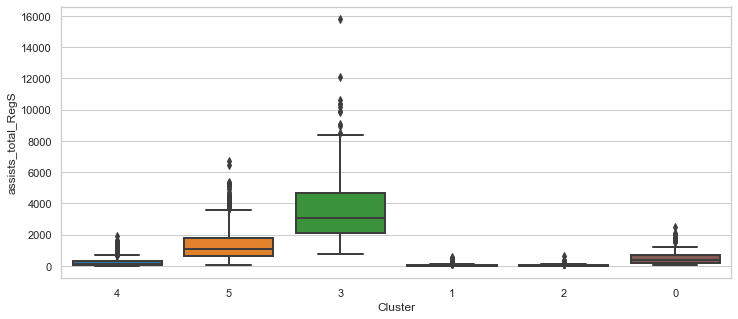

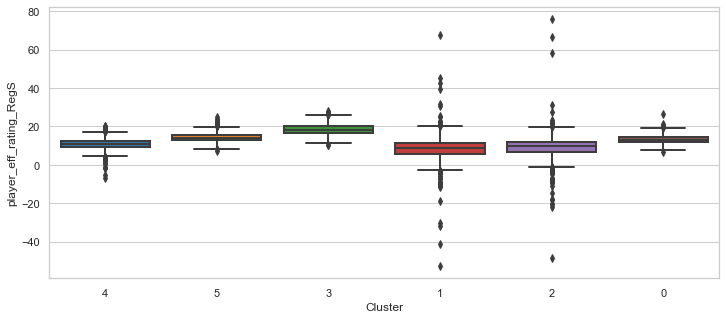

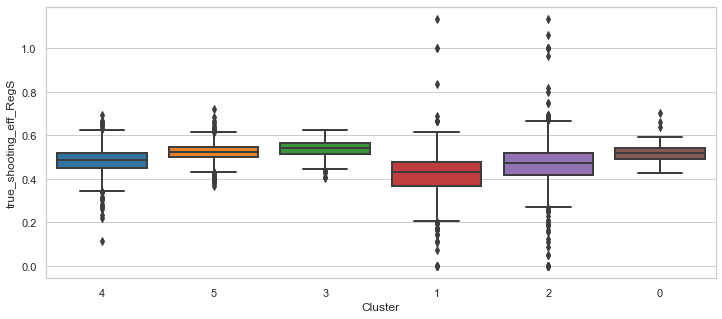

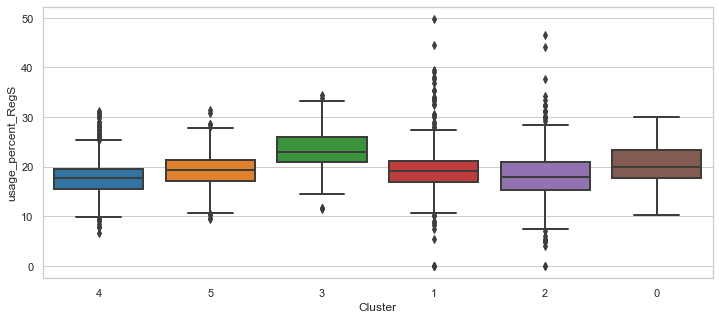

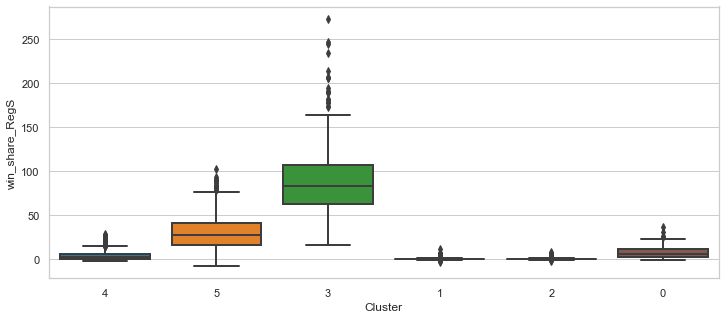

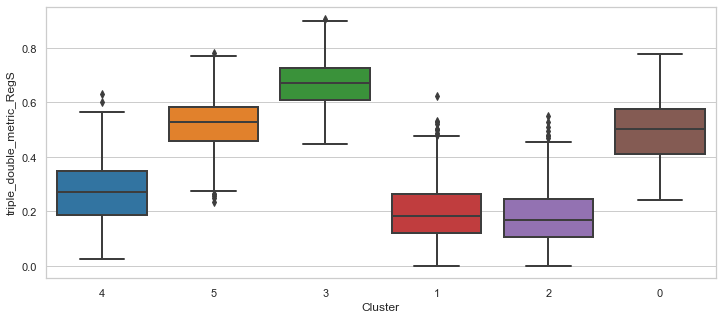

In [95]:
for i in stats_cols_regS:
    if df_clustering_board[i].dtype!='object':
        paint_num_dist(i,df_clustering_board)

### **Profiling**

##### No playoff players
Cluster 0: titularidades residuales, menos efectividad en tiros de campo, peores tiradores de 3 (menos por edad), menos rebotes, menos player eff rating y true shooting eff.

Cluster 1: algunas titularidades, 7-8 tiros por partido (casi mas peso que cluster 3),especialistas en tiros de 3 (mayor media de todos), casi tantos rebotes como cluster 3 (menos de lo esperado), segundo de mas asistencias, segundo mayor usage %, tercer win share.

Cluster 2: menos tiros por partido de todos, efectividad en tiros de campo +40%, menos asistencias, menos faltas personales.

##### Playoff players

Cluster 3: segundos jugadores con mas titularidades, una media de triples similar a cluster 4, segundo en rebotes, casi dos asistencias por partido, segundos mas FP, segundo mayor win share, segundo mayor triple doble de media.

Cluster 4: jugadores con mas titularidades de todos los clusters, mas tiros por partido, mas efectividad en los tiros, segunda media de triples (aqui puede que el tema histórico no ayude), primero en rebotes y asistencias, casi 3 FP, mayor player eff rating y true shooting eff rating, mayor win share, mayor triple double de media.

Cluster 5: +40% en tiros de campo casi el 75%, peores tiradores de 3, % mas bajo de los de playoff, menos usage percentatge.

In [106]:
pd.pivot_table(df_clustering_board, index = 'Cluster',values = stats_cols_regS)

,FT_goals_attempts_pg_RegS,FT_goals_attempts_total_RegS,FT_goals_percent_pg_RegS,_3pts_goals_attempts_pg_RegS,assists_pg_RegS,assists_total_RegS,field_goals_attempts_pg_RegS,field_goals_percent_pg_RegS,games_started_RegS,personal_foults_pg_RegS,player_eff_rating_RegS,total_rebounds_pg_RegS,triple_double_metric_RegS,true_shooting_eff_RegS,usage_percent_RegS,win_share_RegS
Cluster,,,,,,,,,,,,,,,,
0,2.312977,589.160305,0.736550,1.991603,2.344275,536.389313,8.740458,0.445573,88.053435,2.164885,13.236641,4.103053,0.496387,0.519290,20.101832,7.378626
1,1.118776,67.273469,0.598571,-0.439796,0.889184,54.983673,3.612245,0.365720,1.271429,1.374694,8.234204,1.763061,0.204803,0.415128,19.322735,0.319224
2,0.835842,54.580198,0.603877,0.691881,0.632475,41.441584,2.952475,0.399473,6.429703,1.113465,9.013069,1.718218,0.183795,0.465378,18.368535,0.428713
3,4.895683,4431.413669,0.776122,1.334173,4.019424,3632.708633,13.806115,0.465791,510.525180,2.678777,18.575899,6.596403,0.671439,0.538072,23.339928,90.779856
4,1.261709,284.234171,0.692123,0.313769,1.011960,232.772864,4.320704,0.423904,29.403015,1.623116,10.749015,2.479296,0.272590,0.482161,17.632412,4.170653
5,2.600288,1589.328859,0.747956,1.051965,2.208821,1362.044104,8.739406,0.458916,234.823586,2.423106,14.201534,4.585810,0.521576,0.524195,19.267613,30.126942


## Playoff stats profiling

In [97]:
playoff_cols

['games_started_Playoff',
 'field_goals_attempts_pg_Playoff',
 'field_goals_percent_pg_Playoff',
 '_3pts_goals_attempts_pg_Playoff',
 'FT_goals_attempts_pg_Playoff',
 'FT_goals_percent_pg_Playoff',
 'total_rebounds_pg_Playoff',
 'assists_pg_Playoff',
 'personal_foults_pg_Playoff',
 'FT_goals_attempts_total_Playoff',
 'assists_total_Playoff',
 'player_eff_rating_Playoff',
 'true_shooting_eff_Playoff',
 'usage_percent_Playoff',
 'win_share_Playoff',
 'Playoff_flag',
 'triple_double_metric_Playoff',
 'championship_pct',
 'n_playoff',
 'n_NBA_Champ']

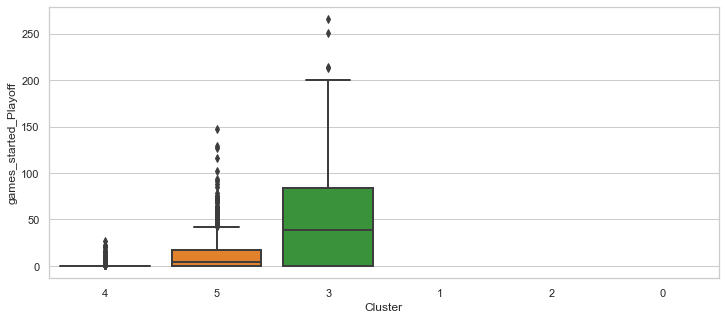

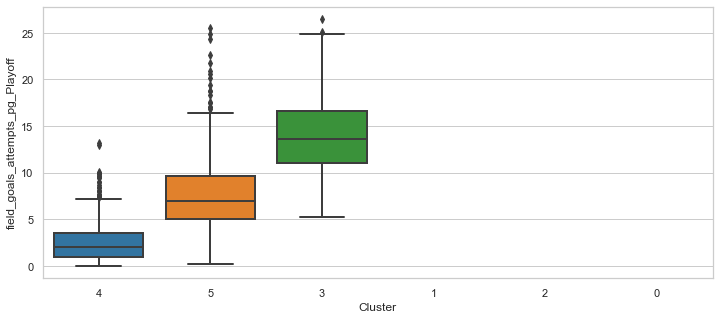

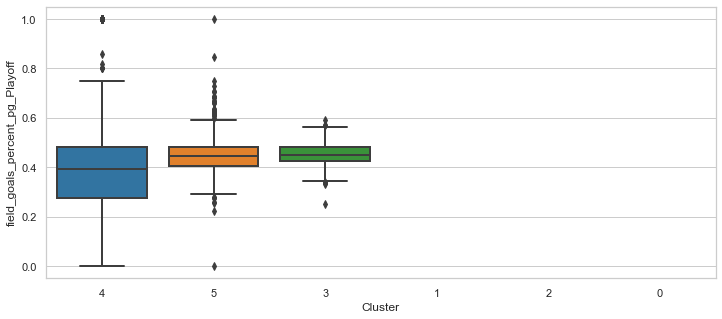

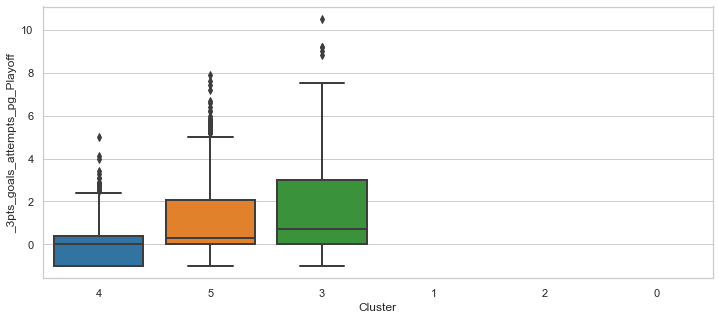

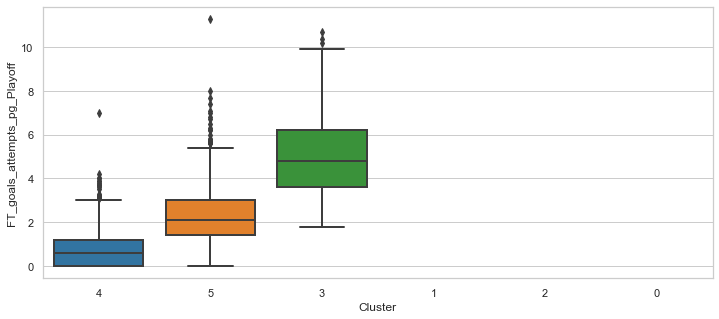

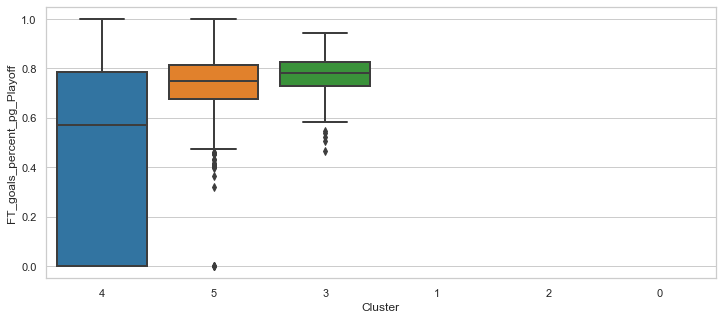

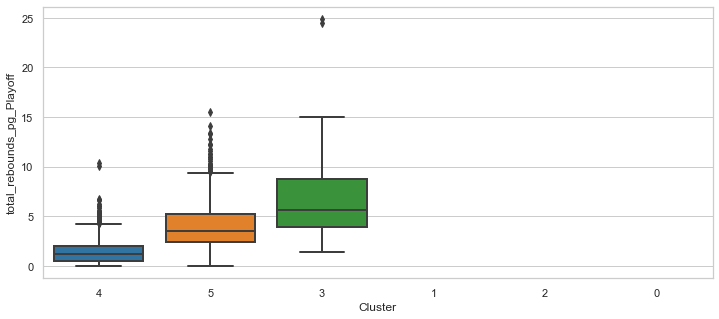

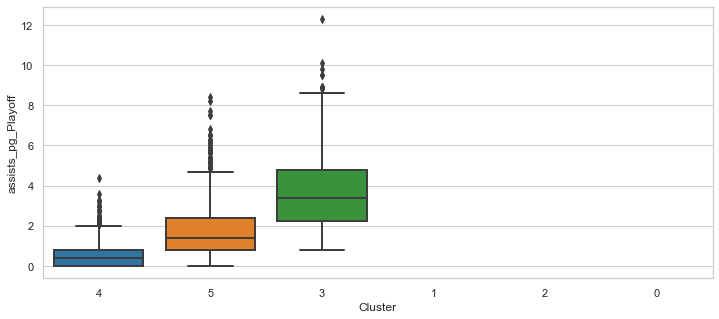

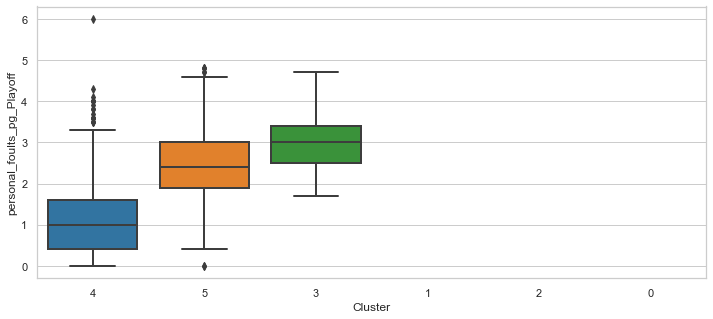

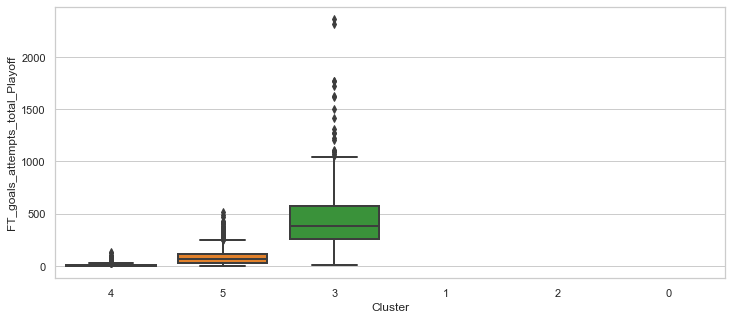

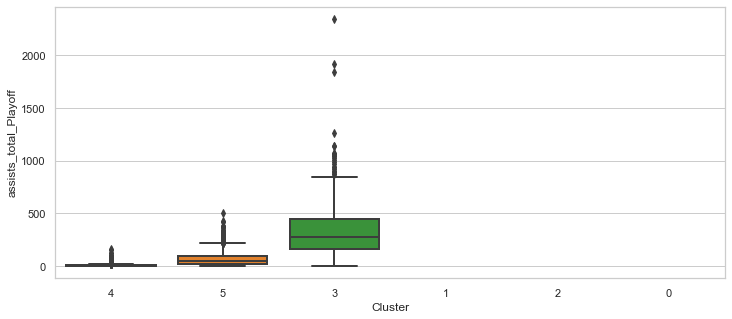

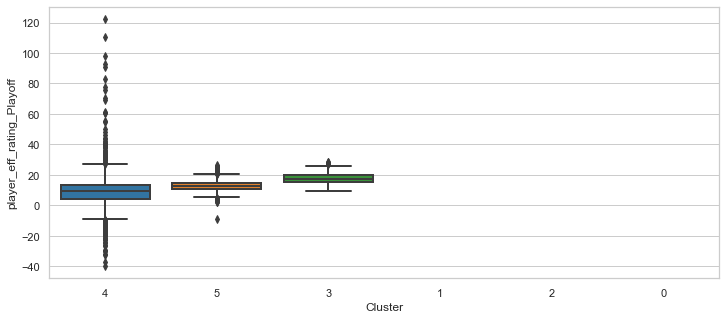

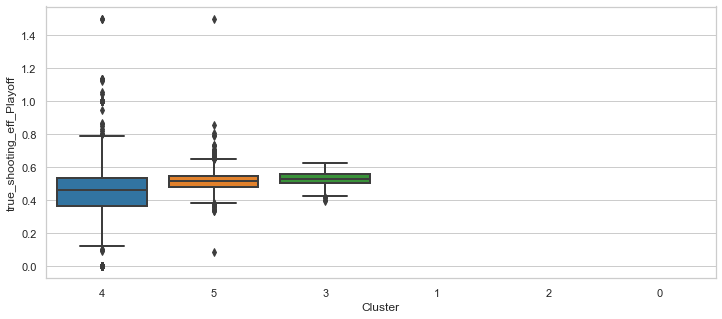

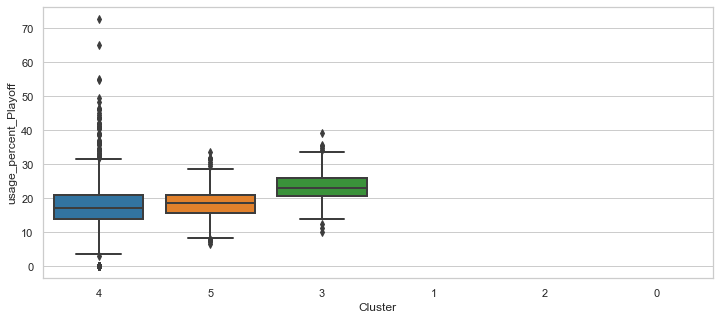

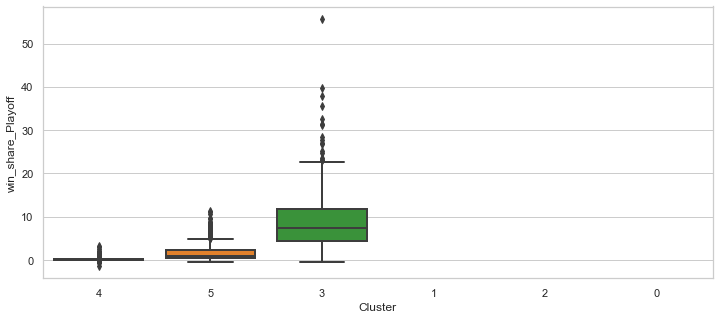

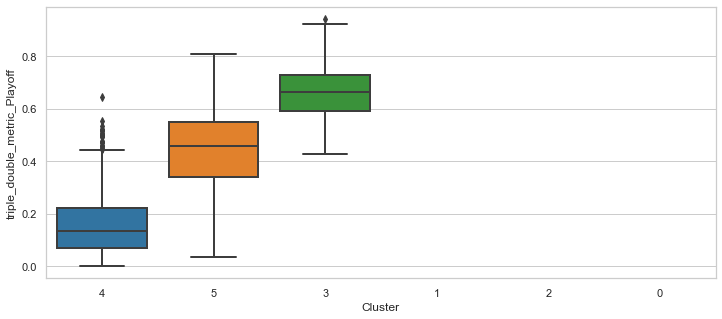

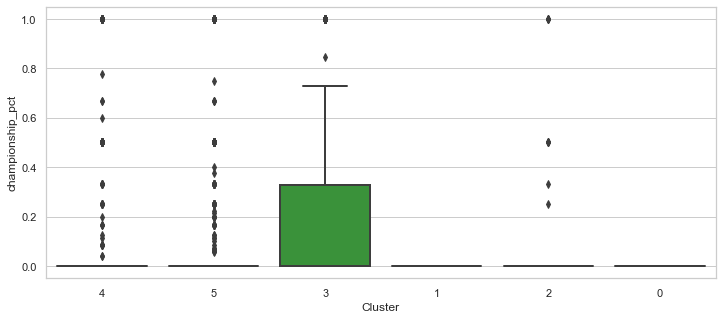

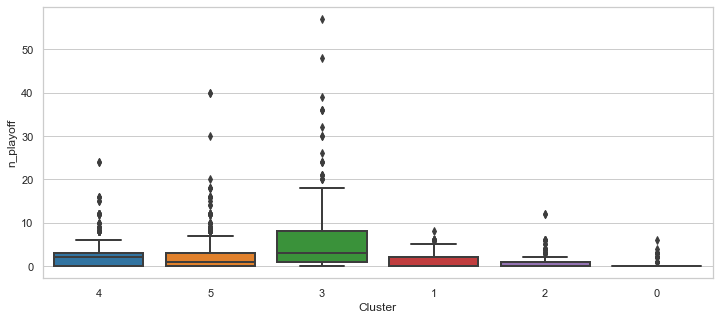

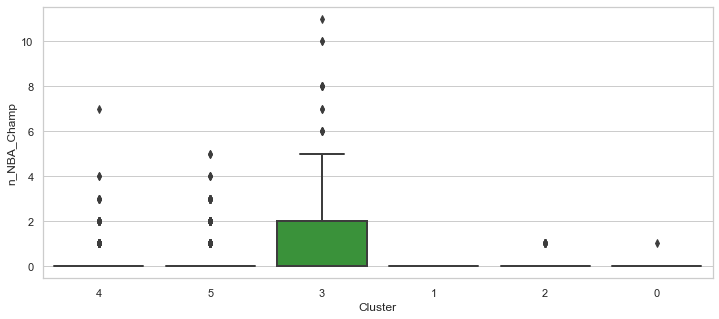

In [98]:
for i in playoff_cols:
    if df_clustering_board[i].dtype!='object':
        paint_num_dist(i,df_clustering_board)

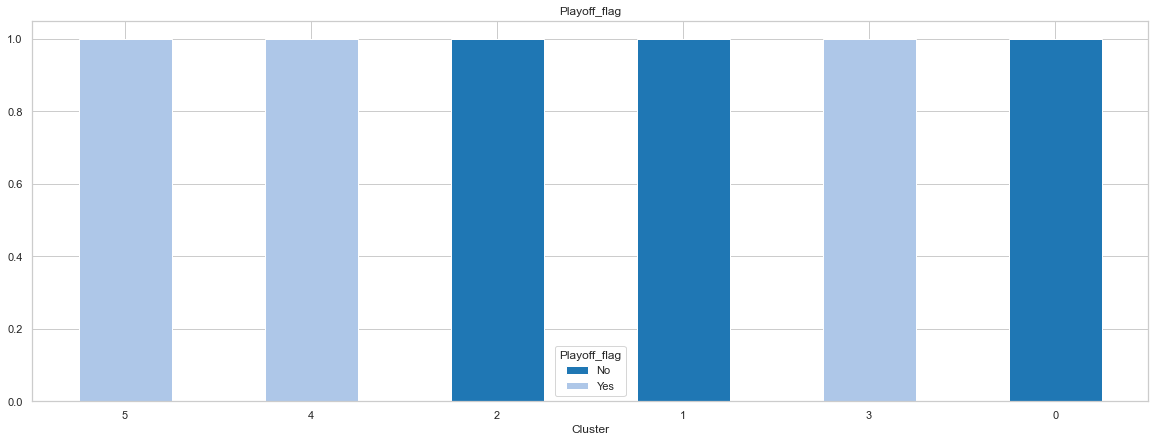

In [99]:
for i in playoff_cols:
    if df_clustering_board[i].dtype=='object':
        plot_cluster_distributions(df_clustering_board, var_x='Cluster', var_hue=i, sort=True , save_plot=False, _name='model', n_max=10) 

### **Profiling**

##### No playoff players
Cluster 0: nada.

Cluster 1: nada.

Cluster 2: nada.

##### Playoff players

Cluster 3: segundos con mayor número de partidos, casi mayor % de tiros de campo, mayores tiradores de 3, casi 80% de acierto en tiros libres.

Cluster 4: 40 y pico partidos jugados de playoff, casi 14 intentos por partido, +5 rebotes por partido, 2-3 FP por partido, muchos mas tiros libres, mayores asistencias, casi triple doble, mayor nombre de playoff de media, mas campeones.

Cluster 5: no llega a 2-3 tiros por partido, casi no tiran de 3 tampoco, muy por debajo que el resto (menos del 60%), muy pocas (<1) asistencias, mas playoff de media que 3.

In [100]:
pd.pivot_table(df_clustering_board, index = 'Cluster',values = playoff_cols)

,FT_goals_attempts_pg_Playoff,FT_goals_attempts_total_Playoff,FT_goals_percent_pg_Playoff,_3pts_goals_attempts_pg_Playoff,assists_pg_Playoff,assists_total_Playoff,championship_pct,field_goals_attempts_pg_Playoff,field_goals_percent_pg_Playoff,games_started_Playoff,n_NBA_Champ,n_playoff,personal_foults_pg_Playoff,player_eff_rating_Playoff,total_rebounds_pg_Playoff,triple_double_metric_Playoff,true_shooting_eff_Playoff,usage_percent_Playoff,win_share_Playoff
Cluster,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.007634,0.381679,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,1.059184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.013036,NaN,NaN,NaN,0.027723,0.697030,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.047842,482.744604,0.771784,1.493165,3.794604,361.467626,0.212978,13.941367,0.452935,51.039568,1.284173,5.935252,2.995324,17.606835,6.637410,0.664448,0.528795,23.144532,9.216187
4,0.780603,10.382915,0.493650,0.068844,0.551156,7.686432,0.050315,2.521709,0.372091,0.629146,0.172864,2.137688,1.104824,9.905839,1.478492,0.153863,0.454277,17.871940,0.111960
5,2.312081,88.415149,0.738563,0.982263,1.753787,69.726750,0.082964,7.565197,0.448101,12.129434,0.296261,2.418025,2.464621,12.923586,4.046021,0.447466,0.517092,18.451218,1.559732


In [101]:
df_clustering_board['Cluster']

0       4
1       4
2       4
3       4
4       4
       ..
3437    1
3438    2
3439    2
3440    2
3441    1
Name: Cluster, Length: 3442, dtype: object

## NBA players clusters profiling

### Cluster 0
#### Non-playoff young small players traded to losing teams

Descrip

- **Descriptive profiling**:
  - Third type of players with most years in the league mean: 4.1 years.
  - Players with least age of entrance mean: 22.2 years.
  - Second higher draft round mean: 1.4.
  - First mean of NBA All-Star appearances compared with non-playoff players: 0.09.
  - Players with worst win-lost pctg: 38.9% of wins.
  - 25% approx have gone to college.
  - Second cluster with less % of big man (F, C or F-C): 75% approx.
  
- **Regular season stats**:
  - xxxxx
- **Playoff stats**:
  - xxxxx
- **Example of players**:
  - xxxxx 

### Cluster 1
#### xxxxxxxxxxxxxxxxx

Descrip

- Descriptive profiling:
  - xxxxx
- Regular season stats:
  - xxxxx
- Playoff stats:
  - xxxxx
- Example of players:
  - xxxxx 

### Cluster 2
#### Non-playoff big players with short career at the NBA

Descrip

- Descriptive profiling:
  - xxxxx
- Regular season stats:
  - xxxxx
- Playoff stats:
  - xxxxx
- Example of players:
  - xxxxx 

### Cluster 3
#### xxxxxxxxxxxxxxxxx

Descrip

- Descriptive profiling:
  - xxxxx
- Regular season stats:
  - xxxxx
- Playoff stats:
  - xxxxx
- Example of players:
  - xxxxx 

### Cluster 4
#### xxxxxxxxxxxxxxxxx

Descrip

- Descriptive profiling:
  - xxxxx
- Regular season stats:
  - xxxxx
- Playoff stats:
  - xxxxx
- Example of players:
  - xxxxx 

### Cluster 5
#### xxxxxxxxxxxxxxxxx

Descrip

- Descriptive profiling:
  - xxxxx
- Regular season stats:
  - xxxxx
- Playoff stats:
  - xxxxx
- Example of players:
  - xxxxx 

In [ ]:
df_clustering_board.to_excel('Clust_Board.xlsx')

In [102]:
#per lligar amb el seguent problema, fer un gràfic dels clusters per any del draft!